# Vitual Sommelier : Final Project
Introduction to Data Science (MATH 4100/ COMP 5360), University of Utah.
### Github Repository
Collaboration between the team was done on git: https://github.com/ArithmeticR/COMP_5360_Project

### Team Members:
* Brian Tillman
* Li Jiada
* Trevor Olsen

## Background and Motivation
Brian has a background in User Experience Design. He is interested in using data to influnece interaction design.<br>
Li has a background in hydroinformatics, especially the big data in water resource management. He is interested in data mining and data visualization <br>
Trevor has a background in marketing research. He is interested in developing models for pricing products and identifying attributes to use in marketing.

## Project Objectives
The primary objective is to use natural language processing on wine reviews to classify the category, country, and taster by machine learning.
The secondary objective is to build an artificial neural network that classifies all three at once, then examine the output of the network ran backwards. The purpose being to discover insights into the different combinations of category, country, and taster. 

#### What the team wished to learn and accomplish?
Brian - Learn more about how to apply data analysis to solve marketing issues. Learn more about NLP and processing emotion in writing.<br>
Jiada - Learn more about how to visualize big data to dig out the valuable information which is hidden Benefits: With the data mining we can help people to change consumption behavior and save water<br>
Trevor - Learn more about NLP, and about ensemble methods.

# Data Processing

The data for the project was collected from https://www.winemag.com. The site contains 215,395 reviews of wines that include the price. The https://www.winemag.com/robots.txt site specifies the crawl-delay to be 5. Requiring around 300 hours (12.5 days) to scrape all the reviews from a single computer.
##### These are the fields extracted from each review:
<br>Url - Where the review is hosted.
<br>Title - Name of the review.
<br>Points - Number of points given in the review. On a 100 point scale.
<br>Description - The taster's review of the wine.
<br>Price - Price of the wine. We think it's all in dollars.
<br>Variety - Type of wine.
<br>Appellation - a name or title of the wine.
<br>Winery - Location the wine was produced.
<br>Alcohol - Percent of achohol.
<br>Bottle Size - Size of the wine bottle. It might all be in millilitres.
<br>Category - Category of the wine.
<br>Importer - Name of the importer.
<br>Date Published - Date the review was published.
<br>User Avg Rating - Rating of the review.
<br>Taster - Name of the reviewer.

# Libraries for scraping

In [ ]:
############################################
###
### Don't Run only for presentation
### 
############################################

import pandas as pd
import scipy as sc
import numpy as np
from bs4 import BeautifulSoup
import requests
import urllib.request
import pickle
import glob
import re
import time
import statsmodels.formula.api as sm

# Get individual review urls

Extracting the data was very similar to the web scraping homework for the github repositories. The first step was scapping the url for the individual pages from the site filtering on price. This ensured that only reviews with price were pulled.

One thing to point out about the code (see * below) is the way the crawl delay was implemented. The process slept for 5 seconds minus the number of seconds transpired since the individual url request began.  


In [ ]:
############################################
###
### Don't Run only for presentation
### 
############################################

session = requests.Session()
HEADERS = {
    'user-agent': ('Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 '
                   '(KHTML, like Gecko) Chrome/48.0.2564.109 Safari/537.36')
}
first_page = 1
last_page = 7180
results_url = "https://www.winemag.com/?s=&drink_type=wine&price=1.0-15.99,16.0-25.99,100.0-199.99,76.0-99.99,61.0-75.99,41.0-60.99,26.0-40.99,200.0-*&page="
raw_pages = []
for i in range(first_page, last_page + 1 ):
    time_from_request = time.time() # (*)
    url = results_url + str(i)
    print(i)
    response = session.get(url, headers=HEADERS)
    my_page = BeautifulSoup(response.content, 'html.parser')
    raw_review_urls = [ review.get("href") for review in my_page.select(".review-item a")]
    clean_review_urls = [ my_url for my_url in raw_review_urls  if   bool(re.search(r'^https://www.winemag.com/buying-guide/', my_url))]
    pickle.dump( clean_review_urls, open( "urls/raw_pages"+str(i)+".p", "wb" ) )
    if time.time() - time_from_request < 5: # (*)
        time.sleep(5.01 - (time.time() - time_from_request))



Not shown in the code above is the step where all the pickled files are concatenated together to form a master list of the individual review urls.

# Scape individual reviews

Each review is written out to disk once it is scraped. These are some of the benefits from using this approach:
* Each url request has to take 5 seconds, so might as well utilize some of that time doing something other than sleeping.
* Only can lose one review at a time when the process crashes.
* If the process does crash, then it can quickly find where it left off.

This is the function used to write each review out to disk. Notice that it wasn't exactly clear what fields would be contained in the primary and secondary blocks. The function concatenates the field name and values with "||||". The assumption is that "||||" is unique enough not to appear in the field name.


In [ ]:
############################################
###
### Don't Run only for presentation
### 
############################################

def write_my_file(i, raw_review_pages):
    file = open("reviews/url_" + str(i) + ".txt", "w")
    x = raw_review_pages
    url_i = x[0]
    title = x[1]
    points = x[2]
    description = x[3]
    taster = x[8]
    primary_info_label = x[4]
    primary_info = x[5]
    secondary_info_label = x[6]
    secondary_info = x[7]
    file.write(str(url_i).replace('\n', '').replace('\t', ''))
    file.write("\t")
    file.write(str(title).replace('\n', '').replace('\t', ''))
    file.write("\t")
    file.write(str(points).replace('\n', '').replace('\t', ''))
    file.write("\t")
    file.write(str(description).replace('\n', '').replace('\t', ''))
    file.write("\t")
    file.write(str(taster).replace('\n', '').replace('\t', ''))
    file.write("\t")
    for y, z in zip(primary_info_label, primary_info):
        file.write(str(y).replace('\n', '').replace('\t', '').replace('<span>', '').replace('</span>', ''))
        file.write("||||")
        z = str(z).replace('\n', '').replace('\t', '')
        z = re.sub(r"<.+?>", "", z)
        file.write(z)
        file.write("\t")
    for y, z in zip(secondary_info_label, secondary_info):
        y = str(y).replace('\n', '').replace('\t', '').replace('<span>', '').replace('</span>', '')
        if y != "User Avg Rating":
            file.write(str(y).replace('\n', '').replace('\t', '').replace('<span>', '').replace('</span>', ''))
            file.write("||||")
            z = str(z).replace('\n', '').replace('\t', '')
            z = re.sub(r"<.+?>", "", z)
            file.write(z)
            file.write("\t")
    file.write("\n")
    file.close()  

This code uses the file 'not_picked.csv'. This file contains all the urls that had not been scrapped by the beginning of the process. The code to create this file is not shown, but this is done by preforming a set difference on the master url list with the urls that have already been pulled. This was done twice to ensure all the urls were indeed pulled. Some of the page requests failed the first time they were tried, and others never worked.

The code checks at each iteration whether the file with the 'page_i_in_loop' index already exists. The cost in inefficiency was offset by the ease of restarting the process upon failure.  

In [ ]:
############################################
###
### Don't Run only for presentation
### 
############################################

df = pd.read_csv('not_picked.csv')
all_urls = df.x.values.tolist()
 
session = requests.Session()
HEADERS = {
    'user-agent': ('Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 '
                   '(KHTML, like Gecko) Chrome/48.0.2564.109 Safari/537.36')
}
first_page = 1
last_page = 215395
for page_i_in_loop in range(first_page, last_page + 1):
    time_from_request = time.time()
    my_files = glob.glob("reviews/*.txt")
    ## check string twice because the differences in windows and linux machines
    if "reviews/url_" + str(page_i_in_loop) + ".txt" not in my_files and "reviews\\url_" + str(page_i_in_loop) + ".txt" not in my_files :
        url_i = all_urls[page_i_in_loop]
        try:
            response = session.get(url_i, headers=HEADERS)
            soup_review_page = BeautifulSoup(response.content, 'html.parser')
            structure_reviews = []
            try:
                title = soup_review_page.select(".heading-area .article-title")[0].text
            except:
                title = None
            try:
                points = soup_review_page.select(".rating #points")[0].text
            except:
                points = None
            try:
                description = soup_review_page.select(".description")[0].text
            except:
                description = None
            try:
                primary_info_label = soup_review_page.select(".primary-info .row .info-label span")
            except:
                primary_info_label = None
            try:
                primary_info = soup_review_page.select(".primary-info .row .info")
            except:
                primary_info = None
            try:
                secondary_info = soup_review_page.select(".secondary-info .row .info")
            except:
                secondary_info = None
            try:
                secondary_info_label = soup_review_page.select(".secondary-info .row .info-label span")
            except:
                secondary_info_label = None
            try:
                taster = soup_review_page.select(".taster .name")[0].text
            except:
                taster = None
            print(page_i_in_loop)
            structure_reviews=[url_i, title, points, description, primary_info_label,
                                      primary_info, secondary_info_label,
                                      secondary_info, taster]
            print(page_i_in_loop)
            write_my_file(page_i_in_loop, structure_reviews)
        except Exception as e:
            print(str(e))
        if time.time() - time_from_request < 5:
            time.sleep(5.01 - (time.time() - time_from_request))



### Side Notes
Truth be told, collecting the data was more of a pain than first thought. First we tried pickling the reviews in batches, but the files sizes were enormous. Still not sure exactly why. Maybe it was because of the string encoding or the nested structure we were using. Some time was wasted before switching to text files for storage (which greatly reduced the size). This was a bit of a time consuming process and we needed 13 days to pull the data on a single computer. 

So, what ended up happening was running 10 linux servers (The max number allow by default at digitalocean.com) and collecting the reviews once the process was refined. This code above is very similar to the code ran on these machines. The github repo contains 24 branches for this reason.  

# R code - Consolidate Reviews

The right encoding was difficult to find in python (encoding = "ISO-8859-1"). For this reason, R was initially used to consolidate the reviews. For whatever reason, R was able to read the files in without any encoding issues. Some care had to be taken to handle the fields from the primary and secondary blocks.

In [ ]:
######################################
###
#### R Code
###
#######################################

############################################
###
### Don't Run only for presentation
### 
############################################
all_files <- list.files(path = "reviews", pattern = ".txt", 
             all.files = FALSE,
             full.names = T, recursive = FALSE,
             ignore.case = FALSE, include.dirs = FALSE, no.. = FALSE)

my_input <- matrix(NA,nrow=300000 ,ncol=20)
myinput_list <-  vector("list", length = 300000)
i = 1
for(my_file in all_files){
  con = file(my_file, "r")
  while ( TRUE ) {
    line = readLines(con, n = 1)
    if ( length(line) == 0 ) {
      break
    }
    myinput_list[i] <-strsplit(line,"\t")
    i = i + 1
  }
  close(con)
}
myinput_list2 <- purrr::compact(myinput_list)
myinput_list3 <- myinput_list2
my_matrix <- matrix(NA, nrow=length(myinput_list3), ncol=15)
for(my_name in seq_along(myinput_list3)){
  my_length <- length(myinput_list3[[my_name]])
  if(my_length>12){
  my_matrix[my_name,1:my_length] <- myinput_list3[[my_name]]
  }
}
my_df <- as.data.frame(my_matrix,stringsAsFactors=FALSE)
my_df2 <- my_df[!duplicated(my_df$V1),]
colnames(my_df2) <- c('url','title','points','description','taster',paste0('V',6:15))
table(my_df2$taster)
my_df2[1,] 
save(my_df2,file="unstructured_df.rdata")


# R code - Basic Cleaning

Some basic cleaning and transformations were done in R, since the encoding still had not been figured out for python.

The code for handling the primary and secondary blocks (code between the (*) comments) is very inefficient, but was offset by the ease of coding.   

The files were chunked into 20,000 review blocks. This seemed to be the right number to keep the chunks under the 25 mb limit for pushing to github. 

In [ ]:
######################################
###
#### R Code
###
#######################################

############################################
###
### Don't Run only for presentation
### 
############################################
load(file="unstructured_df.rdata")

# (*) handling the primary and secondary blocks
for(i in 1:nrow(my_df2)){ 
  for(j in 6:15){
    my_split <- strsplit(my_df2[i,j],"||||",fixed=T)[[1]]
    if(!make.names(my_split[1]) %in% colnames(my_df2)){
      my_df2[[make.names(my_split[1]) ]] <- NA
    }
    my_df2[i,make.names(my_split[1]) ] <- my_split[2]
  }
}
# (*)

my_df3  <- my_df2[, -c(6:15)]
my_df3  <- my_df3[, -c(15)] 


my_df3$Price2 <- as.numeric(gsub("$","",gsub(",  Buy Now","",my_df3$Price), fixed = T))
my_df3$Alcohol2 <- as.numeric(gsub("%","",my_df3$Alcohol))/100
my_df3$Bottle.Size2 <- gsub("ml","",gsub(" ","",tolower(my_df3$Bottle.Size), fixed = T))
my_df3$milliliters <-ifelse(grepl("l",my_df3$Bottle.Size2), 
                            as.numeric(gsub("l","",my_df3$Bottle.Size2)) * 1000, 
                            as.numeric(my_df3$Bottle.Size2))

my_df3$price_per_liter <- 1000*my_df3$Price2/   my_df3$milliliters

Appellations <- strsplit(my_df3$Appellation,",")
my_df3$l1<- NA
my_df3$l2<- NA
my_df3$l3<- NA
my_df3$l4<- NA
my_df3$l5<- NA
i=2
for(i in 1:nrow(my_df3)){
  my_df3[i,paste0('l',(5-length(Appellations[[i]])+1):5)] <- trimws(Appellations[[i]])
}
names_vector <- c("url" , "Date.Published","title", "taster"  ,
                  "Alcohol" , "Alcohol2",
                  "Bottle.Size","Bottle.Size2", "milliliters" ,
                  "points","Price", "Price2"  ,"price_per_liter",
                    "Importer"     , "Winery" ,
                  "Appellation"   ,  "l1" ,  "l2" ,"l3" ,   "l4", "l5"
                    ,  "Designation","Category" , "Variety" , "description")
my_df3 <- my_df3[,names_vector]
for(i in 1:10){
  write.table(my_df3[((i-1)*20000+1):((i)*20000),], 
  file=paste0("structured_df_",i,".txt"), sep="\t", row.names = F)
}
write.table(my_df3[200001:214103,],file=paste0("structured_df_",11,".txt"), sep="\t", row.names = F)
save(my_df3,file="structured_df.rdata")
write.table(my_df3,file="structured_df.txt", sep="\t", row.names = F)


#  Libraries for the rest of the code

## must rerun for interactive chart!

In [1]:
%%javascript
require.config({
  paths: {
    highcharts: "http://code.highcharts.com/highcharts",
    highcharts_exports: "http://code.highcharts.com/modules/exporting",
  },
  shim: {
    highcharts: {
      exports: "Highcharts",
      deps: ["jquery"]
    },
    highcharts_exports: {
      exports: "Highcharts",
      deps: ["highcharts"]
    }
  }
});

<IPython.core.display.Javascript object>

In [2]:
from PIL import Image
from wordcloud import WordCloud
import math
import numpy as np
import scipy as sc
import pandas as pd

import pylab 
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.utils import shuffle

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 9)
plt.style.use('ggplot')

from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import scale
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor


from sklearn.ensemble import VotingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import Normalizer

from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Getting Data into Python

# Read in data
The right encoding turned out to be "ISO-8859-1". The files had been chunked into file sizes below 25 mbs. This allowed them to be stored on github.

In [3]:
df = pd.read_csv('structured_df_1.txt',sep='\t', encoding = "ISO-8859-1")
for i in range(1,12):
    df = df.append(pd.read_csv('structured_df_'+str(i)+'.txt',sep='\t', encoding = "ISO-8859-1"))
df = df.drop_duplicates()
df.shape

(214103, 25)

In [4]:
df2 = df[df.description.notnull()]
df2 = df2[df2.points.notnull()]
df2 = df2[df2.price_per_liter.notnull()]
df2.shape

(209895, 25)

In [5]:
df2[['price_per_liter_clip']]= df2[['price_per_liter']].clip(0,100)

# Exploratory Analysis


In [5]:
df2.dtypes

url                      object
Date.Published           object
title                    object
taster                   object
Alcohol                  object
Alcohol2                float64
Bottle.Size              object
Bottle.Size2             object
milliliters             float64
points                  float64
Price                    object
Price2                  float64
price_per_liter         float64
Importer                 object
Winery                   object
Appellation              object
l1                       object
l2                       object
l3                       object
l4                       object
l5                       object
Designation              object
Category                 object
Variety                  object
description              object
price_per_liter_clip    float64
dtype: object

In [6]:
df2.describe()

Alcohol2    milliliters         points         Price2  \
count  178749.000000  209895.000000  209895.000000  209895.000000   
mean        0.137098     748.129827      88.072612      33.859905   
std         0.226622      76.117666       3.155364      41.619085   
min         0.015000     187.000000      22.000000       4.000000   
25%         0.130000     750.000000      86.000000      16.000000   
50%         0.135000     750.000000      88.000000      25.000000   
75%         0.144000     750.000000      90.000000      40.000000   
max        83.330000    3000.000000     100.000000    6000.000000   

       price_per_liter  price_per_liter_clip  
count    209895.000000         209895.000000  
mean         45.854517             41.009230  
std          58.627023             25.460287  
min           5.000000              5.000000  
25%          21.333333             21.333333  
50%          33.333333             33.333333  
75%          53.333333             53.333333  
max        8000.000000            100.000000

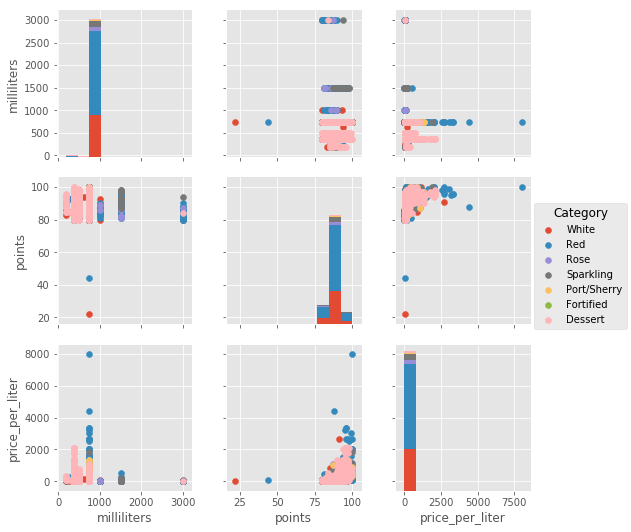

In [7]:
g = sns.PairGrid(df2[['milliliters','points','price_per_liter','Category']], hue="Category")
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

There are a lot of missing values for alcohol. Plus some values coded on the wrong scale. 

In [8]:
df2.taster.value_counts()

None                  63705
Roger Voss            30078
Michael Schachner     28296
Paul Gregutt          17770
Joe Czerwinski        12903
Kerin OâKeefe       11682
Virginie Boone        11223
Matt Kettmann          7189
Anna Lee C. Iijima     5529
Sean P. Sullivan       5478
Jim Gordon             4700
Anne KrebiehlÂ MW      3824
Lauren Buzzeo          2624
Susan Kostrzewa        2455
Alexander Peartree      604
Mike DeSimone           597
Jeff Jenssen            540
Christina Pickard       340
Carrie Dykes            169
Sarah E. Daniels        134
Fiona Adams              55
Name: taster, dtype: int64

30% of the reviews do not have an offical taster. They are labeled 'None'.

In [9]:
df2.Category.value_counts()

Red            127823
White           62802
Sparkling        9033
Rose             5910
Dessert          2837
Port/Sherry      1380
Fortified         110
Name: Category, dtype: int64

60% of the reviews are red, and 91% are either red or white.

In [10]:
df2.l5.value_counts()

US                        94567
France                    28196
Italy                     27141
Spain                     11775
Chile                      8094
Portugal                   7393
Australia                  7281
Argentina                  7104
Austria                    4276
Germany                    3856
South Africa               3251
New Zealand                3203
Greece                      875
Israel                      771
Canada                      342
Hungary                     239
Bulgaria                    189
Uruguay                     186
Romania                     166
Croatia                     109
Turkey                      106
Georgia                     106
Mexico                       96
Moldova                      92
Slovenia                     91
Brazil                       74
England                      67
Lebanon                      52
Morocco                      28
Peru                         20
Cyprus                       20
Ukraine 

In [11]:
pd.crosstab(df2.taster,df2.Category)

Category            Dessert  Fortified  Port/Sherry    Red  Rose  Sparkling  \
taster                                                                        
Alexander Peartree        7          4            4    312    27         13   
Anna Lee C. Iijima      192          0            0   1342   200        188   
Anne KrebiehlÂ MW        97          0            0    588    59        354   
Carrie Dykes              5          1            1     96     6          0   
Christina Pickard         0          0            0    190     0          8   
Fiona Adams               0          0            0     36     0          8   
Jeff Jenssen             34          0            0    235    18         15   
Jim Gordon               46          1            7   3112   147        126   
Joe Czerwinski          242         14          157   6282   438        408   
Kerin OâKeefe         127          7            0   8166   135        947   
Lauren Buzzeo            29         25            0   1381   246         44   
Matt Kettmann            38          0            8   4804   236         79   
Michael Schachner       152          2          253  19591   662       1254   
Mike DeSimone             2          0            0    422    23          4   
None                    985          7           98  41773   975       2459   
Paul Gregutt             89          1            6  12089   288        297   
Roger Voss              551         45          820  14358  1933       2576   
Sarah E. Daniels          0          0            0     57     0          3   
Sean P. Sullivan         78          2            2   3975   150         29   
Susan Kostrzewa          96          0            4   1207    94         37   
Virginie Boone           67          1           20   7807   273        184   

Category            White  
taster                     
Alexander Peartree    237  
Anna Lee C. Iijima   3607  
Anne KrebiehlÂ MW    2726  
Carrie Dykes           60  
Christina Pickard     142  
Fiona Adams            11  
Jeff Jenssen          238  
Jim Gordon           1261  
Joe Czerwinski       5362  
Kerin OâKeefe      2300  
Lauren Buzzeo         899  
Matt Kettmann        2024  
Michael Schachner    6382  
Mike DeSimone         146  
None                17408  
Paul Gregutt         5000  
Roger Voss           9795  
Sarah E. Daniels       74  
Sean P. Sullivan     1242  
Susan Kostrzewa      1017  
Virginie Boone       2871

In [12]:
pd.crosstab(df2.l5,df2.taster)

taster                  Alexander Peartree  Anna Lee C. Iijima  \
l5                                                               
Albania                                  0                   0   
Argentina                                0                   0   
Armenia                                  0                   0   
Australia                                0                   0   
Austria                                  0                   0   
Bosnia and Herzegovina                   0                   2   
Brazil                                   0                   0   
Bulgaria                                 0                  25   
Canada                                   0                  24   
Chile                                    0                   0   
China                                    0                   0   
Croatia                                  0                  57   
Cyprus                                   0                   0   
Czech Republic                           0                   7   
England                                  0                   0   
France                                   0                 120   
Georgia                                  0                  25   
Germany                                  0                2187   
Greece                                   0                   0   
Hungary                                  0                  47   
India                                    0                   1   
Israel                                   0                   0   
Italy                                   81                   0   
Japan                                    0                   0   
Kosovo                                   0                   0   
Lebanon                                  0                  18   
Lithuania                                0                   0   
Luxembourg                               0                   0   
Macedonia                                0                   1   
Mexico                                   0                   0   
Moldova                                  0                   1   
Montenegro                               0                   1   
Morocco                                  0                   1   
New Zealand                              0                   0   
Peru                                     0                   0   
Portugal                                 0                   0   
Romania                                  0                  58   
Serbia                                   0                   0   
Slovakia                                 0                   1   
Slovenia                                 0                  31   
South Africa                             0                   0   
South Korea                              0                   0   
Spain                                    0                   0   
Switzerland                              0                   0   
Turkey                                   0                  10   
US                                     523                2907   
US-France                                0                   0   
Ukraine                                  0                   5   
Uruguay                                  0                   0   

taster                  Anne KrebiehlÂ MW  Carrie Dykes  Christina Pickard  \
l5                                                                           
Albania                                 0             0                  0   
Argentina                               0             0                  0   
Armenia                                 0             0                  0   
Australia                               0             0                185   
Austria                              2259             0                  0   
Bosnia and Herzegovina                  0             0                  0   
Brazil   

In [13]:
pd.crosstab(df2.l5,df2.Category)

Category                Dessert  Fortified  Port/Sherry    Red  Rose  \
l5                                                                     
Albania                       0          0            0      1     0   
Argentina                     9          0            0   5547   107   
Armenia                       0          0            0      3     1   
Australia                    87          2           34   4740    94   
Austria                     286          0            0    972    80   
Bosnia and Herzegovina        0          0            0      3     0   
Brazil                        0          0            0     40     0   
Bulgaria                      0          0            0    120     6   
Canada                       88          0            0    119     4   
Chile                        57          0            0   5578   103   
China                         0          0            0      5     1   
Croatia                       2          0            0     51     5   
Cyprus                        5          0            0      8     0   
Czech Republic                0          0            0      6     0   
England                       0          0            0      0     0   
France                      377         46            2  12813  2227   
Georgia                       1          0            0     48     4   
Germany                     165          0            0    228    27   
Greece                       30          0            0    389    31   
Hungary                      67          0            0     66     5   
India                         0          0            0      5     0   
Israel                       10          0            1    585    16   
Italy                       554         11            7  17999   319   
Japan                         0          0            0      0     0   
Kosovo                        0          0            0      4     0   
Lebanon                       0          0            0     25     7   
Lithuania                     0          0            0      0     0   
Luxembourg                    0          0            0      0     0   
Macedonia                     0          0            0     12     0   
Mexico                        0          0            0     63     4   
Moldova                       5          0            0     50     1   
Montenegro                    0          0            0      1     0   
Morocco                       0          0            0     18     1   
New Zealand                  12          0            0   1241    13   
Peru                          0          0            0     14     0   
Portugal                     23         37          994   4044   288   
Romania                       1          0            0     77     3   
Serbia                        0          0            0      6     0   
Slovakia                      0          0            0      0     0   
Slovenia                      1          0            0     22     2   
South Africa                 31          0            5   1765    73   
South Korea                   0          0            0      3     0   
Spain                        78          1          223   7623   448   
Switzerland                   0          0            0      7     2   
Turkey                        0          0            0     74     7   
US                          944         12          114  63290  2026   
US-France                     0          0            0      0     0   
Ukraine                       2          0            0      3     1   
Uruguay                       2          1            0    155     4   

Category                Sparkling  White  
l5                                        
Albania                         0      0  
Argentina                      71   1370  
Armenia                         0      1  
Australia                     162   2162  
Austria                       113   2825  
Bosnia and Herzegovina    

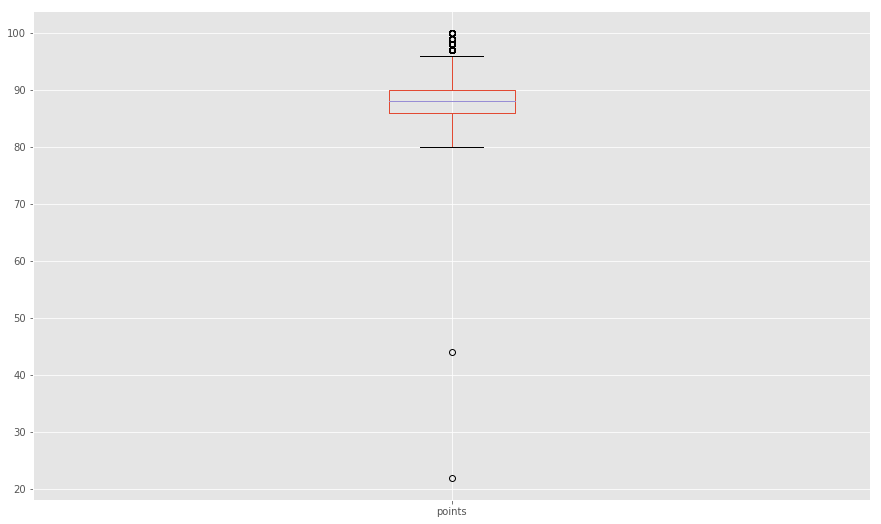

In [14]:
df2.boxplot(column='points', by=None)

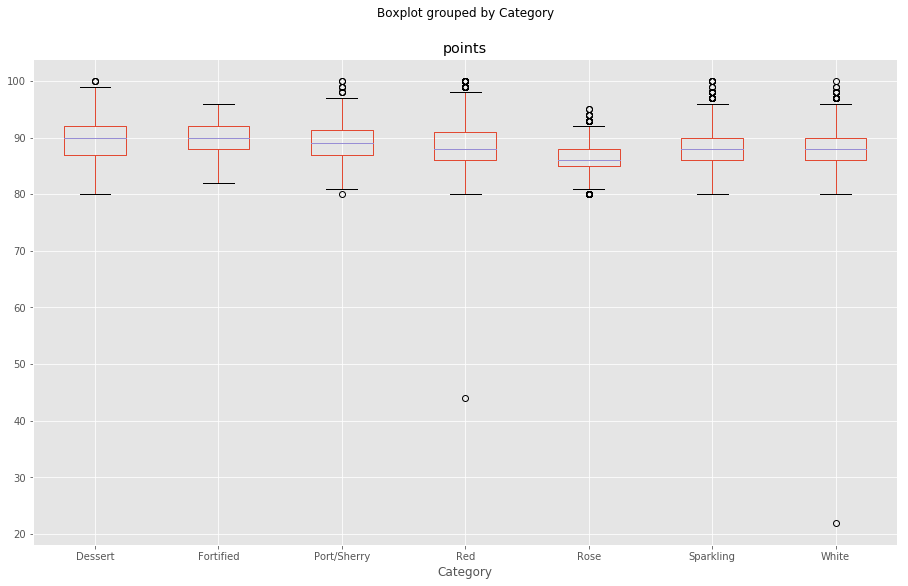

In [15]:
df2.boxplot(column='points', by='Category')

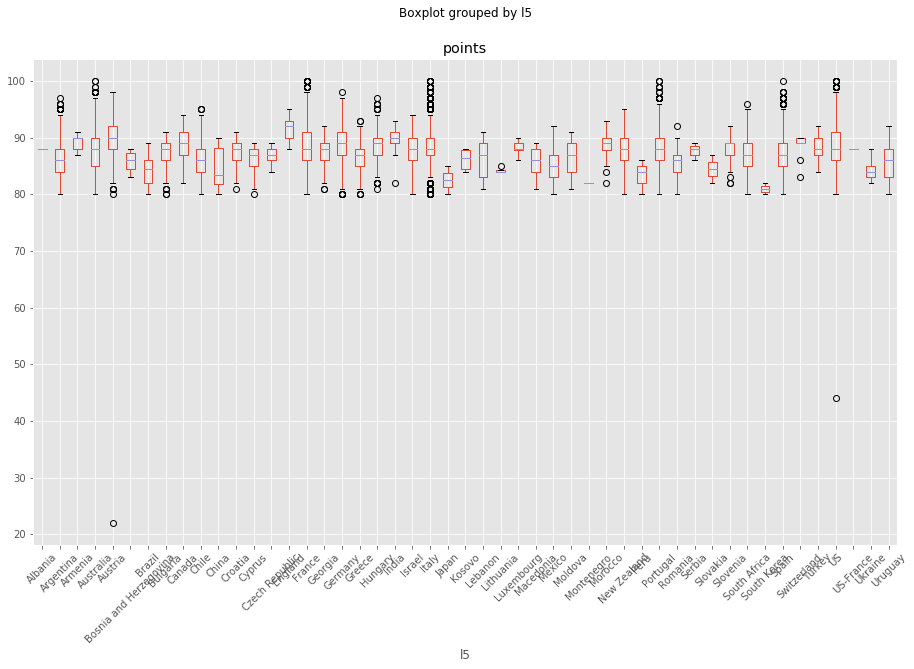

In [16]:
df2.boxplot(column='points', by='l5',rot=45)

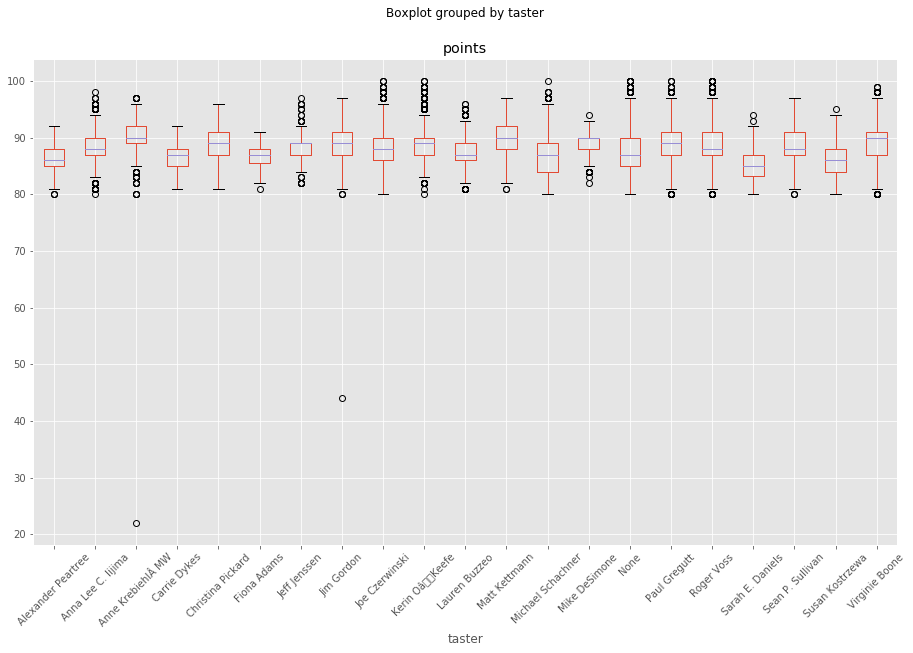

In [17]:
df2.boxplot(column='points', by='taster',rot=45)

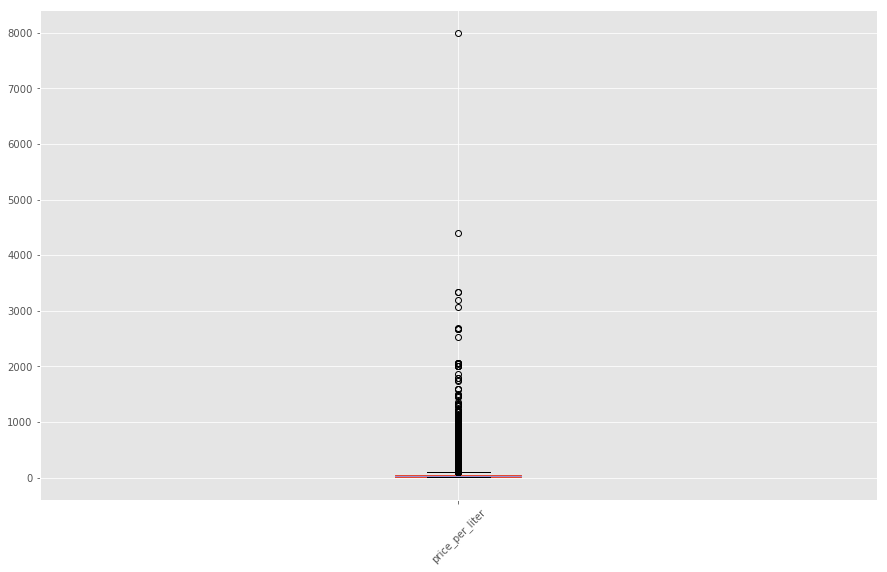

In [18]:
df2.boxplot(column='price_per_liter', by=None,rot=45)

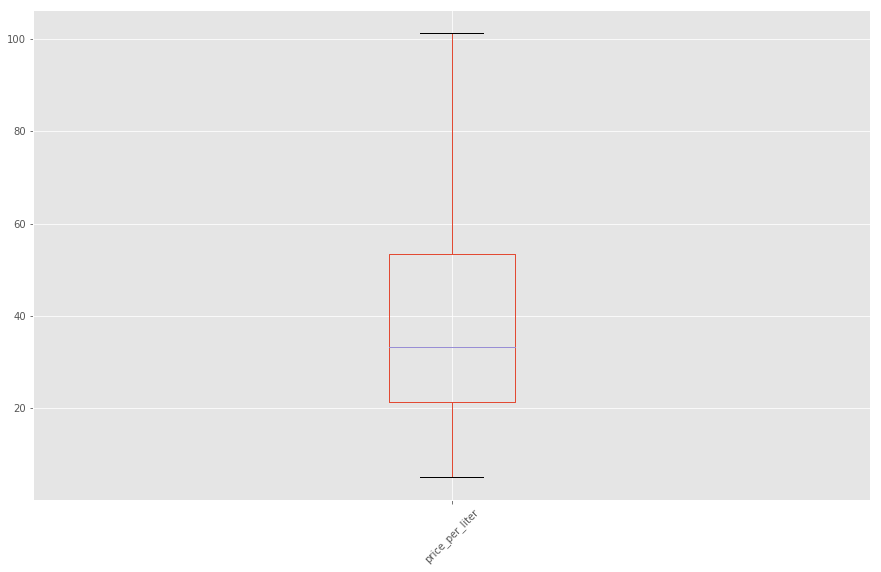

In [19]:
df2.boxplot(column='price_per_liter', by=None,rot=45 , showfliers=False)

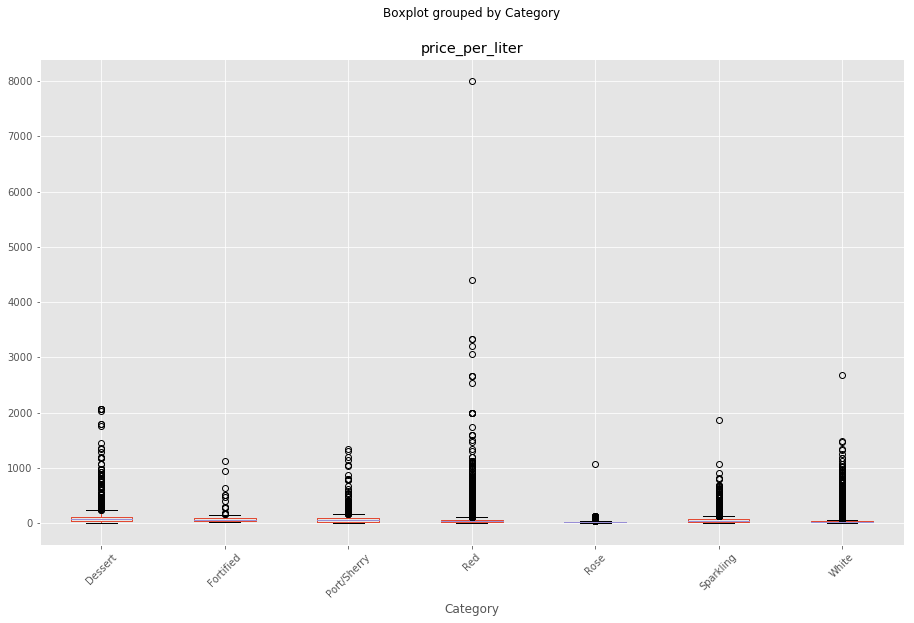

In [20]:
df2.boxplot(column='price_per_liter', by='Category',rot=45)

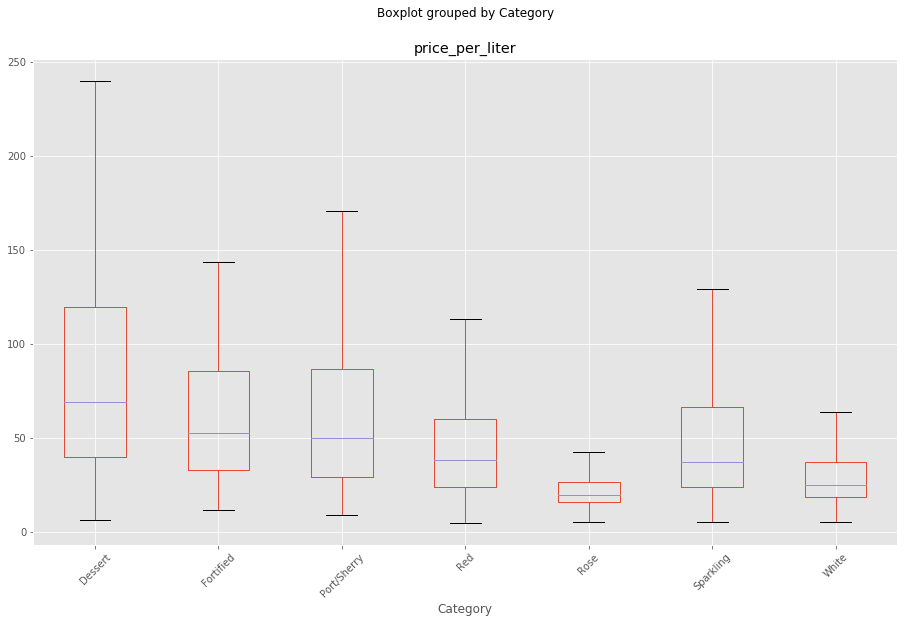

In [21]:
df2.boxplot(column='price_per_liter', by='Category',rot=45 , showfliers=False)

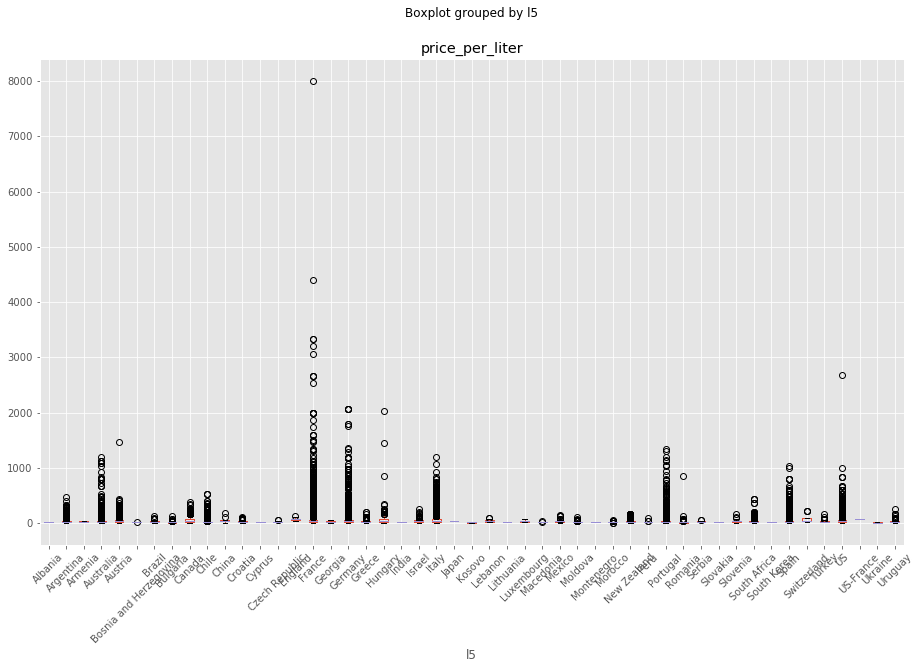

In [22]:
df2.boxplot(column='price_per_liter', by='l5',rot=45)

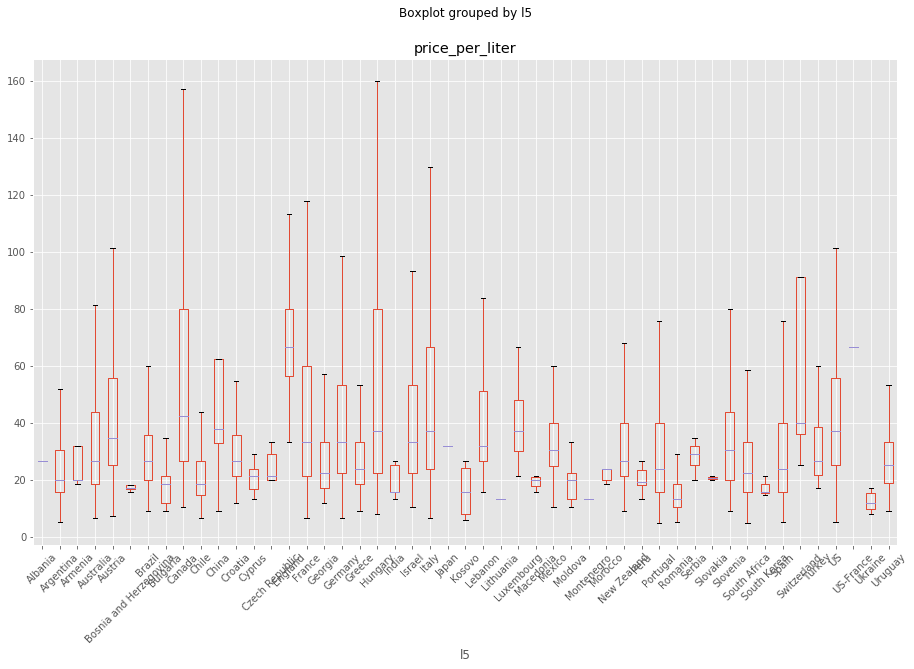

In [23]:
df2.boxplot(column='price_per_liter', by='l5',rot=45 , showfliers=False)

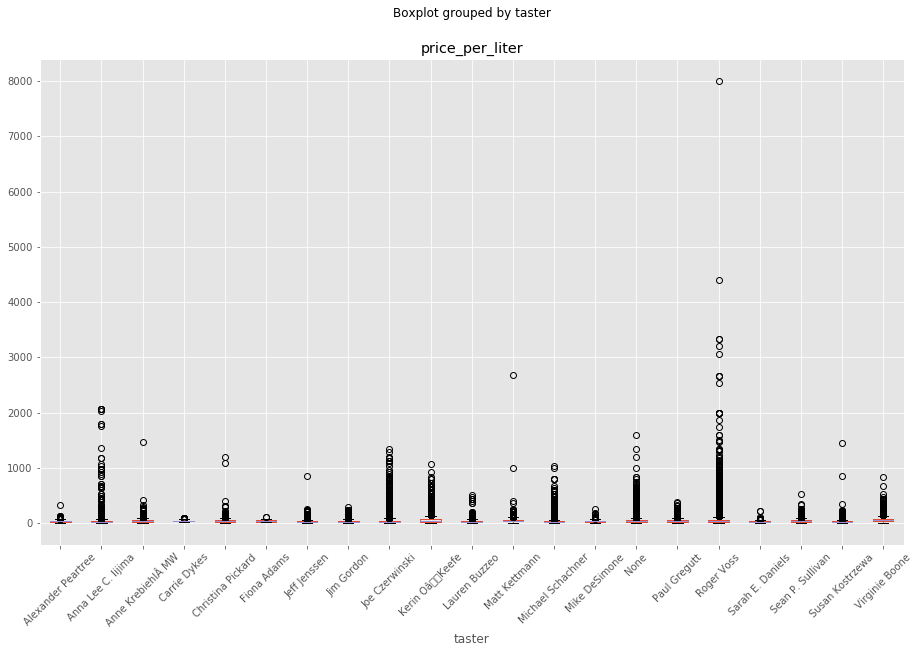

In [24]:
df2.boxplot(column='price_per_liter', by='taster',rot=45)

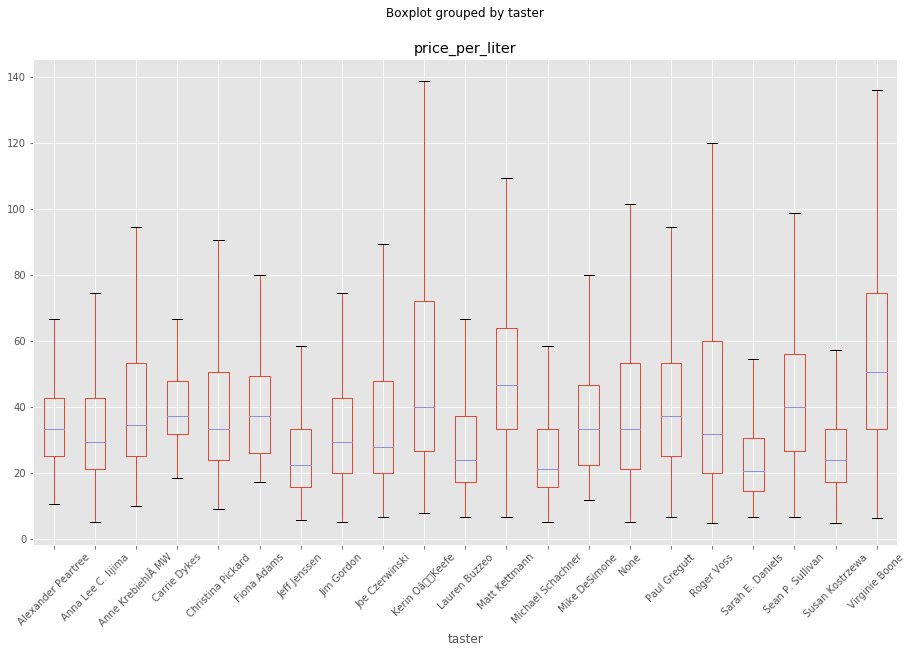

In [25]:
df2.boxplot(column='price_per_liter', by='taster',rot=45, showfliers=False)

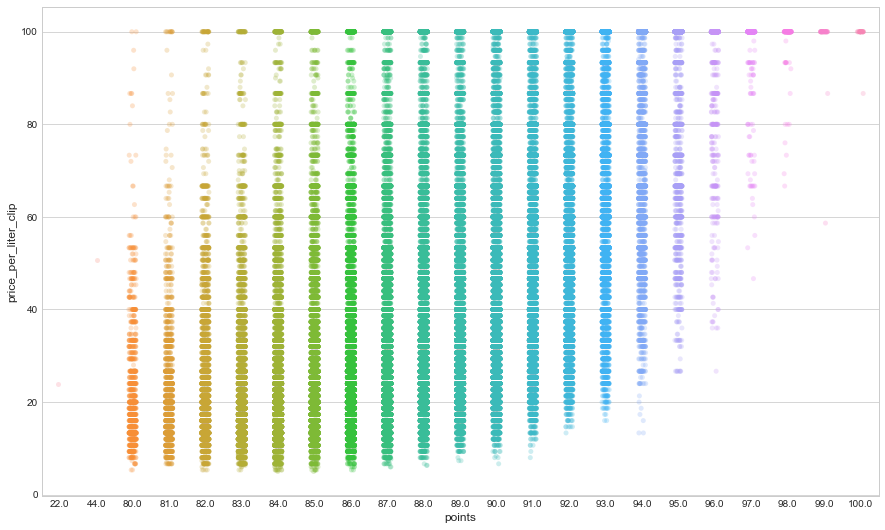

In [26]:
sns.set_style("whitegrid")
ax = sns.stripplot(x='points', y='price_per_liter_clip', jitter=True, data=df2, alpha=.25)

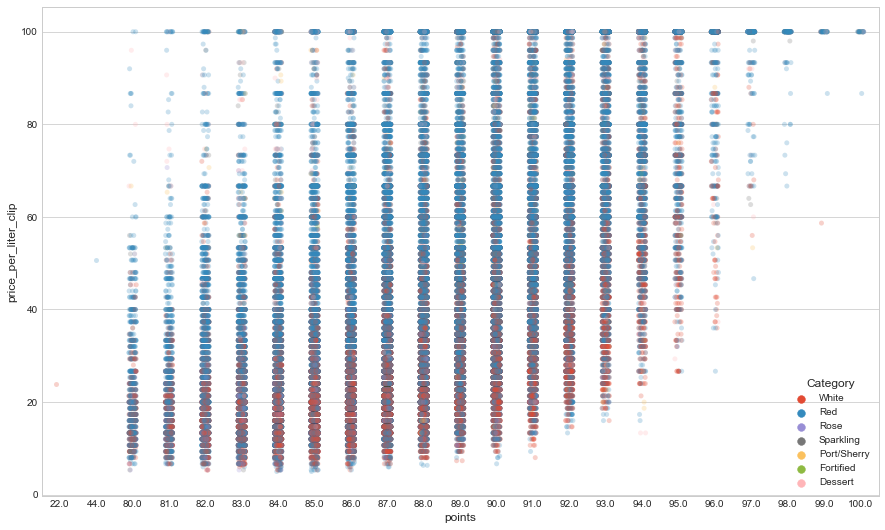

In [27]:
sns.set_style("whitegrid")
ax = sns.stripplot(x='points', y='price_per_liter_clip', hue="Category", data=df2, jitter=True, alpha=.25)

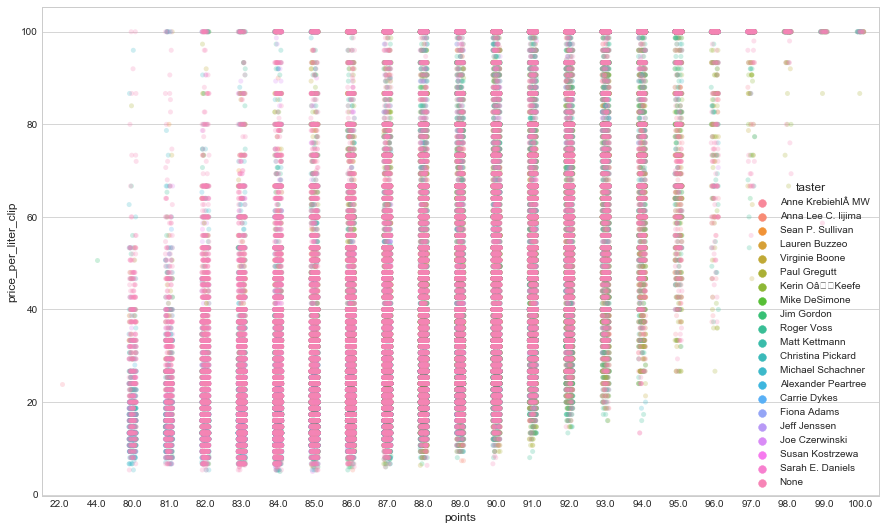

In [28]:
sns.set_style("whitegrid")
ax = sns.stripplot(x='points', y='price_per_liter_clip', hue="taster", data=df2, jitter=1, alpha=.25)

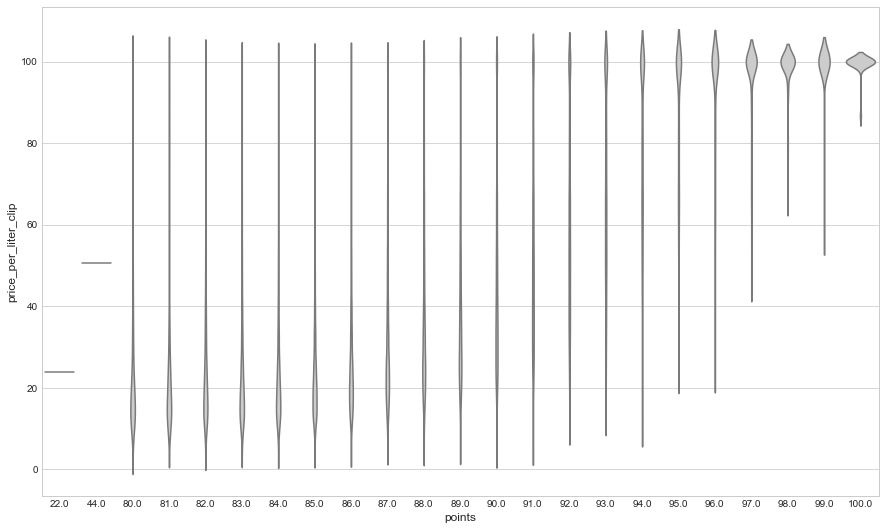

In [29]:
ax = sns.violinplot(x='points', y='price_per_liter_clip', data=df2,inner=None, color=".8")

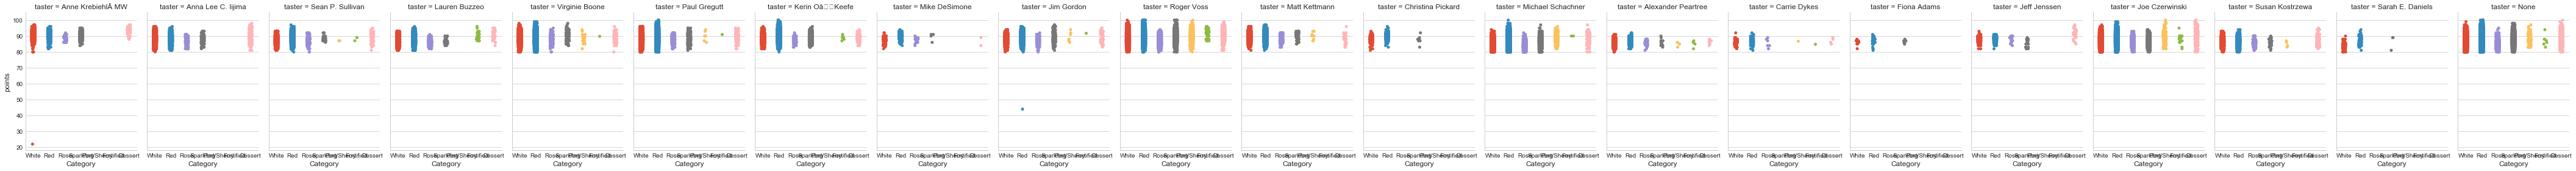

In [30]:
g = sns.factorplot(x="Category", y="points",
                   col="taster",
                   data=df2, kind="strip",
                   jitter=True,
                   size=4, aspect=.7);

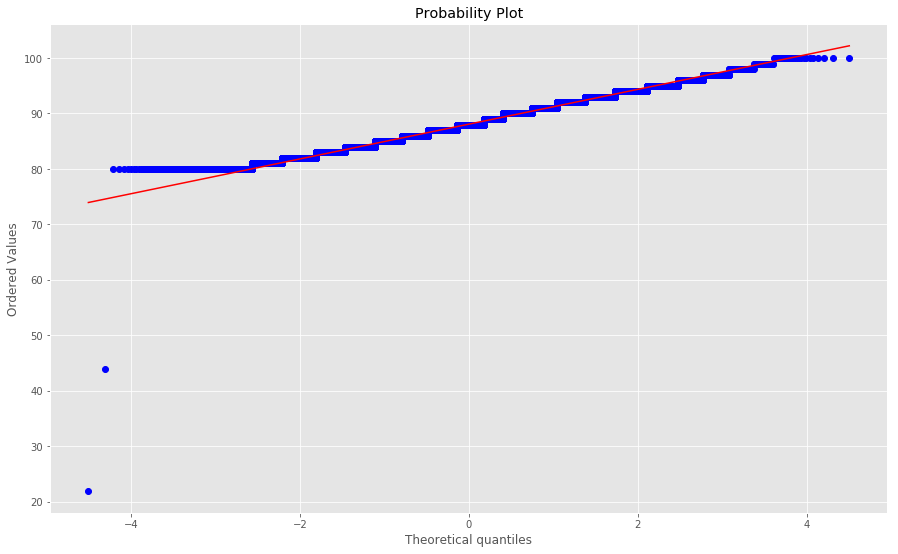

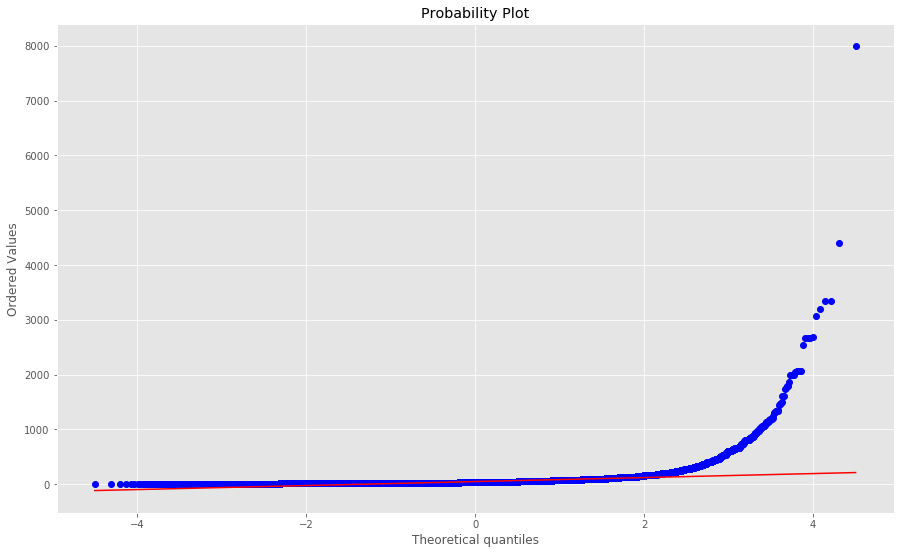

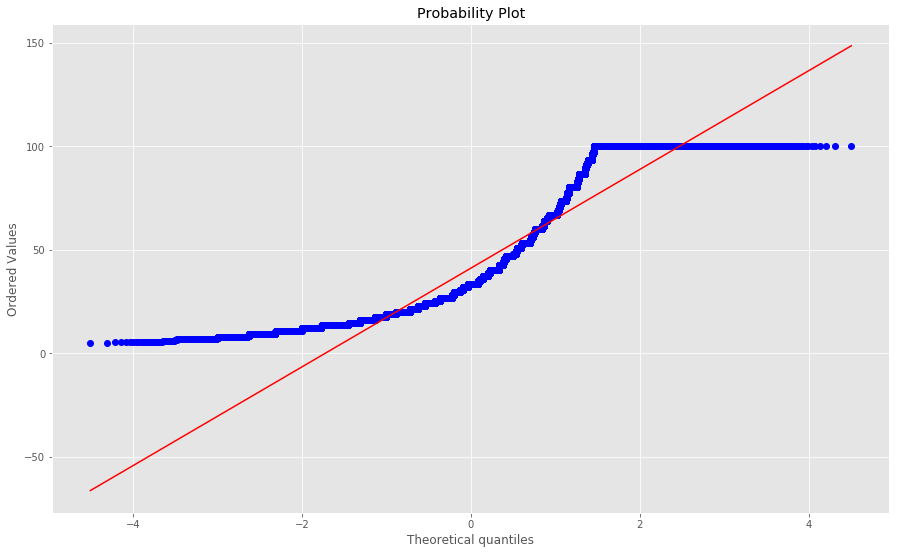

In [13]:
stats.probplot(np.ravel(df2[['points']]), dist="norm", plot=pylab)
pylab.show()
stats.probplot(np.ravel(df2[['price_per_liter']]), dist="norm", plot=pylab)
pylab.show()
stats.probplot(np.ravel(df2[['price_per_liter_clip']]), dist="norm", plot=pylab)
pylab.show()

# Visualize PCA

In [187]:
pca_i = 20
vectorizer = TfidfVectorizer()
#vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
vectorizer.fit(df2.description.tolist())
Tfidf_df = vectorizer.transform(df2.description.tolist())
my_normalizer1 = Normalizer()
my_normalizer1.fit(Tfidf_df)
Tfidf_df = my_normalizer1.transform(Tfidf_df)
svd1 = TruncatedSVD(n_components=pca_i, n_iter=7, random_state=42)
svd1.fit(Tfidf_df)

TruncatedSVD(algorithm='randomized', n_components=20, n_iter=7,
       random_state=42, tol=0.0)

In [201]:
def word_cloud_for_pca(component_i):
    old_component_i = component_i
    component_i = np.flip(np.argsort(svd1.explained_variance_ratio_),0)[component_i]
    
    pca_c_i = svd1.components_[component_i]
    high_indexes = np.where(np.abs(pca_c_i)>.03)
    my_features = vectorizer.get_feature_names()
    my_dic ={}
    for x in high_indexes[0]:
        my_dic[my_features[x]]= math.floor(pca_c_i[x]*1000)
    map_mask = np.array(Image.open("wine2_removed.png"))
    wc = WordCloud(background_color="white", max_words=4000, mask=map_mask)
    wc.generate_from_frequencies(my_dic)
    plt.imshow(wc, interpolation='bilinear')
    variance_explained = round(abs(svd1.explained_variance_ratio_[component_i]) * 100,2)
    plt.title("principal component "+str(old_component_i+1) + " - Variance Explained "+str(variance_explained)+"%")
    plt.axis("off")
    plt.show()

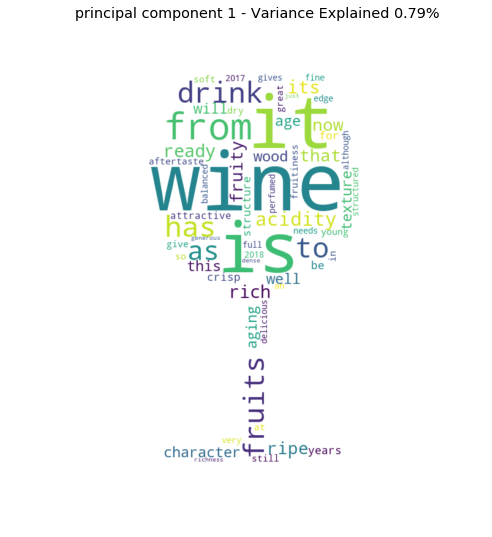

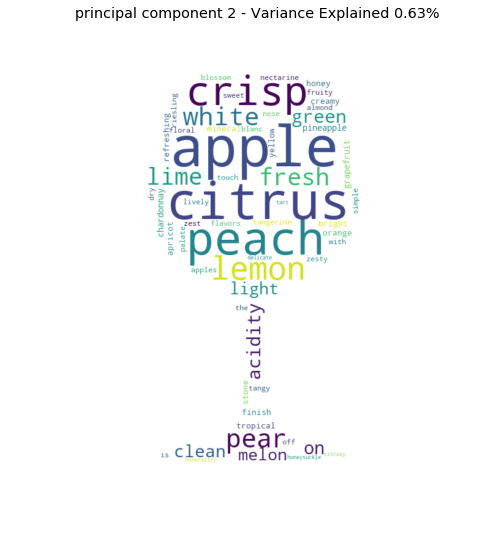

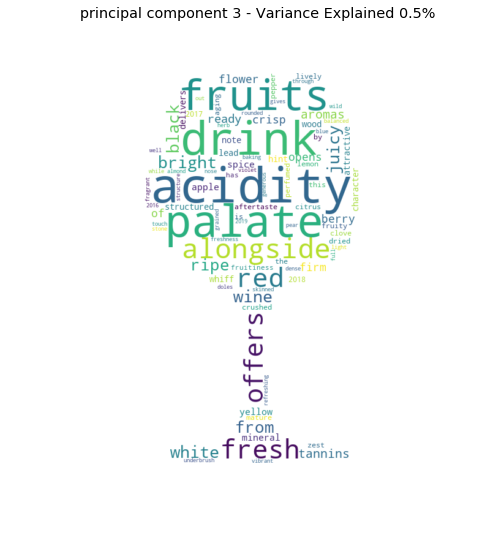

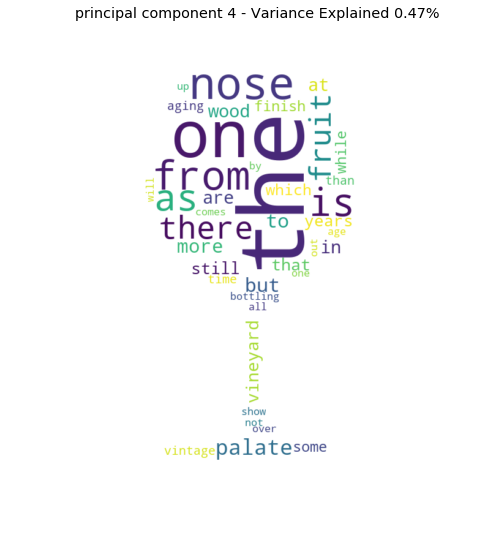

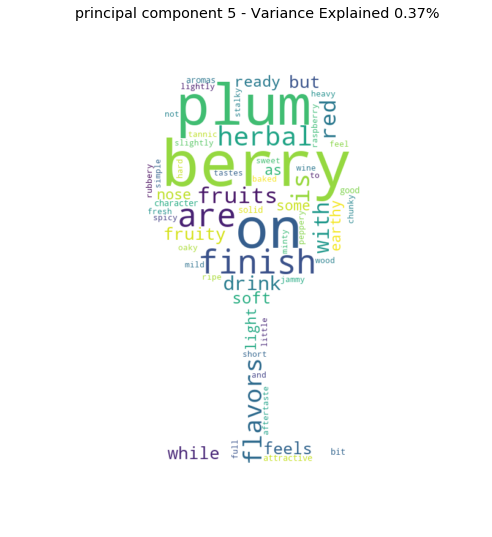

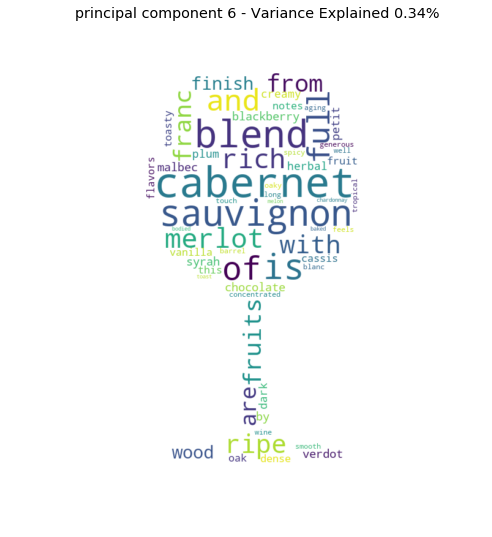

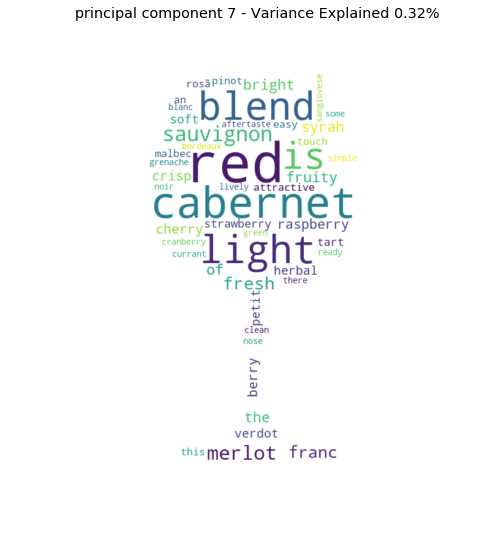

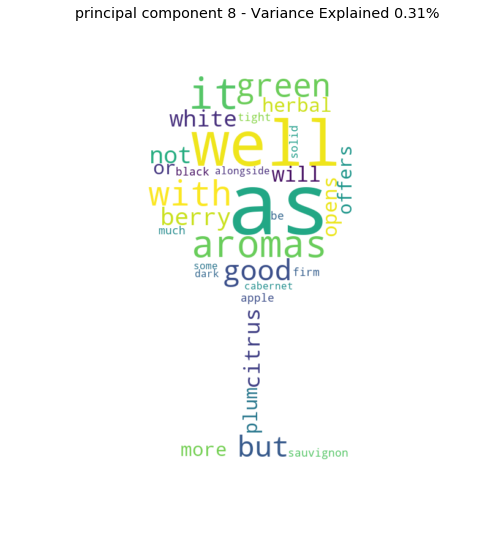

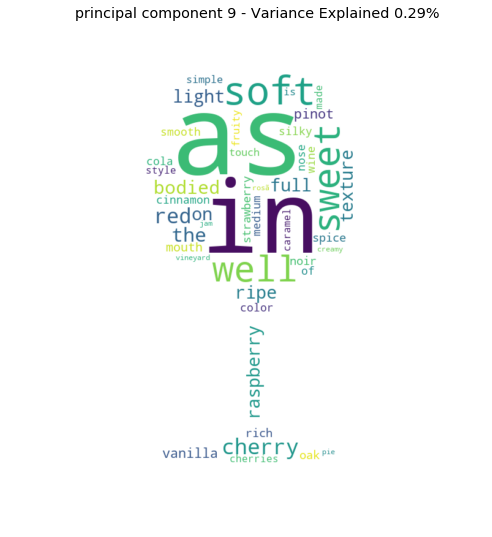

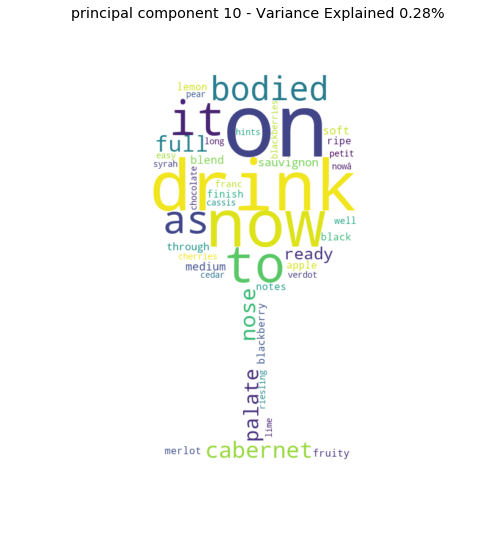

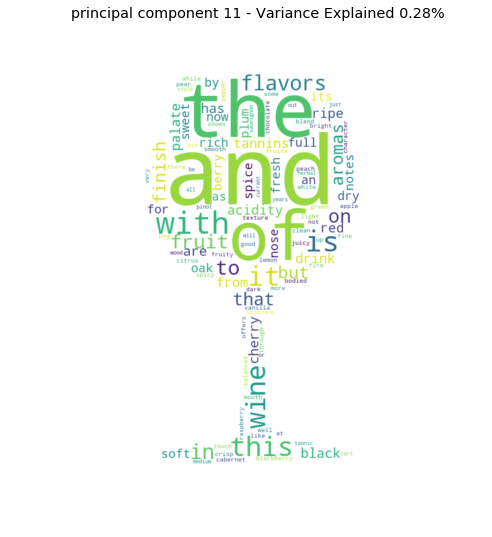

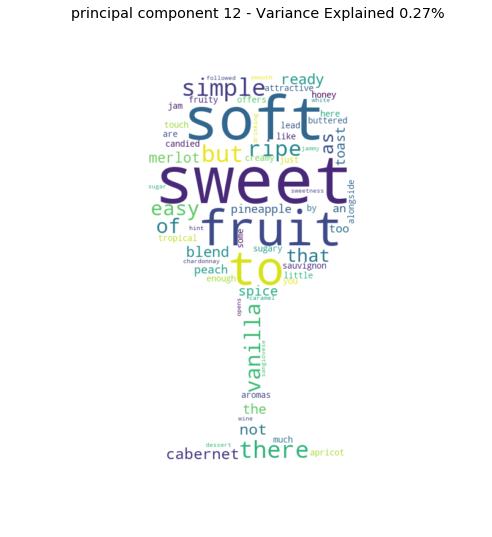

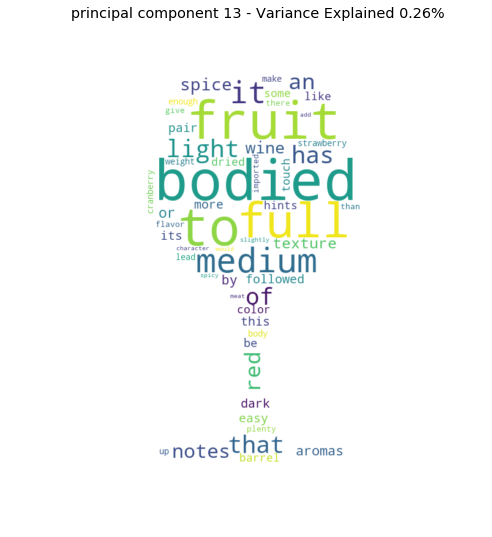

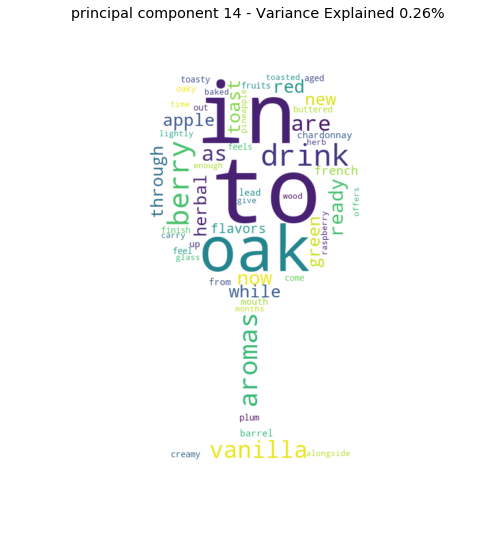

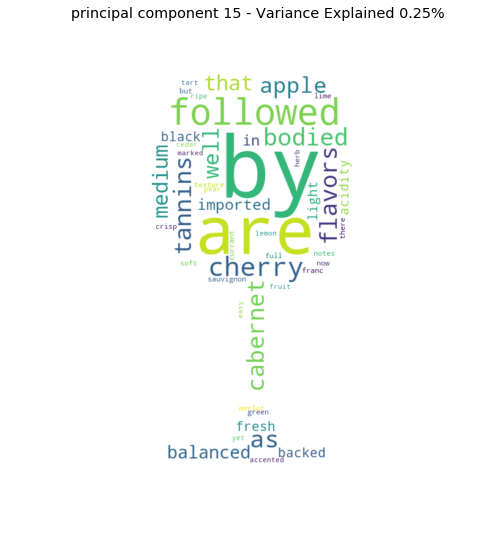

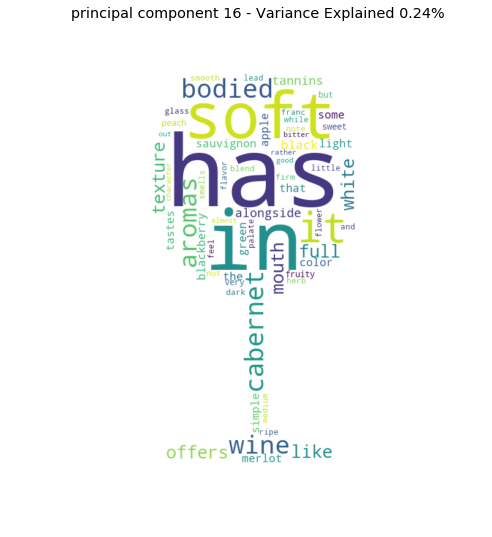

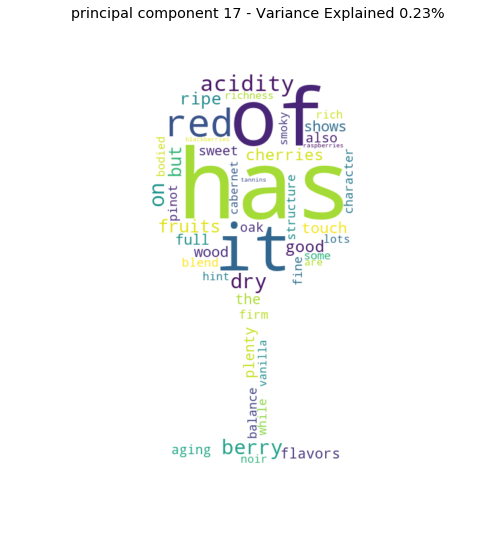

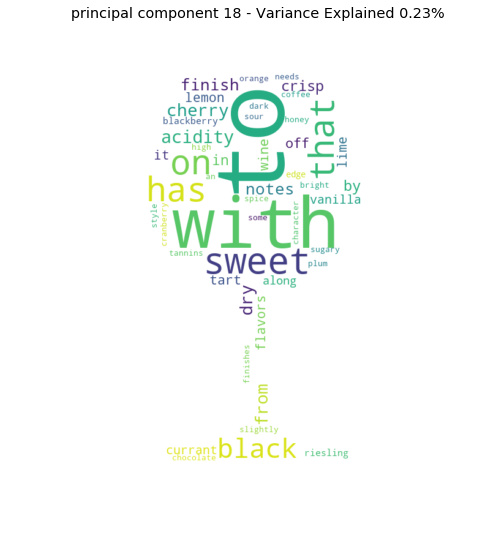

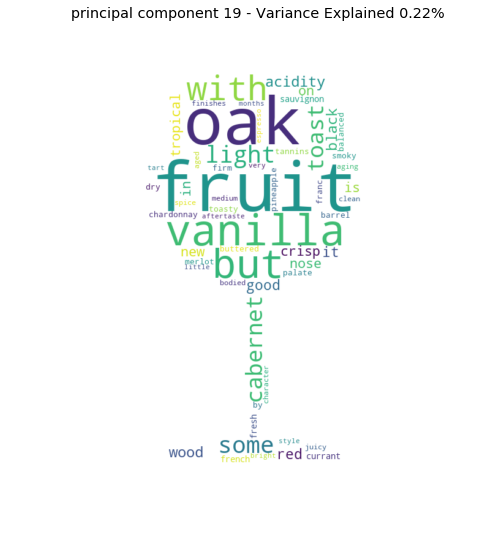

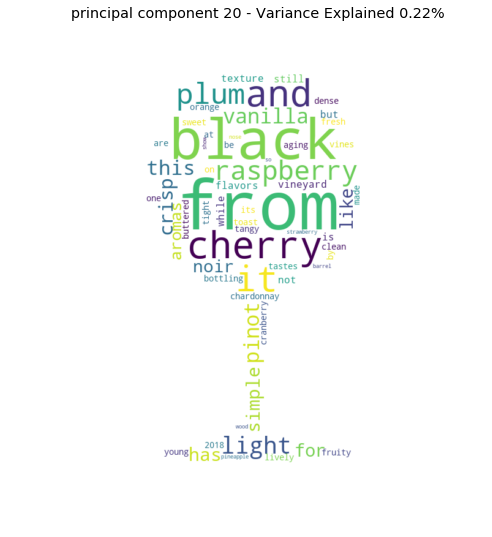

In [202]:
for i in range(0,20):
    word_cloud_for_pca(i)

# Regression on Points

# Function for Spliting the Data for Regression on Points

The code for spliting and transforming the data is placed in a function instead of duplicating the code every where.

In [6]:
def return_model_data_points(train_size, pca_i, input_df, keep_vars, save_tools = False):

    Category_df = pd.get_dummies(input_df[['Category']])
    Category_df = Category_df.drop(Category_df.columns[0], axis=1)
    Category_df = Category_df.reset_index(drop=True)
    l5_df = pd.get_dummies(input_df[['l5']])
    l5_df = l5_df.drop(l5_df.columns[0], axis=1)
    l5_df = l5_df.reset_index(drop=True)
    
    dummy_df = pd.concat([Category_df,l5_df], axis=1)
    
    
    train_test_split_output = train_test_split(input_df, dummy_df,input_df[['points']] , random_state=1, test_size=1-train_size)

    df_train, df_test, dummy_df_train, dummy_df_test, y_train, y_test = train_test_split_output

    vectorizer = TfidfVectorizer()
    #vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
    vectorizer.fit(df_train.description.tolist())

    Tfidf_df_train = vectorizer.transform(df_train.description.tolist())
    Tfidf_df_test = vectorizer.transform(df_test.description.tolist())

    input_df_train = df_train.reset_index(drop=True).copy(deep=True)
    input_df_test = df_test.reset_index(drop=True).copy(deep=True)

    my_normalizer1 = Normalizer()
    my_normalizer1.fit(Tfidf_df_train)

    Tfidf_df_train = my_normalizer1.transform(Tfidf_df_train)
    Tfidf_df_test = my_normalizer1.transform(Tfidf_df_test)

    svd1 = TruncatedSVD(n_components=pca_i, n_iter=7, random_state=42)
    svd1.fit(Tfidf_df_train)

    text_df_train = pd.DataFrame(svd1.transform(Tfidf_df_train))
    text_df_train = text_df_train.reset_index(drop=True)
    text_df_test = pd.DataFrame(svd1.transform(Tfidf_df_test))
    text_df_test = text_df_test.reset_index(drop=True)

    input_df_train = input_df_train.reset_index(drop=True)
    input_df_test = input_df_test.reset_index(drop=True)
    dummy_df_train = dummy_df_train.reset_index(drop=True)
    dummy_df_test = dummy_df_test.reset_index(drop=True)
    text_df_train = text_df_train.reset_index(drop=True)
    text_df_test = text_df_test.reset_index(drop=True)
    
    final_input_train = pd.concat([input_df_train[keep_vars],dummy_df_train,text_df_train], axis=1)
    final_input_test = pd.concat([input_df_test[keep_vars], dummy_df_test,text_df_test], axis=1)

    scaler = StandardScaler()
    scaler.fit(final_input_train)


    XTrain = scaler.transform(final_input_train)
    XTest = scaler.transform(final_input_test)

    return(XTrain, XTest, 
           y_train, y_test)

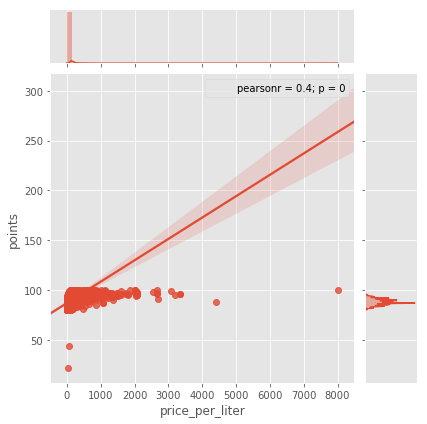

In [14]:
g = sns.jointplot("price_per_liter", "points", data=df2, kind="reg")

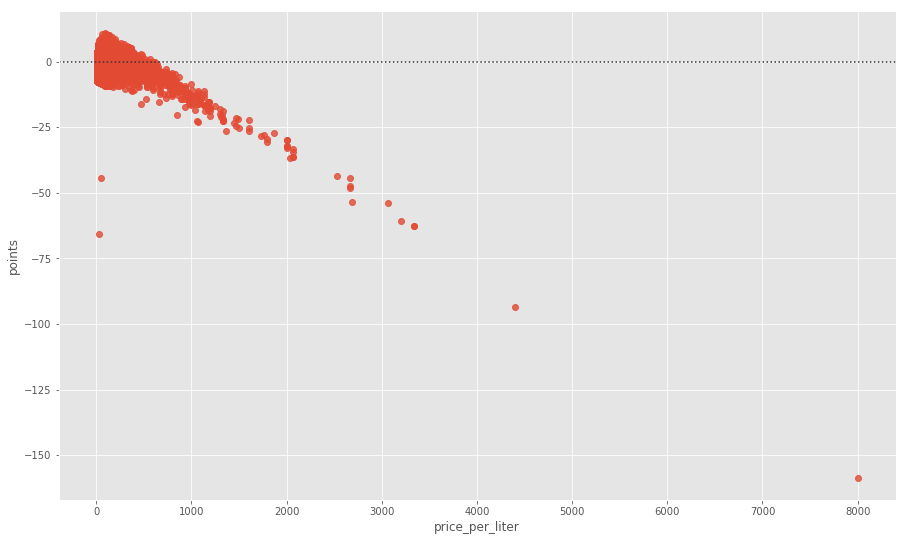

In [15]:
g = sns.residplot("price_per_liter", "points", data=df2)

Going to only use clipped price per liter.

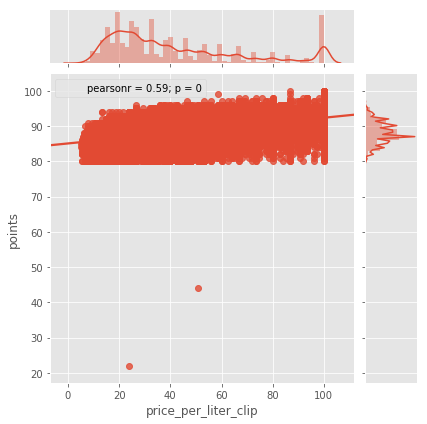

In [16]:
g = sns.jointplot("price_per_liter_clip", "points", data=df2, kind="reg")

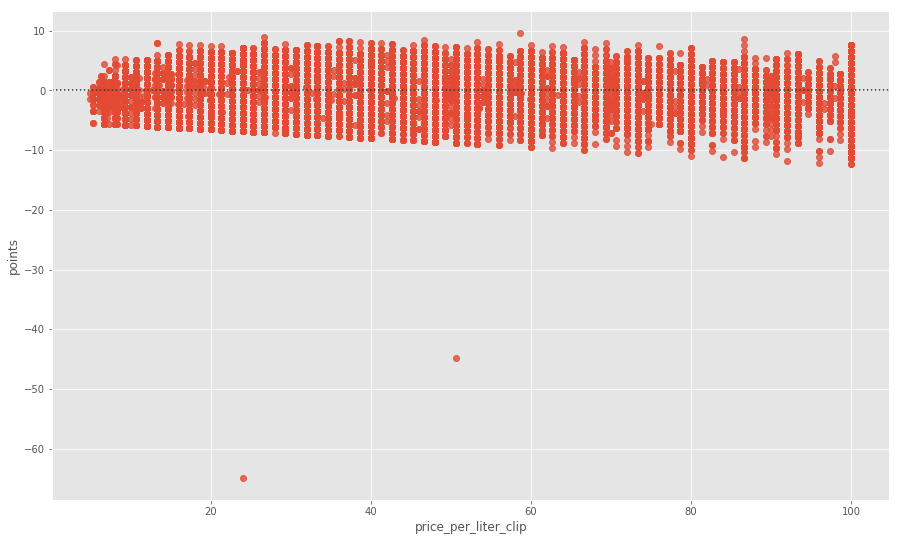

In [17]:
g = sns.residplot("price_per_liter_clip", "points", data=df2)

In [18]:
results = sm.OLS(df2[['points']], df2[["price_per_liter_clip"]]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                 5.969e+05
Date:                Wed, 11 Apr 2018   Prob (F-statistic):               0.00
Time:                        09:39:40   Log-Likelihood:            -1.0966e+06
No. Observations:              209895   AIC:                         2.193e+06
Df Residuals:                  209894   BIC:                         2.193e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
price_per_liter_clip     1.5704 

In [7]:
train_size=.2
pca_i=50
XTrain, XTest, y_train, y_test = return_model_data_points(train_size=train_size, pca_i=pca_i, input_df=df2, keep_vars=['price_per_liter_clip'])

##  LinearRegression

0.2 	 50 	 0.57693157242 	 -9.60578452896e+18


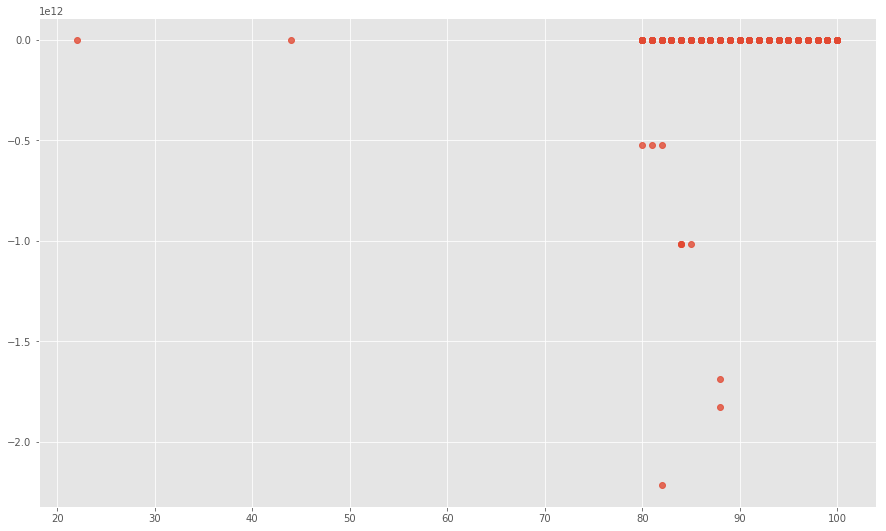

In [8]:

reg = linear_model.LinearRegression()
reg.fit (XTrain, y_train)
y_pred_train = reg.predict(XTrain)
y_pred_test = reg.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
      metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))
sns.regplot(x=y_test, y=y_pred_test, fit_reg=False)
## Something is wrong...

## Ridge

0.1 	 0.2 	 50 	 0.576935992332 	 0.573216499941
0.5 	 0.2 	 50 	 0.576935992272 	 0.573216547326
1.0 	 0.2 	 50 	 0.576935992086 	 0.573216606453
2.0 	 0.2 	 50 	 0.576935991342 	 0.573216724366
5.0 	 0.2 	 50 	 0.576935986135 	 0.573217075359
10.0 	 0.2 	 50 	 0.576935967562 	 0.573217651208
50.0 	 0.2 	 50 	 0.576935377753 	 0.573221848744
100.0 	 0.2 	 50 	 0.5769335556 	 0.57322608157


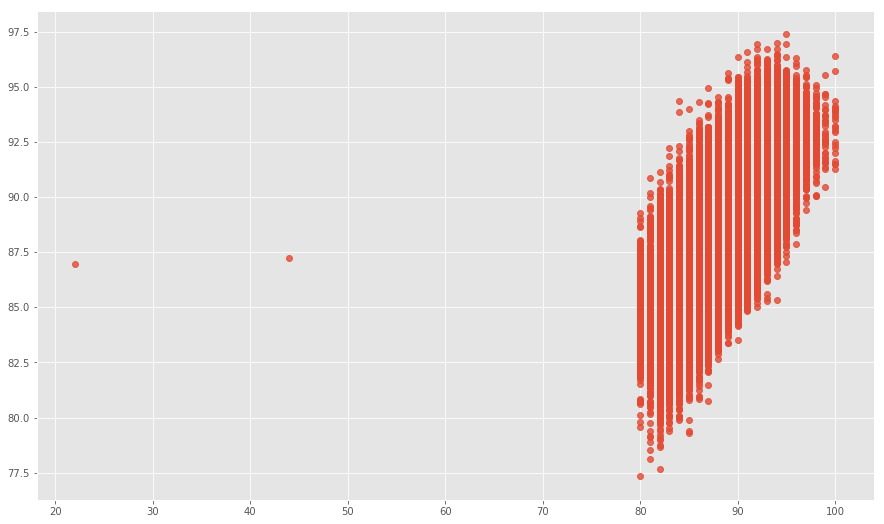

In [10]:

for i in [0.1,0.5,1.0,2.0,5.0,10.0,50.0,100.0]:
    reg = linear_model.Ridge(alpha=i)
    reg.fit (XTrain, y_train)
    y_pred_train = reg.predict(XTrain)
    y_pred_test = reg.predict(XTest)
    print(i,"\t",train_size,"\t",pca_i, "\t",
          metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
          metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))
sns.regplot(x=y_test, y=y_pred_test, fit_reg=False)

## Lasso 

In [12]:
for i in [0.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]:
    reg = linear_model.Lasso(alpha = i)
    reg.fit (XTrain, y_train)
    y_pred_train = reg.predict(XTrain)
    y_pred_test = reg.predict(XTest)
    print(i,"\t",train_size,"\t",pca_i, "\t",
          metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
          metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))

0.01 	 0.2 	 50 	 0.575986066361 	 0.572419294426
0.1 	 0.2 	 50 	 0.534540295045 	 0.532605140083
0.2 	 0.2 	 50 	 0.465400718504 	 0.465050013838
0.3 	 0.2 	 50 	 0.41204104232 	 0.412654827311
0.4 	 0.2 	 50 	 0.375154557165 	 0.375882765836
0.5 	 0.2 	 50 	 0.341375800417 	 0.342083333886
0.6 	 0.2 	 50 	 0.31349541044 	 0.314543717142
0.7 	 0.2 	 50 	 0.296654285517 	 0.297816438112
0.8 	 0.2 	 50 	 0.281645241169 	 0.282813967056
0.9 	 0.2 	 50 	 0.264634990909 	 0.265790100838
1 	 0.2 	 50 	 0.245623534736 	 0.246744839458


## ElasticNet

In [150]:

for i in [0.01,.1,.25,.5,.75,1]:
    for j in [0.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]:
        reg = linear_model.ElasticNet(alpha = i, l1_ratio=j)
        reg.fit (XTrain, y_train)
        y_pred_train = reg.predict(XTrain)
        y_pred_test = reg.predict(XTest)
        print(i,"\t",j,"\t",train_size,"\t",pca_i, "\t",
              metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
              metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))

0.01 	 0.01 	 0.2 	 50 	 0.576893590782 	 0.573227722896
0.01 	 0.1 	 0.2 	 50 	 0.576874012248 	 0.573223273344
0.01 	 0.2 	 0.2 	 50 	 0.576836160716 	 0.573203007261
0.01 	 0.3 	 0.2 	 50 	 0.576782260861 	 0.573166007154
0.01 	 0.4 	 0.2 	 50 	 0.576712866623 	 0.573108505886
0.01 	 0.5 	 0.2 	 50 	 0.57662785092 	 0.573028543715
0.01 	 0.6 	 0.2 	 50 	 0.576527705685 	 0.572931954568
0.01 	 0.7 	 0.2 	 50 	 0.57641349824 	 0.572820674001
0.01 	 0.8 	 0.2 	 50 	 0.576285626182 	 0.572701003893
0.01 	 0.9 	 0.2 	 50 	 0.576143311468 	 0.572567378933
0.01 	 1 	 0.2 	 50 	 0.575986066361 	 0.572419294426
0.1 	 0.01 	 0.2 	 50 	 0.573586766002 	 0.570387746534
0.1 	 0.1 	 0.2 	 50 	 0.572052832199 	 0.568965791389
0.1 	 0.2 	 0.2 	 50 	 0.56953680712 	 0.566557086036
0.1 	 0.3 	 0.2 	 50 	 0.566407192501 	 0.563546449922
0.1 	 0.4 	 0.2 	 50 	 0.562916704795 	 0.560159259596
0.1 	 0.5 	 0.2 	 50 	 0.558935070807 	 0.556339858554
0.1 	 0.6 	 0.2 	 50 	 0.554867769226 	 0.552448793168
0.

## BayesianRidge

0.2 	 50 	 0.576933697755 	 0.57322586024


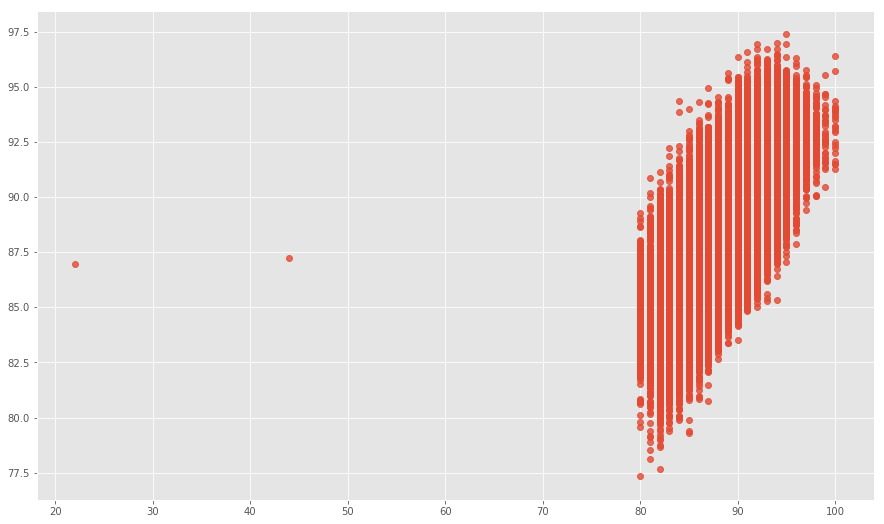

In [13]:

reg = linear_model.BayesianRidge()
reg.fit (XTrain, np.ravel(y_train))
y_pred_train = reg.predict(XTrain)
y_pred_test = reg.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
      metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))
sns.regplot(x=y_test, y=y_pred_test, fit_reg=False)

## Epsilon-Support Vector Regression

0.2 	 50 	 0.70426790027 	 0.656844115156


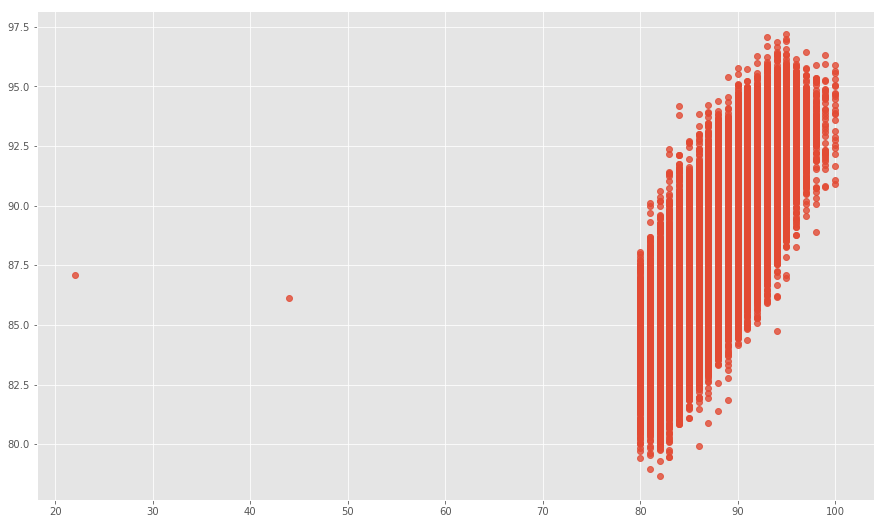

In [14]:

reg = svm.SVR()
reg.fit (XTrain, np.ravel(y_train))
y_pred_train = reg.predict(XTrain)
y_pred_test = reg.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
      metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))
sns.regplot(x=y_test, y=y_pred_test, fit_reg=False)

## KNeighborsRegressor

0.2 	 50 	 0.622527718053 	 0.432821996652


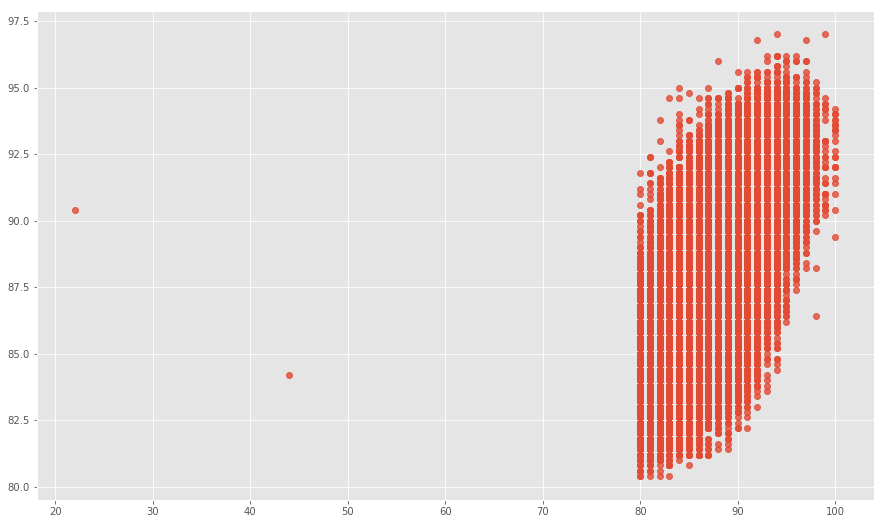

In [15]:

reg = KNeighborsRegressor(n_neighbors=5)
reg.fit (XTrain, np.ravel(y_train))
y_pred_train = reg.predict(XTrain)
y_pred_test = reg.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
      metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))
sns.regplot(x=y_test, y=y_pred_test, fit_reg=False)

## DecisionTreeRegressor

In [16]:
for i  in [1,2,3,4,5,6,7,8,9,10,11,12,13,14]:
    reg = DecisionTreeRegressor(max_depth=i)
    reg.fit (XTrain, np.ravel(y_train))
    y_pred_train = reg.predict(XTrain)
    y_pred_test = reg.predict(XTest)
    print(i,"\t",train_size,"\t",pca_i, "\t",
          metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
          metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))

1 	 0.2 	 50 	 0.251932279139 	 0.249152937977
2 	 0.2 	 50 	 0.341400724192 	 0.338789311876
3 	 0.2 	 50 	 0.373823694253 	 0.367008755166
4 	 0.2 	 50 	 0.408825435999 	 0.398285452377
5 	 0.2 	 50 	 0.436963415561 	 0.418303149015
6 	 0.2 	 50 	 0.464584350532 	 0.435764443706
7 	 0.2 	 50 	 0.492742686219 	 0.444242915314
8 	 0.2 	 50 	 0.524234486312 	 0.445670237202
9 	 0.2 	 50 	 0.561980925478 	 0.434492809543
10 	 0.2 	 50 	 0.606457965345 	 0.410860021444
11 	 0.2 	 50 	 0.659587782819 	 0.376260786637
12 	 0.2 	 50 	 0.716714866706 	 0.328845918328
13 	 0.2 	 50 	 0.773351091464 	 0.2791865206
14 	 0.2 	 50 	 0.825830874601 	 0.23339134123


## ExtraTreesRegressor

1 	 0.2 	 50 	 0.250702831543 	 0.252233909912
2 	 0.2 	 50 	 0.346014760001 	 0.347410376953
3 	 0.2 	 50 	 0.373042889894 	 0.372361558402
4 	 0.2 	 50 	 0.397748125722 	 0.395700369936
5 	 0.2 	 50 	 0.424961996697 	 0.419465378583
6 	 0.2 	 50 	 0.445479095931 	 0.43676927351
7 	 0.2 	 50 	 0.483306877972 	 0.465467119964
8 	 0.2 	 50 	 0.503266109002 	 0.47527392397
9 	 0.2 	 50 	 0.540374549472 	 0.492036931301
10 	 0.2 	 50 	 0.576488451291 	 0.503864514768
11 	 0.2 	 50 	 0.608078529371 	 0.509295065791
12 	 0.2 	 50 	 0.667721131844 	 0.521632938154
13 	 0.2 	 50 	 0.708395080379 	 0.528899576287
14 	 0.2 	 50 	 0.773132969264 	 0.534209436904
15 	 0.2 	 50 	 0.808661634145 	 0.53594828409
16 	 0.2 	 50 	 0.848451699881 	 0.536891977371
17 	 0.2 	 50 	 0.895176520013 	 0.536335558463
18 	 0.2 	 50 	 0.91931308845 	 0.532624971956
19 	 0.2 	 50 	 0.948828666178 	 0.53472422295
20 	 0.2 	 50 	 0.96453404874 	 0.535486473036


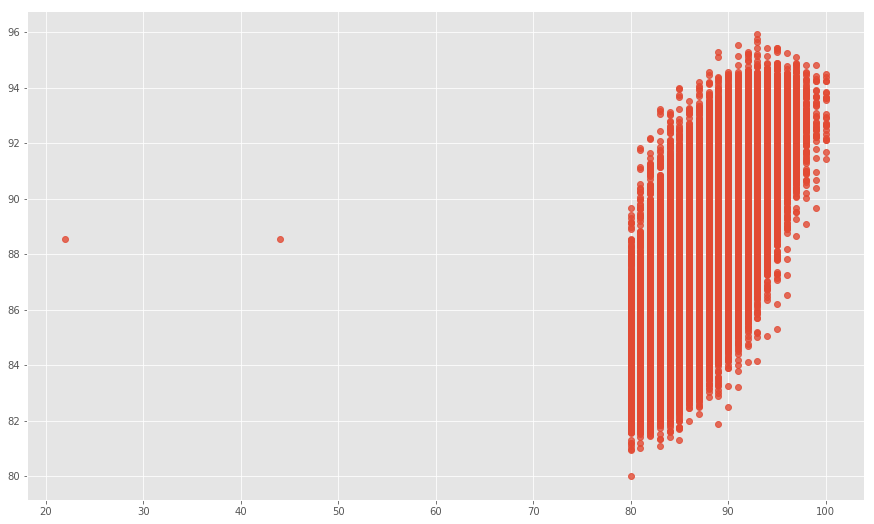

In [17]:
for i  in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
    reg = ExtraTreesRegressor(max_depth=i)
    reg.fit (XTrain, np.ravel(y_train))
    y_pred_train = reg.predict(XTrain)
    y_pred_test = reg.predict(XTest)
    print(i,"\t",train_size,"\t",pca_i, "\t",
          metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
          metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))
sns.regplot(x=y_test, y=y_pred_test, fit_reg=False)

## RandomForestRegressor 

1 	 0.2 	 50 	 0.256239624072 	 0.253624945253
2 	 0.2 	 50 	 0.347948655748 	 0.346043808747
3 	 0.2 	 50 	 0.388934626338 	 0.382918891847
4 	 0.2 	 50 	 0.424056418 	 0.414801134982
5 	 0.2 	 50 	 0.461091626527 	 0.445212117087
6 	 0.2 	 50 	 0.495377842338 	 0.471388787276
7 	 0.2 	 50 	 0.52918087168 	 0.490001754357
8 	 0.2 	 50 	 0.566430208658 	 0.503649795119
9 	 0.2 	 50 	 0.609478815003 	 0.516432159062
10 	 0.2 	 50 	 0.659313456614 	 0.524709348032
11 	 0.2 	 50 	 0.708615397698 	 0.530747357945
12 	 0.2 	 50 	 0.752191917314 	 0.531263426368
13 	 0.2 	 50 	 0.795701892029 	 0.530907021566
14 	 0.2 	 50 	 0.828366796496 	 0.528625600445
15 	 0.2 	 50 	 0.85394667325 	 0.529896731915
16 	 0.2 	 50 	 0.872910575089 	 0.525058322352
17 	 0.2 	 50 	 0.885542811777 	 0.526667821111
18 	 0.2 	 50 	 0.89755475626 	 0.525076414466
19 	 0.2 	 50 	 0.904596780879 	 0.520420874364
20 	 0.2 	 50 	 0.906148294718 	 0.520417852396


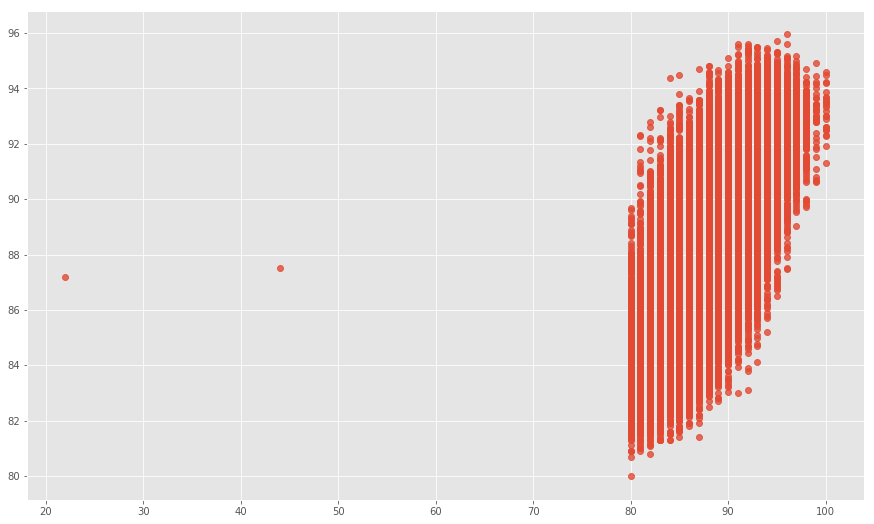

In [18]:
for i  in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
    reg = RandomForestRegressor(max_depth=i)
    reg.fit (XTrain, np.ravel(y_train))
    y_pred_train = reg.predict(XTrain)
    y_pred_test = reg.predict(XTest)
    print(i,"\t",train_size,"\t",pca_i, "\t",
          metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
          metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))
sns.regplot(x=y_test, y=y_pred_test, fit_reg=False)

## BaggingRegressor

0.2 	 50 	 0.912382812037 	 0.521644487498


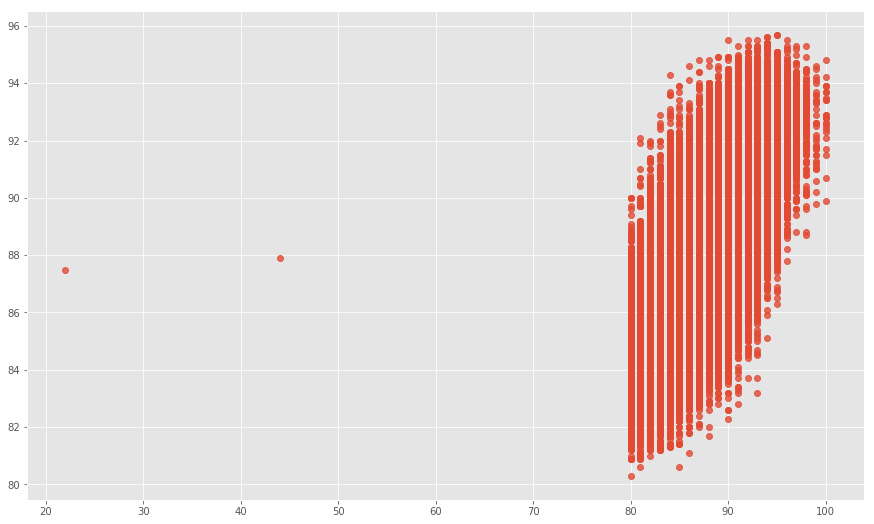

In [19]:

reg = BaggingRegressor()
reg.fit (XTrain, np.ravel(y_train))
y_pred_train = reg.predict(XTrain)
y_pred_test = reg.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
      metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))
sns.regplot(x=y_test, y=y_pred_test, fit_reg=False)

## AdaBoostRegressor

0.2 	 50 	 0.471425117608 	 0.463359709722


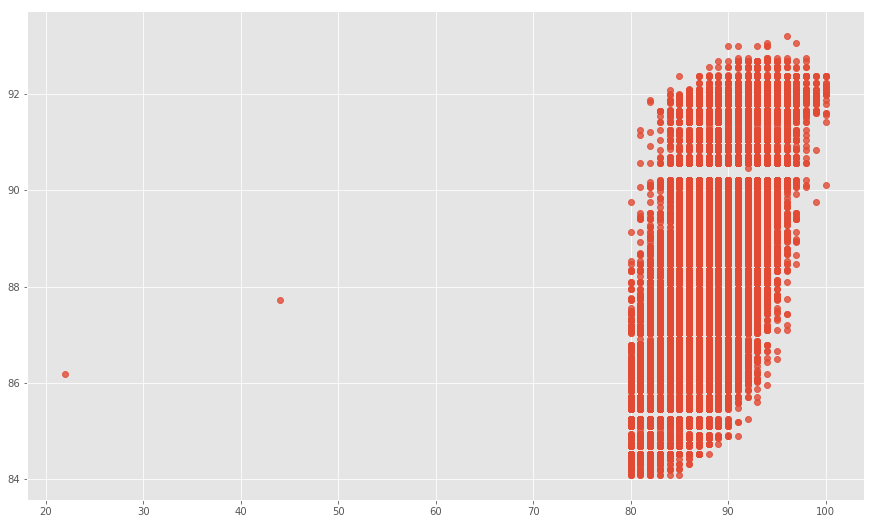

In [20]:

reg = AdaBoostRegressor()
reg.fit (XTrain, np.ravel(y_train))
y_pred_train = reg.predict(XTrain)
y_pred_test = reg.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
      metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))
sns.regplot(x=y_test, y=y_pred_test, fit_reg=False)

## GradientBoostingRegressor

0.2 	 50 	 0.596213044953 	 0.570234555362


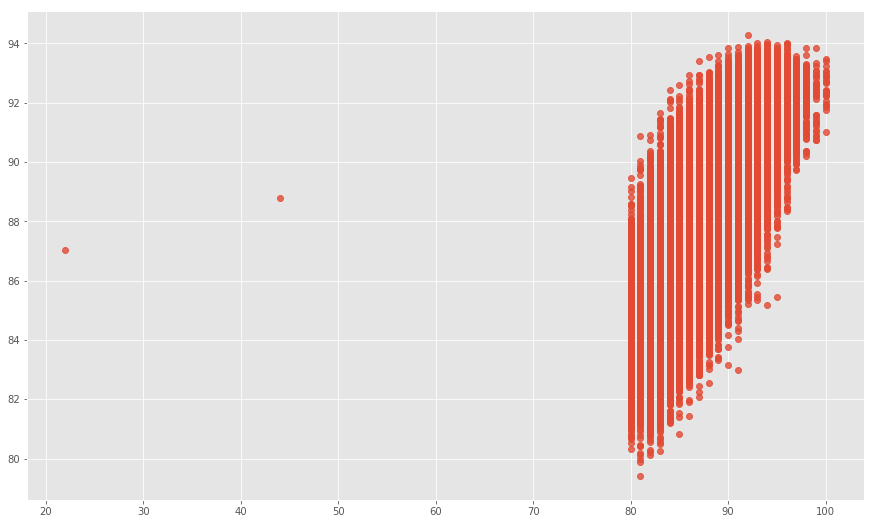

In [21]:

reg = GradientBoostingRegressor()
reg.fit (XTrain, np.ravel(y_train))
y_pred_train = reg.predict(XTrain)
y_pred_test = reg.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
      metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))
sns.regplot(x=y_test, y=y_pred_test, fit_reg=False)

## MLPRegressor

0.2 	 50 	 0.681244331661 	 0.588978218664


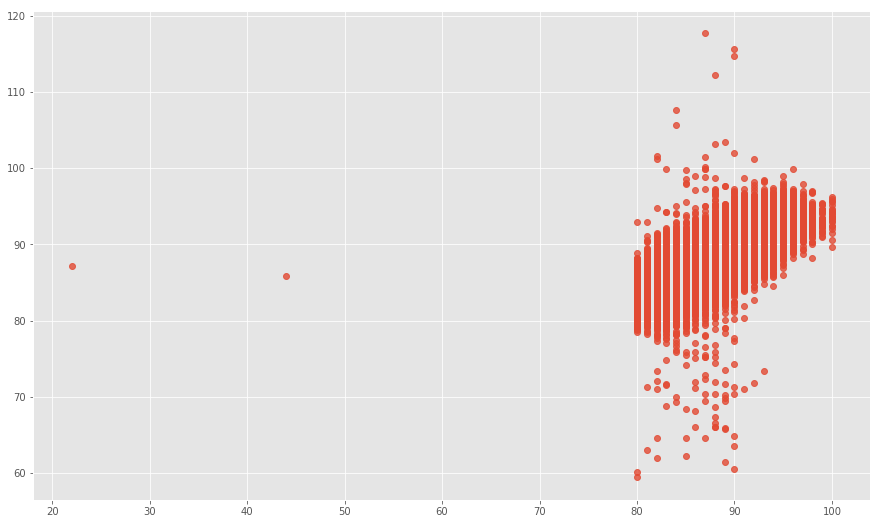

In [22]:

reg = MLPRegressor()
reg.fit (XTrain, np.ravel(y_train))
y_pred_train = reg.predict(XTrain)
y_pred_test = reg.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
      metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))
sns.regplot(x=y_test, y=y_pred_test, fit_reg=False)

## MLPRegressor Scaled

0.2 	 50 	 0.771300238183 	 0.607682357428


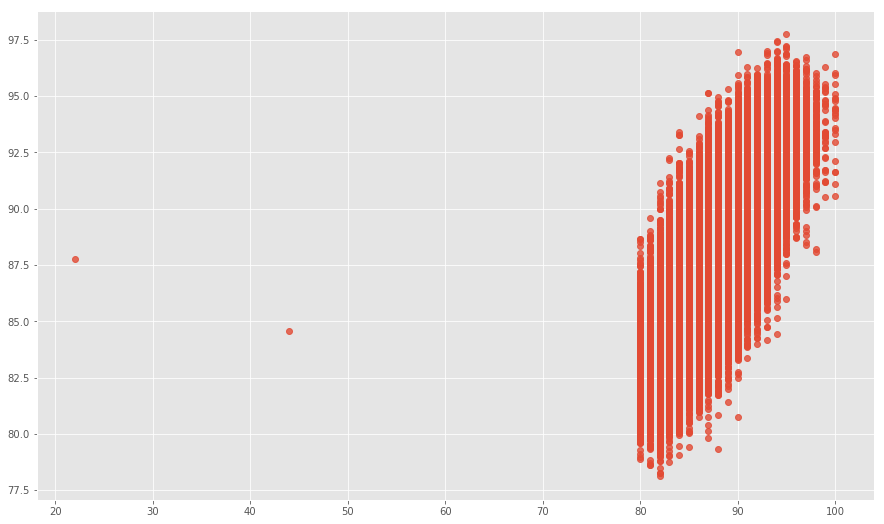

In [23]:
scalery = StandardScaler()
scalery.fit(y_train)

reg = MLPRegressor( activation="logistic")
reg.fit (XTrain, np.ravel(scalery.transform(y_train)))
y_pred_train = scalery.inverse_transform(reg.predict(XTrain))
y_pred_test = scalery.inverse_transform(reg.predict(XTest))
print(train_size,"\t",pca_i, "\t",
      metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
      metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))
sns.regplot(x=y_test, y=y_pred_test, fit_reg=False)

# Create interactive chart

## Must rerun for interactive chart!

In [3]:
%%javascript
// Since I append the div later, sometimes there are multiple divs.
$("#container0").remove();

// Make the cdiv to contain the chart.
element.append('<div id="container0" style="min-width: 310px; height: 400px; margin: 0 auto"></div>');

// Require highcarts and make the chart.
require(['highcharts_exports'], function(Highcharts) {
    $('#container0').highcharts({
        title: {
        text: 'Regression on 20% Train'
    },
        plotOptions: {
            scatter: {
                dataLabels: {
                    format: "{point.name}",
                    enabled: true
                },
                
                enableMouseTracking: false
            }
        },
        
        yAxis: {
        title: {
            text: 'test'
        }
    },xAxis: {
        title: {
            text: 'train'
        }
    },
       
        legend: {
            enabled: false
        },
        series: [{name:'LinearRegression',data:[[0.57693157242,0]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Ridge a-0.1',data:[[0.576935992332,0.573216499941]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Ridge a-0.5',data:[[0.576935992272,0.573216547326]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Ridge a-1',data:[[0.576935992086,0.573216606453]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Ridge a-2',data:[[0.576935991342,0.573216724366]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Ridge a-5',data:[[0.576935986135,0.573217075359]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Ridge a-10',data:[[0.576935967562,0.573217651208]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Ridge a-50',data:[[0.576935377753,0.573221848744]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Ridge a-100',data:[[0.5769335556,0.57322608157]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Lasso a-0.01',data:[[0.575986066361,0.572419294426]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Lasso a-0.1',data:[[0.534540295045,0.532605140083]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Lasso a-0.2',data:[[0.465400718504,0.465050013838]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Lasso a-0.3',data:[[0.41204104232,0.412654827311]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Lasso a-0.4',data:[[0.375154557165,0.375882765836]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Lasso a-0.5',data:[[0.341375800417,0.342083333886]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Lasso a-0.6',data:[[0.31349541044,0.314543717142]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Lasso a-0.7',data:[[0.296654285517,0.297816438112]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Lasso a-0.8',data:[[0.281645241169,0.282813967056]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Lasso a-0.9',data:[[0.264634990909,0.265790100838]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Lasso a-1',data:[[0.245623534736,0.246744839458]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ElasticNet',data:[[0.576893590782,0.573227722896]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'BayesianRidge',data:[[0.576933697755,0.57322586024]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'Epsilon-Support Vector Regression',data:[[0.70426790027,0.656844115156]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'KNeighborsRegressor',data:[[0.622527718053,0.432821996652]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'DecisionTreeRegressor md-1',data:[[0.251932279139,0.249152937977]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'DecisionTreeRegressor md-2',data:[[0.341400724192,0.338789311876]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'DecisionTreeRegressor md-3',data:[[0.373823694253,0.367008755166]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'DecisionTreeRegressor md-4',data:[[0.408825435999,0.398285452377]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'DecisionTreeRegressor md-5',data:[[0.436963415561,0.418303149015]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'DecisionTreeRegressor md-6',data:[[0.464584350532,0.435764443706]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'DecisionTreeRegressor md-7',data:[[0.492742686219,0.444242915314]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'DecisionTreeRegressor md-8',data:[[0.524234486312,0.445643770674]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'DecisionTreeRegressor md-9',data:[[0.561980925478,0.434528450405]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'DecisionTreeRegressor md-10',data:[[0.60646717857,0.409553241429]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'DecisionTreeRegressor md-11',data:[[0.659616755222,0.377614687389]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'DecisionTreeRegressor md-12',data:[[0.716702294151,0.331247997956]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'DecisionTreeRegressor md-13',data:[[0.773246101054,0.282921586019]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'DecisionTreeRegressor md-14',data:[[0.826168052945,0.232335639987]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-1',data:[[0.276218453289,0.277302859305]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-2',data:[[0.334372146946,0.334800958001]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-3',data:[[0.341710864848,0.342158171534]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-4',data:[[0.395177437638,0.393018122047]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-5',data:[[0.418316846897,0.412944158794]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-6',data:[[0.433999979819,0.425637676073]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-7',data:[[0.47331644118,0.457239340214]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-8',data:[[0.503824204823,0.47544996857]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-9',data:[[0.536455051507,0.487497203427]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-10',data:[[0.573390642294,0.502803734809]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-11',data:[[0.614982125512,0.513066632459]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-12',data:[[0.648900220316,0.517159108847]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-13',data:[[0.705539937704,0.525858012936]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-14',data:[[0.75273761587,0.530661565234]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-15',data:[[0.824681855177,0.536727670344]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-16',data:[[0.839869737177,0.534983660466]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-17',data:[[0.880005192681,0.537550346258]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-18',data:[[0.917548922837,0.534934652633]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-19',data:[[0.947038604116,0.535134292795]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ExtraTreesRegressor md-20',data:[[0.961746205899,0.535312367497]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-1',data:[[0.251932190003,0.249150563766]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-2',data:[[0.345690387606,0.343724499419]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-3',data:[[0.385052276977,0.379435051034]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-4',data:[[0.425255082027,0.415273738603]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-5',data:[[0.462670423378,0.446221157983]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-6',data:[[0.493356006109,0.467804473027]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-7',data:[[0.529782851151,0.490420897987]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-8',data:[[0.567668710916,0.505424908231]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-9',data:[[0.611066100862,0.517659696631]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-10',data:[[0.660582133165,0.524881316839]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-11',data:[[0.704588271716,0.527043811798]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-12',data:[[0.751068808656,0.531196757332]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-13',data:[[0.792973665758,0.530265449309]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-14',data:[[0.832133500033,0.527065076469]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-15',data:[[0.852528706076,0.526638200629]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-16',data:[[0.873256080887,0.528913301794]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-17',data:[[0.887194127046,0.524580152187]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-18',data:[[0.897051010579,0.521906266137]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-19',data:[[0.903416142359,0.520207740243]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'RandomForestRegressor md-20',data:[[0.907977793058,0.52126633392]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'BaggingRegressor',data:[[0.913977685751,0.52026010201]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'AdaBoostRegressor',data:[[0.472260117792,0.462546681236]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'GradientBoostingRegressor',data:[[0.596213044953,0.570234555362]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'MLPRegressor',data:[[0.672571071177,0.586911674866]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'MLPRegressor Scaled',data:[[0.774730419101,0.604890555792]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}}]
    });
});


<IPython.core.display.Javascript object>

### SVM does the best across all methods.

## Test different parameters for GradientBoostingRegressor

In [28]:
train_size=.05
pca_i=100
XTrain, XTest, y_train, y_test = return_model_data_points(train_size=train_size, pca_i=pca_i, input_df=df2, keep_vars=['price_per_liter_clip'])

In [10]:
loss_list=['ls','lad','huber','quantile']
learning_rate_list = [0.1,0.15,0.2,.25,.5,.75]
max_depth_list = [1,2,3,4,5,6,7,8,9]
for loss_i in loss_list:
    for learning_rate_i in learning_rate_list:
        for max_depth_i in max_depth_list:
            reg = GradientBoostingRegressor(loss=loss_i,learning_rate=learning_rate_i, max_depth=max_depth_i)
            reg.fit (XTrain, np.ravel(y_train))
            y_pred_train = reg.predict(XTrain)
            y_pred_test = reg.predict(XTest)
            print(loss_i,"\t",learning_rate_i,"\t",max_depth_i,"\t",train_size,"\t",pca_i, "\t",
                  metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
                  metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))

ls 	 0.1 	 1 	 0.05 	 100 	 0.483195481072 	 0.474670631554
ls 	 0.1 	 2 	 0.05 	 100 	 0.573312148488 	 0.542484573263
ls 	 0.1 	 3 	 0.05 	 100 	 0.639864359097 	 0.572574474065
ls 	 0.1 	 4 	 0.05 	 100 	 0.711570113162 	 0.591042550157
ls 	 0.1 	 5 	 0.05 	 100 	 0.788853944671 	 0.597958416133
ls 	 0.1 	 6 	 0.05 	 100 	 0.864170521402 	 0.599622857668
ls 	 0.1 	 7 	 0.05 	 100 	 0.930424766073 	 0.596030158475
ls 	 0.1 	 8 	 0.05 	 100 	 0.968269131224 	 0.587936201096
ls 	 0.1 	 9 	 0.05 	 100 	 0.991099822719 	 0.57738851849
ls 	 0.15 	 1 	 0.05 	 100 	 0.519173600994 	 0.506530808563
ls 	 0.15 	 2 	 0.05 	 100 	 0.606877851635 	 0.564962613525
ls 	 0.15 	 3 	 0.05 	 100 	 0.678489135064 	 0.589166602604
ls 	 0.15 	 4 	 0.05 	 100 	 0.754201228068 	 0.59949633042
ls 	 0.15 	 5 	 0.05 	 100 	 0.830949703617 	 0.601950337646
ls 	 0.15 	 6 	 0.05 	 100 	 0.897615111022 	 0.5980906965
ls 	 0.15 	 7 	 0.05 	 100 	 0.955596525332 	 0.590033544289
ls 	 0.15 	 8 	 0.05 	 100 	 0.983457

huber 	 0.2 	 9 	 0.05 	 100 	 0.991727830882 	 0.554679291695
huber 	 0.25 	 1 	 0.05 	 100 	 0.559720657401 	 0.541083448514
huber 	 0.25 	 2 	 0.05 	 100 	 0.644148356014 	 0.585851345331
huber 	 0.25 	 3 	 0.05 	 100 	 0.717523746548 	 0.598188059469
huber 	 0.25 	 4 	 0.05 	 100 	 0.787801596543 	 0.595209847844
huber 	 0.25 	 5 	 0.05 	 100 	 0.863754625038 	 0.589298549984
huber 	 0.25 	 6 	 0.05 	 100 	 0.921083919934 	 0.579992048102
huber 	 0.25 	 7 	 0.05 	 100 	 0.965034691734 	 0.568629367988
huber 	 0.25 	 8 	 0.05 	 100 	 0.983509172086 	 0.556772124846
huber 	 0.25 	 9 	 0.05 	 100 	 0.993460904396 	 0.541221352857
huber 	 0.5 	 1 	 0.05 	 100 	 0.595676165738 	 0.564154299715
huber 	 0.5 	 2 	 0.05 	 100 	 0.678149425592 	 0.583144684586
huber 	 0.5 	 3 	 0.05 	 100 	 0.758631929306 	 0.575104151827
huber 	 0.5 	 4 	 0.05 	 100 	 0.835414885511 	 0.550314716196
huber 	 0.5 	 5 	 0.05 	 100 	 0.909606389212 	 0.524410034328
huber 	 0.5 	 6 	 0.05 	 100 	 0.963297462163 

# Create interactive chart

## Must rerun for interactive chart!

In [4]:
%%javascript
// Since I append the div later, sometimes there are multiple divs.
$("#container1").remove();

// Make the cdiv to contain the chart.
element.append('<div id="container1" style="min-width: 310px; height: 400px; margin: 0 auto"></div>');

// Require highcarts and make the chart.
require(['highcharts_exports'], function(Highcharts) {
    $('#container1').highcharts({
        title: {
        text: 'GradientBoostingRegressor'
    },
        plotOptions: {
            scatter: {
                dataLabels: {
                    format: "{point.name}",
                    enabled: true
                },
                
                enableMouseTracking: false
            }
        },
        
        yAxis: {
        title: {
            text: 'test'
        }
    },xAxis: {
        title: {
            text: 'train'
        }
    },
       
        legend: {
            enabled: false
        },
        series: [{name:'ls - LR0.1 - MD1',data:[[0.483195481072,0.474670631554]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.1 - MD2',data:[[0.573312148488,0.542484573263]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.1 - MD3',data:[[0.639864359097,0.572574474065]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.1 - MD4',data:[[0.711570113162,0.591042550157]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.1 - MD5',data:[[0.788853944671,0.597958416133]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.1 - MD6',data:[[0.864170521402,0.599622857668]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.1 - MD7',data:[[0.930424766073,0.596030158475]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.1 - MD8',data:[[0.968269131224,0.587936201096]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.1 - MD9',data:[[0.991099822719,0.57738851849]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.15 - MD1',data:[[0.519173600994,0.506530808563]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.15 - MD2',data:[[0.606877851635,0.564962613525]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.15 - MD3',data:[[0.678489135064,0.589166602604]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.15 - MD4',data:[[0.754201228068,0.59949633042]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.15 - MD5',data:[[0.830949703617,0.601950337646]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.15 - MD6',data:[[0.897615111022,0.5980906965]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.15 - MD7',data:[[0.955596525332,0.590033544289]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.15 - MD8',data:[[0.983457954212,0.579793165364]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.15 - MD9',data:[[0.997128038571,0.567213632333]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.2 - MD1',data:[[0.542924522414,0.526893958616]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.2 - MD2',data:[[0.629785050773,0.578424459603]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.2 - MD3',data:[[0.703825126206,0.595344980637]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.2 - MD4',data:[[0.78146733493,0.601375735172]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.2 - MD5',data:[[0.855945803152,0.595180303543]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.2 - MD6',data:[[0.922226987158,0.590351006137]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.2 - MD7',data:[[0.969728483677,0.580146372507]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.2 - MD8',data:[[0.990807379293,0.568193397591]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.2 - MD9',data:[[0.998564304007,0.552465567057]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.25 - MD1',data:[[0.559405555776,0.540754120087]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.25 - MD2',data:[[0.64650911693,0.586309813089]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.25 - MD3',data:[[0.720777611522,0.598429031394]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.25 - MD4',data:[[0.800040485961,0.59607520576]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.25 - MD5',data:[[0.877771541174,0.590470901025]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.25 - MD6',data:[[0.939282385401,0.578703560005]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.25 - MD7',data:[[0.977229088685,0.567272206962]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.25 - MD8',data:[[0.995125947476,0.554312828629]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.25 - MD9',data:[[0.99955848554,0.540051802073]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.5 - MD1',data:[[0.597612520156,0.563577973277]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.5 - MD2',data:[[0.681079881294,0.582230505545]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.5 - MD3',data:[[0.761461322512,0.57405556384]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.5 - MD4',data:[[0.849517402345,0.544959603289]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.5 - MD5',data:[[0.928608187651,0.514958440526]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.5 - MD6',data:[[0.977741120904,0.492438416477]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.5 - MD7',data:[[0.995730500572,0.474708972368]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.5 - MD8',data:[[0.999773201584,0.461162568518]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.5 - MD9',data:[[0.999991519654,0.445805099294]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.75 - MD1',data:[[0.606852019672,0.561684732504]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.75 - MD2',data:[[0.691586078645,0.56485422784]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.75 - MD3',data:[[0.778952150523,0.512579454393]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.75 - MD4',data:[[0.877017801221,0.462789396318]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.75 - MD5',data:[[0.954800912462,0.400535774188]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.75 - MD6',data:[[0.991349439505,0.359251139115]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.75 - MD7',data:[[0.999104622718,0.338249867878]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.75 - MD8',data:[[0.999969242334,0.320387508687]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'ls - LR0.75 - MD9',data:[[0.999999723331,0.309320133057]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'lad - LR0.1 - MD1',data:[[0.470147244234,0.463792116696]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.1 - MD2',data:[[0.552889121664,0.53014259963]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.1 - MD3',data:[[0.61240896779,0.56339443216]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.1 - MD4',data:[[0.660189367638,0.574401693833]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.1 - MD5',data:[[0.708718359382,0.581121909447]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.1 - MD6',data:[[0.753550867917,0.583106521626]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.1 - MD7',data:[[0.79126941866,0.577200902192]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.1 - MD8',data:[[0.827173658816,0.572023240758]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.1 - MD9',data:[[0.86302982277,0.567393604828]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.15 - MD1',data:[[0.50531548943,0.495426880447]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.15 - MD2',data:[[0.584173448482,0.553337009746]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.15 - MD3',data:[[0.638287211259,0.575925501813]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.15 - MD4',data:[[0.686871547205,0.583072692261]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.15 - MD5',data:[[0.731838475214,0.584479040752]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.15 - MD6',data:[[0.777482549972,0.583185647494]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.15 - MD7',data:[[0.815524920058,0.579326200172]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.15 - MD8',data:[[0.8474383006,0.571369892454]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.15 - MD9',data:[[0.875936489803,0.56192039182]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.2 - MD1',data:[[0.526634366283,0.513101736847]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.2 - MD2',data:[[0.601853945648,0.564377943386]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.2 - MD3',data:[[0.657019346919,0.583643442889]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.2 - MD4',data:[[0.699606843876,0.583923832298]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.2 - MD5',data:[[0.746909026349,0.583862672448]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.2 - MD6',data:[[0.784414301077,0.580506250823]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.2 - MD7',data:[[0.825115258714,0.575212067096]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.2 - MD8',data:[[0.855249257636,0.563140362391]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.2 - MD9',data:[[0.887213285797,0.555947943111]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.25 - MD1',data:[[0.544964643176,0.529631214942]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.25 - MD2',data:[[0.614969012229,0.571436672092]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.25 - MD3',data:[[0.666229813029,0.584058564796]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.25 - MD4',data:[[0.711360297902,0.581802582589]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.25 - MD5',data:[[0.752913444559,0.579061446238]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.25 - MD6',data:[[0.784434659618,0.5741186018]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.25 - MD7',data:[[0.824056919477,0.567506882236]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.25 - MD8',data:[[0.861304393256,0.556674638704]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.25 - MD9',data:[[0.886159913456,0.548212034485]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.5 - MD1',data:[[0.541070180523,0.520994250388]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.5 - MD2',data:[[0.647893425537,0.577629536759]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.5 - MD3',data:[[0.688345597803,0.57000271842]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.5 - MD4',data:[[0.733897399816,0.555695882275]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.5 - MD5',data:[[0.769537623812,0.547997992185]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.5 - MD6',data:[[0.807249667709,0.533532324904]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.5 - MD7',data:[[0.835757890632,0.518192532309]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.5 - MD8',data:[[0.87284285622,0.498597683566]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.5 - MD9',data:[[0.896917529415,0.484213472853]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.75 - MD1',data:[[0.596317283023,0.556183736385]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.75 - MD2',data:[[0.652990330282,0.563488121362]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.75 - MD3',data:[[0.698452223812,0.54571542435]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.75 - MD4',data:[[0.731143277028,0.512059059729]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.75 - MD5',data:[[0.782148045705,0.486256502673]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.75 - MD6',data:[[0.811386651861,0.45511620425]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.75 - MD7',data:[[0.843396315063,0.439166826033]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.75 - MD8',data:[[0.879474561023,0.412184112483]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'lad - LR0.75 - MD9',data:[[0.897729340138,0.390995879317]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'huber - LR0.1 - MD1',data:[[0.484702820443,0.476256697828]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.1 - MD2',data:[[0.572787279837,0.543573328207]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.1 - MD3',data:[[0.636429581541,0.572089154825]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.1 - MD4',data:[[0.705626481701,0.58987898467]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.1 - MD5',data:[[0.782201997196,0.597765022006]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.1 - MD6',data:[[0.852819556298,0.598969575974]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.1 - MD7',data:[[0.914158427534,0.595389577059]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.1 - MD8',data:[[0.955300038064,0.586869064995]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.1 - MD9',data:[[0.980411857223,0.577367233848]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.15 - MD1',data:[[0.519941627966,0.507897862138]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.15 - MD2',data:[[0.607327118468,0.566325242824]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.15 - MD3',data:[[0.676699207771,0.589211731403]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.15 - MD4',data:[[0.746618168939,0.59665550598]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.15 - MD5',data:[[0.821272306105,0.60081752492]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.15 - MD6',data:[[0.885438298961,0.59769842929]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.15 - MD7',data:[[0.937023503168,0.590278029409]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.15 - MD8',data:[[0.970426747868,0.581065009216]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.15 - MD9',data:[[0.986964960927,0.566564430631]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.2 - MD1',data:[[0.54256712556,0.528182412243]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.2 - MD2',data:[[0.628663643289,0.578246036712]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.2 - MD3',data:[[0.699652365591,0.596663826998]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.2 - MD4',data:[[0.770187654079,0.598169269974]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.2 - MD5',data:[[0.844262425768,0.596027464119]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.2 - MD6',data:[[0.905089969876,0.589218799269]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.2 - MD7',data:[[0.954889724486,0.579975597426]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.2 - MD8',data:[[0.979431370891,0.567294999257]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.2 - MD9',data:[[0.991727830882,0.554679291695]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.25 - MD1',data:[[0.559720657401,0.541083448514]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.25 - MD2',data:[[0.644148356014,0.585851345331]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.25 - MD3',data:[[0.717523746548,0.598188059469]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.25 - MD4',data:[[0.787801596543,0.595209847844]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.25 - MD5',data:[[0.863754625038,0.589298549984]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.25 - MD6',data:[[0.921083919934,0.579992048102]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.25 - MD7',data:[[0.965034691734,0.568629367988]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.25 - MD8',data:[[0.983509172086,0.556772124846]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.25 - MD9',data:[[0.993460904396,0.541221352857]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.5 - MD1',data:[[0.595676165738,0.564154299715]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.5 - MD2',data:[[0.678149425592,0.583144684586]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.5 - MD3',data:[[0.758631929306,0.575104151827]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.5 - MD4',data:[[0.835414885511,0.550314716196]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.5 - MD5',data:[[0.909606389212,0.524410034328]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.5 - MD6',data:[[0.963297462163,0.502234861715]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.5 - MD7',data:[[0.984285631928,0.484700504454]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.5 - MD8',data:[[0.992078885691,0.47157913527]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.5 - MD9',data:[[0.996951070307,0.45165522074]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.75 - MD1',data:[[0.606945820357,0.559035997392]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.75 - MD2',data:[[0.689569079414,0.558096043278]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.75 - MD3',data:[[0.774867188469,0.520734366421]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.75 - MD4',data:[[0.859730039591,0.46570304241]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.75 - MD5',data:[[0.936316030797,0.410348470649]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.75 - MD6',data:[[0.977501177396,0.381674699951]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.75 - MD7',data:[[0.987516730978,0.365960005809]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.75 - MD8',data:[[0.992953428422,0.344039423157]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'huber - LR0.75 - MD9',data:[[0.997207734394,0.320933042798]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'quantile - LR0.1 - MD1',data:[[0.423238318883,0.424403863531]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.1 - MD2',data:[[0.497303156164,0.484234218165]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.1 - MD3',data:[[0.533069482006,0.507447726265]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.1 - MD4',data:[[0.55817468672,0.516466130494]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.1 - MD5',data:[[0.57573691731,0.517066136644]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.1 - MD6',data:[[0.587564188439,0.512729279197]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.1 - MD7',data:[[0.593097890283,0.501817690723]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.1 - MD8',data:[[0.610329728067,0.500073852524]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.1 - MD9',data:[[0.608361601864,0.487795052256]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.15 - MD1',data:[[0.45620187398,0.454324648218]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.15 - MD2',data:[[0.520808531602,0.502712682075]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.15 - MD3',data:[[0.556432890711,0.52328556955]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.15 - MD4',data:[[0.575624901586,0.524978122751]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.15 - MD5',data:[[0.589029428191,0.52458893886]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.15 - MD6',data:[[0.601383893006,0.517931405175]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.15 - MD7',data:[[0.620786448514,0.515524550746]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.15 - MD8',data:[[0.623015806904,0.502629595446]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.15 - MD9',data:[[0.62340850872,0.491110477043]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.2 - MD1',data:[[0.476672151201,0.471948670592]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.2 - MD2',data:[[0.537850554478,0.514182800628]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.2 - MD3',data:[[0.561246711192,0.524261876705]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.2 - MD4',data:[[0.593101129083,0.533834121163]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.2 - MD5',data:[[0.605721657923,0.530259911835]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.2 - MD6',data:[[0.616357172131,0.524147428767]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.2 - MD7',data:[[0.627130242245,0.516334188837]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.2 - MD8',data:[[0.64259263376,0.510422616685]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.2 - MD9',data:[[0.645490438547,0.501146966844]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.25 - MD1',data:[[0.491012773207,0.485374274742]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.25 - MD2',data:[[0.54531751435,0.519866482481]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.25 - MD3',data:[[0.575786948041,0.532538708395]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.25 - MD4',data:[[0.597126659958,0.530261221923]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.25 - MD5',data:[[0.605907437887,0.528458734123]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.25 - MD6',data:[[0.628726805734,0.52590127478]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.25 - MD7',data:[[0.639785679312,0.519928756854]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.25 - MD8',data:[[0.638370522989,0.504382082233]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.25 - MD9',data:[[0.654651683521,0.498127846258]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.5 - MD1',data:[[0.532728180733,0.517173859921]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.5 - MD2',data:[[0.55852769516,0.522711256208]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.5 - MD3',data:[[0.58673388658,0.524853661187]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.5 - MD4',data:[[0.619461519386,0.523341562462]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.5 - MD5',data:[[0.630153104742,0.526933204881]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.5 - MD6',data:[[0.637763280962,0.519793379464]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.5 - MD7',data:[[0.649569346495,0.500441390607]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.5 - MD8',data:[[0.662254206386,0.486503893056]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.5 - MD9',data:[[0.664303147619,0.48152678482]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.75 - MD1',data:[[0.53723249853,0.517791488697]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.75 - MD2',data:[[0.568583975795,0.517445645223]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.75 - MD3',data:[[0.585558293366,0.509988370252]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.75 - MD4',data:[[0.598506842354,0.49850085886]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.75 - MD5',data:[[0.618357956888,0.492355617663]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.75 - MD6',data:[[0.622885058303,0.474975221008]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.75 - MD7',data:[[0.656488202042,0.473372144055]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.75 - MD8',data:[[0.660201407577,0.451091621879]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'quantile - LR0.75 - MD9',data:[[0.672359070201,0.445650099879]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}}]
    });
});


<IPython.core.display.Javascript object>

### A lot of different parameters give the same test score.

In [29]:
reg = GradientBoostingRegressor()
reg.fit (XTrain, np.ravel(y_train))
y_pred_train = reg.predict(XTrain)
y_pred_test = reg.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
      metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))

0.05 	 100 	 0.639864359097 	 0.572575631533


## Test different parameters for MLPRegressor

In [30]:
scalery = StandardScaler()
scalery.fit(y_train)
activation_list= ["identity","logistic","tanh","relu"]
solver_list = ['lbfgs','sgd','adam']
for activation_i in activation_list:
    for solver_i in solver_list:
        reg = MLPRegressor( activation=activation_i,solver=solver_i)
        reg.fit (XTrain, np.ravel(scalery.transform(y_train)))
        y_pred_train = scalery.inverse_transform(reg.predict(XTrain))
        y_pred_test = scalery.inverse_transform(reg.predict(XTest))
        print(activation_i,"\t",solver_i,"\t",train_size,"\t",pca_i, "\t",
              metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
              metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))

identity 	 lbfgs 	 0.05 	 100 	 0.607154096275 	 0.600211284445
identity 	 sgd 	 0.05 	 100 	 0.606660310127 	 0.599485790112
identity 	 adam 	 0.05 	 100 	 0.570139742024 	 0.564111497658
logistic 	 lbfgs 	 0.05 	 100 	 0.909963398761 	 0.459365415587
logistic 	 sgd 	 0.05 	 100 	 0.610245249329 	 0.60308284211


C:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic 	 adam 	 0.05 	 100 	 0.981950120395 	 0.400868557658
tanh 	 lbfgs 	 0.05 	 100 	 0.990816806993 	 0.0976663334808
tanh 	 sgd 	 0.05 	 100 	 0.6966214225 	 0.58945632735
tanh 	 adam 	 0.05 	 100 	 0.991294687258 	 0.159512907298
relu 	 lbfgs 	 0.05 	 100 	 0.937123552089 	 0.367925087958
relu 	 sgd 	 0.05 	 100 	 0.732436830781 	 0.604889248315
relu 	 adam 	 0.05 	 100 	 0.83767932459 	 0.557892075499


# Create interactive chart

## Must rerun for interactive chart!

In [5]:
%%javascript
// Since I append the div later, sometimes there are multiple divs.
$("#container2").remove();

// Make the cdiv to contain the chart.
element.append('<div id="container2" style="min-width: 310px; height: 400px; margin: 0 auto"></div>');

// Require highcarts and make the chart.
require(['highcharts_exports'], function(Highcharts) {
    $('#container2').highcharts({
         title: {
        text: 'MLPRegressor'
    },
        plotOptions: {
            scatter: {
                dataLabels: {
                    format: "{point.name}",
                    enabled: true
                },
                
                enableMouseTracking: false
            }
        },
        
        yAxis: {
        title: {
            text: 'test'
        }
    },xAxis: {
        title: {
            text: 'train'
        }
    },
       
        legend: {
            enabled: false
        },
        series: [{name:'identity - lbfgs ',data:[[0.607154096275,0.600211284445]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'identity - sgd ',data:[[0.606660310127,0.599485790112]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'identity - adam ',data:[[0.570139742024,0.564111497658]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'logistic - lbfgs ',data:[[0.909963398761,0.459365415587]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'logistic - sgd ',data:[[0.610245249329,0.60308284211]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'logistic - adam ',data:[[0.981950120395,0.400868557658]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'tanh - lbfgs ',data:[[0.990816806993,0.0976663334808]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'tanh - sgd ',data:[[0.6966214225,0.58945632735]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'tanh - adam ',data:[[0.991294687258,0.159512907298]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'relu - lbfgs ',data:[[0.937123552089,0.367925087958]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'relu - sgd ',data:[[0.732436830781,0.604889248315]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'relu - adam ',data:[[0.83767932459,0.557892075499]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}}]
    });
});


<IPython.core.display.Javascript object>

### sgd seems to do the best.

In [31]:
scalery = StandardScaler()
scalery.fit(y_train)
reg = MLPRegressor( )
reg.fit (XTrain, np.ravel(scalery.transform(y_train)))
y_pred_train = scalery.inverse_transform(reg.predict(XTrain))
y_pred_test = scalery.inverse_transform(reg.predict(XTest))
print(train_size,"\t",pca_i, "\t",
      metrics.explained_variance_score(y_true = y_train, y_pred = y_pred_train),"\t",
      metrics.explained_variance_score(y_true = y_test, y_pred = y_pred_test))

0.05 	 100 	 0.885264661927 	 0.514486819843


## Custom Neural Network Points

In [38]:
from sklearn.preprocessing import MinMaxScaler
def return_model_data_points(train_size, pca_i, input_df, keep_vars, save_tools = False):
    taster_df = pd.get_dummies(input_df[['taster']])
    taster_df = taster_df.drop(taster_df.columns[0], axis=1)
    taster_df = taster_df.reset_index(drop=True)
    Category_df = pd.get_dummies(input_df[['Category']])
    Category_df = Category_df.drop(Category_df.columns[0], axis=1)
    Category_df = Category_df.reset_index(drop=True)
    l5_df = pd.get_dummies(input_df[['l5']])
    l5_df = l5_df.drop(l5_df.columns[0], axis=1)
    l5_df = l5_df.reset_index(drop=True)
    
    dummy_df = pd.concat([taster_df,Category_df,l5_df], axis=1)


    
    train_test_split_output = train_test_split(input_df, dummy_df, input_df[['points']] , random_state=1, test_size=1-train_size)

    df_train, df_test, dummy_df_train, dummy_df_test, y1_train, y1_test = train_test_split_output

    scaler_points = MinMaxScaler(feature_range=(0.01, .99))
    scaler_points.fit(y1_train)
    if save_tools:
        joblib.dump(scaler_points, 'scaler_points.pkl')
    y1_train_s = scaler_points.transform(y1_train)
    y1_test_s = scaler_points.transform(y1_test)
    
    
    vectorizer = TfidfVectorizer()
    #vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
    vectorizer.fit(df_train.description.tolist())
    if save_tools:
        joblib.dump(vectorizer, 'vectorizer.pkl')

    Tfidf_df_train = vectorizer.transform(df_train.description.tolist())
    Tfidf_df_test = vectorizer.transform(df_test.description.tolist())

    input_df_train = df_train.reset_index(drop=True).copy(deep=True)
    input_df_test = df_test.reset_index(drop=True).copy(deep=True)

    my_normalizer1 = Normalizer()
    my_normalizer1.fit(Tfidf_df_train)
    if save_tools:
        joblib.dump(my_normalizer1, 'normalizer1.pkl')
        
    Tfidf_df_train = my_normalizer1.transform(Tfidf_df_train)
    Tfidf_df_test = my_normalizer1.transform(Tfidf_df_test)

    svd1 = TruncatedSVD(n_components=pca_i, n_iter=7, random_state=42)
    svd1.fit(Tfidf_df_train)
    if save_tools:
        joblib.dump(svd1, 'svd1.pkl')
        
    text_df_train = pd.DataFrame(svd1.transform(Tfidf_df_train))
    text_df_train = text_df_train.reset_index(drop=True)
    text_df_test = pd.DataFrame(svd1.transform(Tfidf_df_test))
    text_df_test = text_df_test.reset_index(drop=True)

    input_df_train = input_df_train.reset_index(drop=True)
    input_df_test = input_df_test.reset_index(drop=True)
    dummy_df_train = dummy_df_train.reset_index(drop=True)
    dummy_df_test = dummy_df_test.reset_index(drop=True)
    text_df_train = text_df_train.reset_index(drop=True)
    text_df_test = text_df_test.reset_index(drop=True)
    
    final_input_train = pd.concat([input_df_train[keep_vars],dummy_df_train,text_df_train], axis=1)
    final_input_test = pd.concat([input_df_test[keep_vars], dummy_df_test,text_df_test], axis=1)

    scaler = StandardScaler()
    scaler.fit(final_input_train)
    if save_tools:
        joblib.dump(scaler, 'scaler.pkl')

    XTrain = scaler.transform(final_input_train)
    XTest = scaler.transform(final_input_test)

    return(XTrain, XTest,  
           y1_train, y1_test, 
           y1_train_s, y1_test_s,
           vectorizer,my_normalizer1,svd1,scaler,scaler_points)

In [42]:
class neuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate,
                 weights_input_to_hidden,weights_hidden_to_output,scaler_points):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.weights_input_to_hidden = weights_input_to_hidden
        self.weights_hidden_to_output = weights_hidden_to_output
        self.learning_rate = learning_rate
        self.y1_n = 1
        self.e = 0
        self.scaler_points = scaler_points
        pass

    
    def activation_function(self,x):
        return sc.special.expit(x)
    
    def get_e(self):
        return self.e
    
    def get_lookup_Tables(self):
        return (self.lookupTable1, self.lookupTable2, self.lookupTable3)
    
    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        output_errors = targets - final_outputs
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors)
        self.weights_hidden_to_output += self.learning_rate * np.dot(
            (output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
        self.weights_input_to_hidden += self.learning_rate * np.dot(
            (hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
        self.e += 1
        pass

    def train_df(self, XTrain, y1_train):
        for x, y1 in zip(XTrain, y1_train):
            inputs = np.asfarray(x)
            self.train(inputs, y1)
            pass
        pass

    def query(self, inputs_list):
        inputs = np.array(inputs_list, ndmin=2).T
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        return final_outputs


    def get_accuracy(self, XTrain, y1_train, y1_train_s):

        count_total = 0
        y_1_prediction = []
        for x in XTrain:
            inputs = np.asfarray(x)
            predicted_value = self.query(inputs)
 
            y_1_prediction.append(self.scaler_points.inverse_transform(predicted_value[0][0])[0][0])
            
            count_total += 1

        print(self.hidden_nodes, self.e, count_total,
              metrics.explained_variance_score(y_true = y1_train, y_pred = y_1_prediction), sep='\t')
        return (self.hidden_nodes, self.e, count_total)
    


In [43]:
train_size=.2
pca_i=100
output_data = return_model_data_points(train_size=train_size, pca_i=pca_i, input_df=df2, keep_vars=['price_per_liter_clip'], save_tools = True)
XTrain, XTest,  y1_train, y1_test,y1_train_s, y1_test_s,  vectorizer, normalizer1, svd1, scaler,scaler_points = output_data


In [46]:
y1_n= 1

# number of input, hidden and output nodes
input_nodes = XTrain.shape[1]
hidden_nodes = 100
output_nodes = 1

# learning rate
learning_rate = 0.001
weights_input_to_hidden = np.random.normal(0.0, pow(input_nodes, -0.5),
                                                        (hidden_nodes, input_nodes))
weights_hidden_to_output = np.random.normal(0.0, pow(hidden_nodes, -0.5),
                                                         (output_nodes, hidden_nodes))

n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, 
                 weights_input_to_hidden=weights_input_to_hidden,
                  weights_hidden_to_output=weights_hidden_to_output,scaler_points=scaler_points)

In [47]:
epochs = 50
for e in range(epochs):
    XTrain, y1_train, y1_train_s = shuffle(XTrain, y1_train,y1_train_s)
    n.train_df(XTrain, y1_train_s)
    n.get_accuracy(XTrain,  y1_train, y1_train_s)
    n.get_accuracy(XTest,  y1_test, y1_test_s)
    pass

100	41979	41979	0.476865355386
100	41979	167916	0.477218923812
100	83958	41979	0.589641039695
100	83958	167916	0.588546596474
100	125937	41979	0.617138503993
100	125937	167916	0.615377340686
100	167916	41979	0.62578331654
100	167916	167916	0.623662834873
100	209895	41979	0.62889553909
100	209895	167916	0.626558528971
100	251874	41979	0.63042431661
100	251874	167916	0.627900952914
100	293853	41979	0.631436233198
100	293853	167916	0.628763146679
100	335832	41979	0.632202210426
100	335832	167916	0.629364831414
100	377811	41979	0.632301557825
100	377811	167916	0.629294840102
100	419790	41979	0.632978913559
100	419790	167916	0.629877691744
100	461769	41979	0.633290202922
100	461769	167916	0.630081236283
100	503748	41979	0.633522091636
100	503748	167916	0.630190907484
100	545727	41979	0.633890353599
100	545727	167916	0.630476349082
100	587706	41979	0.634001673426
100	587706	167916	0.630506819694
100	629685	41979	0.634259329029
100	629685	167916	0.630678026042
100	671664	41979	0.634387739692


# Create interactive chart

## Must rerun for interactive chart!

In [6]:
%%javascript
// Since I append the div later, sometimes there are multiple divs.
$("#containernnp").remove();

// Make the cdiv to contain the chart.
element.append('<div id="containernnp" style="min-width: 310px; height: 400px; margin: 0 auto"></div>');

// Require highcarts and make the chart.
require(['highcharts_exports'], function(Highcharts) {
    $('#containernnp').highcharts({
         title: {
        text: 'Custom Neural Network Points'
    },
        plotOptions: {
            scatter: {
                dataLabels: {
                    format: "{point.name}",
                    enabled: true
                },
                
                enableMouseTracking: false
            }
        },
        
        yAxis: {
        title: {
            text: 'test'
        }
    },xAxis: {
        title: {
            text: 'train'
        }
    },
       
        legend: {
            enabled: false
        },
        series: [{name:'epoch 1',data:[[0.476865355386,0.477218923812]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 2',data:[[0.589641039695,0.588546596474]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 3',data:[[0.617138503993,0.615377340686]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 4',data:[[0.62578331654,0.623662834873]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 5',data:[[0.62889553909,0.626558528971]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 6',data:[[0.63042431661,0.627900952914]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 7',data:[[0.631436233198,0.628763146679]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 8',data:[[0.632202210426,0.629364831414]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 9',data:[[0.632301557825,0.629294840102]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 10',data:[[0.632978913559,0.629877691744]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 11',data:[[0.633290202922,0.630081236283]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 12',data:[[0.633522091636,0.630190907484]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 13',data:[[0.633890353599,0.630476349082]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 14',data:[[0.634001673426,0.630506819694]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 15',data:[[0.634259329029,0.630678026042]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 16',data:[[0.634387739692,0.630740908153]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 17',data:[[0.634742820067,0.631030774431]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 18',data:[[0.634700836538,0.630925040418]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 19',data:[[0.635132375443,0.631310940672]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 20',data:[[0.635351636091,0.631412283026]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 21',data:[[0.635435090832,0.631496069688]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 22',data:[[0.635456373286,0.631379350651]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 23',data:[[0.635708390833,0.631586816922]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 24',data:[[0.63603526151,0.631856187121]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 25',data:[[0.636340811359,0.632088499988]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 26',data:[[0.636227860658,0.63194530438]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 27',data:[[0.636683093283,0.632286977968]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 28',data:[[0.63672849179,0.632285703957]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 29',data:[[0.636807487555,0.632322461282]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 30',data:[[0.636876685682,0.632344876871]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 31',data:[[0.637056258573,0.632448006455]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 32',data:[[0.637548963569,0.632840976959]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 33',data:[[0.637481745302,0.632699481775]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 34',data:[[0.637481205413,0.632657981578]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 35',data:[[0.637640253374,0.632764898196]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 36',data:[[0.637976723973,0.633070154704]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 37',data:[[0.638261978346,0.633258811183]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 38',data:[[0.638203933835,0.63316757594]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 39',data:[[0.638381842658,0.633226762028]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 40',data:[[0.638929517814,0.633721312942]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 41',data:[[0.638581784362,0.633333598648]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 42',data:[[0.638702204205,0.633416021884]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 43',data:[[0.639263863602,0.63388720947]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 44',data:[[0.639259833497,0.633873927296]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 45',data:[[0.639383928788,0.63388708343]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 46',data:[[0.639388729534,0.633856365033]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 47',data:[[0.639521024905,0.633950948046]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 48',data:[[0.640012491852,0.634337398002]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 49',data:[[0.639964323043,0.634215570946]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}},
{name:'epoch 50',data:[[0.640104692876,0.634340015271]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'circle'}}]
    });
});


<IPython.core.display.Javascript object>

## Only the SVM does better than this custom neural network

# Analysis Classification Methodology

Predict the Country, Category, and Taster from the points, price, and review. The following methods have been tried:
MLP, Bagging, AdaBoostr, DecisionTree, RandomForest, ExtraTrees, GradientBoosting, C-Support Vector Classification, KNeighbors, and VotingEnsemble.<br>

Run a neural network backwards to discover the terms per counrty, category, and taster that matter.



In [26]:
def return_model_data(train_size, pca_i, input_df, keep_vars, save_tools = False):
    lookupTable1, indexed_1 = np.unique(input_df[['taster']],   return_inverse=True)
    lookupTable2, indexed_2 = np.unique(input_df[['Category']], return_inverse=True)
    lookupTable3, indexed_3 = np.unique(input_df[['l5']],       return_inverse=True)

    train_test_split_output = train_test_split(input_df, indexed_1,indexed_2,indexed_3, random_state=1, test_size=1-train_size)

    df_train, df_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split_output

    vectorizer = TfidfVectorizer()
    #vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
    vectorizer.fit(df_train.description.tolist())
    if save_tools:
        joblib.dump(vectorizer, 'vectorizer.pkl')

    Tfidf_df_train = vectorizer.transform(df_train.description.tolist())
    Tfidf_df_test = vectorizer.transform(df_test.description.tolist())

    input_df_train = df_train.reset_index(drop=True).copy(deep=True)
    input_df_test = df_test.reset_index(drop=True).copy(deep=True)

    my_normalizer1 = Normalizer()
    my_normalizer1.fit(Tfidf_df_train)
    if save_tools:
        joblib.dump(normalizer1, 'normalizer1.pkl')

    Tfidf_df_train = my_normalizer1.transform(Tfidf_df_train)
    Tfidf_df_test = my_normalizer1.transform(Tfidf_df_test)

    svd1 = TruncatedSVD(n_components=pca_i, n_iter=7, random_state=42)
    svd1.fit(Tfidf_df_train)
    if save_tools:
        joblib.dump(svd1, 'svd1.pkl')

    text_df_train = pd.DataFrame(svd1.transform(Tfidf_df_train))
    text_df_train = text_df_train.reset_index(drop=True)
    text_df_test = pd.DataFrame(svd1.transform(Tfidf_df_test))
    text_df_test = text_df_test.reset_index(drop=True)

    final_input_train = pd.concat([input_df_train[keep_vars],text_df_train], axis=1)
    final_input_test = pd.concat([input_df_test[keep_vars],text_df_test], axis=1)

    scaler = StandardScaler()
    scaler.fit(final_input_train)
    if save_tools:
        joblib.dump(scaler, 'scaler.pkl')

    XTrain = scaler.transform(final_input_train)
    XTest = scaler.transform(final_input_test)

    return(XTrain, XTest, 
           y1_train, y1_test, 
           y2_train, y2_test, 
           y3_train, y3_test,
           lookupTable1,lookupTable2,lookupTable3,

           vectorizer,my_normalizer1,svd1,scaler)

In [86]:
from IPython.core.display import HTML
train_size=.01
pca_i=50
output_data = return_model_data(train_size=train_size, pca_i=pca_i, input_df=df2, keep_vars=['points','price_per_liter'])
XTrain, XTest, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test,lookupTable1,lookupTable2,lookupTable3,vectorizer,normalizer1,svd1,scaler = output_data

# MLPClassifier

In [90]:
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1)
mlpc.fit(XTrain, y1_train)  
y_pred_train = mlpc.predict(XTrain)
y_pred_test = mlpc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y1_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y1_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y1_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 1.0 	 0.69877332204


In [91]:
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1)
mlpc.fit(XTrain, y2_train)  
y_pred_train = mlpc.predict(XTrain)
y_pred_test = mlpc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y2_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y2_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y2_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 1.0 	 0.858154833804


In [92]:
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1)
mlpc.fit(XTrain, y3_train)  
y_pred_train = mlpc.predict(XTrain)
y_pred_test = mlpc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y3_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y3_test, y_pred = y_pred_test))

display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y3_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 1.0 	 0.582068076055


# BaggingClassifier

In [93]:
bgc = BaggingClassifier(random_state=41)
bgc.fit(XTrain, y1_train)  
y_pred_train = bgc.predict(XTrain)
y_pred_test = bgc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y1_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y1_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y1_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 0.993326978074 	 0.569632862842


In [94]:
bgc = BaggingClassifier(random_state=41)
bgc.fit(XTrain, y2_train)  
y_pred_train = bgc.predict(XTrain)
y_pred_test = bgc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y2_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y2_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y2_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 0.988083889418 	 0.850993998951


In [95]:
bgc = BaggingClassifier(random_state=41)
bgc.fit(XTrain, y3_train)  
y_pred_train = bgc.predict(XTrain)
y_pred_test = bgc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y3_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y3_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y3_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 0.990943755958 	 0.597799775743


# AdaBoostClassifier

In [96]:
abc = AdaBoostClassifier(random_state=41)
abc.fit(XTrain, y1_train)  
y_pred_train = abc.predict(XTrain)
y_pred_test = abc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y1_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y1_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y1_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 0.370829361296 	 0.379793741007


In [97]:
abc = AdaBoostClassifier(random_state=41)
abc.fit(XTrain, y2_train)  
y_pred_train = abc.predict(XTrain)
y_pred_test = abc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y2_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y2_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y2_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 0.780266920877 	 0.790694764602


In [98]:
abc = AdaBoostClassifier(random_state=41)
abc.fit(XTrain, y3_train)  
y_pred_train = abc.predict(XTrain)
y_pred_test = abc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y3_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y3_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y3_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 0.491420400381 	 0.500733889325


# DecisionTree

In [99]:
for max_depth in range(5,20):
    decisionTree = DecisionTreeClassifier(max_depth=max_depth)
    decisionTree.fit(XTrain, y1_train)  
    y_pred_train = decisionTree.predict(XTrain)
    y_pred_test = decisionTree.predict(XTest)
    print(max_depth,"\t",train_size,"\t",pca_i, "\t",
          metrics.accuracy_score(y_true = y1_train, y_pred = y_pred_train),"\t",
          metrics.accuracy_score(y_true = y1_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y1_test, y_pred=y_pred_test)).to_html()))

5 	 0.01 	 50 	 0.517159199237 	 0.493212125295
6 	 0.01 	 50 	 0.561963775024 	 0.511455892048
7 	 0.01 	 50 	 0.60962821735 	 0.512692676025
8 	 0.01 	 50 	 0.661582459485 	 0.509997738177
9 	 0.01 	 50 	 0.725929456625 	 0.488082118606
10 	 0.01 	 50 	 0.787893231649 	 0.489684644148
11 	 0.01 	 50 	 0.84795042898 	 0.488544107952
12 	 0.01 	 50 	 0.88894184938 	 0.476450574359
13 	 0.01 	 50 	 0.922306959009 	 0.480093552842
14 	 0.01 	 50 	 0.949475691134 	 0.475743153174
15 	 0.01 	 50 	 0.968541468065 	 0.477345678715
16 	 0.01 	 50 	 0.978551000953 	 0.46985278902
17 	 0.01 	 50 	 0.986653956149 	 0.469357112952
18 	 0.01 	 50 	 0.989990467112 	 0.465593824742
19 	 0.01 	 50 	 0.992373689228 	 0.465199208843


In [100]:
for max_depth in range(5,20):
    decisionTree = DecisionTreeClassifier(max_depth=max_depth)
    decisionTree.fit(XTrain, y2_train)  
    y_pred_train = decisionTree.predict(XTrain)
    y_pred_test = decisionTree.predict(XTest)
    print(max_depth,"\t",train_size,"\t",pca_i, "\t",
          metrics.accuracy_score(y_true = y2_train, y_pred = y_pred_train),"\t",
          metrics.accuracy_score(y_true = y2_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y2_test, y_pred=y_pred_test)).to_html()))

5 	 0.01 	 50 	 0.879408960915 	 0.835748350554
6 	 0.01 	 50 	 0.902764537655 	 0.833294032156
7 	 0.01 	 50 	 0.923736892278 	 0.828154400689
8 	 0.01 	 50 	 0.940419447092 	 0.820709634884
9 	 0.01 	 50 	 0.950428979981 	 0.817085905956
10 	 0.01 	 50 	 0.959485224023 	 0.813572861976
11 	 0.01 	 50 	 0.967588179218 	 0.813452552251
12 	 0.01 	 50 	 0.97664442326 	 0.799766117894
13 	 0.01 	 50 	 0.983317445186 	 0.800213670072
14 	 0.01 	 50 	 0.987607244995 	 0.797018243767
15 	 0.01 	 50 	 0.992373689228 	 0.794818981987
16 	 0.01 	 50 	 0.995233555767 	 0.797744914508
17 	 0.01 	 50 	 0.996663489037 	 0.794972978436
18 	 0.01 	 50 	 0.998093422307 	 0.797966284403
19 	 0.01 	 50 	 0.99857006673 	 0.796036516408


In [101]:
for max_depth in range(5,20):
    decisionTree = DecisionTreeClassifier(max_depth=max_depth)
    decisionTree.fit(XTrain, y3_train)  
    y_pred_train = decisionTree.predict(XTrain)
    y_pred_test = decisionTree.predict(XTest)
    print(max_depth,"\t",train_size,"\t",pca_i, "\t",
          metrics.accuracy_score(y_true = y3_train, y_pred = y_pred_train),"\t",
          metrics.accuracy_score(y_true = y3_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y3_test, y_pred=y_pred_test)).to_html()))

5 	 0.01 	 50 	 0.60819828408 	 0.563968680972
6 	 0.01 	 50 	 0.630600571973 	 0.553039745521
7 	 0.01 	 50 	 0.683984747378 	 0.539593930615
8 	 0.01 	 50 	 0.720209723546 	 0.52785170142
9 	 0.01 	 50 	 0.772640610105 	 0.524863207842
10 	 0.01 	 50 	 0.814585319352 	 0.516417465122
11 	 0.01 	 50 	 0.853670162059 	 0.503799381127
12 	 0.01 	 50 	 0.878455672069 	 0.493216937684
13 	 0.01 	 50 	 0.902764537655 	 0.486364095728
14 	 0.01 	 50 	 0.922783603432 	 0.482134005784
15 	 0.01 	 50 	 0.944232602479 	 0.476219579686
16 	 0.01 	 50 	 0.961868446139 	 0.476898126537
17 	 0.01 	 50 	 0.973784556721 	 0.471522688008
18 	 0.01 	 50 	 0.979980934223 	 0.468332074092
19 	 0.01 	 50 	 0.986653956149 	 0.468067392696


# RandomForestClassifier

In [102]:
rfc = RandomForestClassifier( random_state=41,n_jobs=-1)
rfc.fit(XTrain, y1_train)  
y_pred_train = rfc.predict(XTrain)
y_pred_test = rfc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y1_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y1_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y1_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 0.992850333651 	 0.551932896048


In [103]:
rfc = RandomForestClassifier( random_state=41,n_jobs=-1)
rfc.fit(XTrain, y2_train)  
y_pred_train = rfc.predict(XTrain)
y_pred_test = rfc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y2_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y2_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y2_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 0.988560533842 	 0.832976414481


In [104]:
rfc = RandomForestClassifier( random_state=41,n_jobs=-1)
rfc.fit(XTrain, y3_train)  
y_pred_train = rfc.predict(XTrain)
y_pred_test = rfc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y3_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y3_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y3_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 0.994280266921 	 0.580951601804


# ExtraTreesClassifier

In [105]:
etc = ExtraTreesClassifier( random_state=41,n_jobs=-1)
etc.fit(XTrain, y1_train)  
y_pred_train = etc.predict(XTrain)
y_pred_test = etc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y1_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y1_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y1_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 1.0 	 0.518241360559


In [106]:
etc = ExtraTreesClassifier( random_state=41,n_jobs=-1)
etc.fit(XTrain, y2_train)  
y_pred_train = etc.predict(XTrain)
y_pred_test = etc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y2_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y2_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y2_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 1.0 	 0.814164785825


In [107]:
etc = ExtraTreesClassifier( random_state=41,n_jobs=-1)
etc.fit(XTrain, y3_train)  
y_pred_train = etc.predict(XTrain)
y_pred_test = etc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y3_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y3_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y3_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 1.0 	 0.561620235133


# GradientBoostingClassifier

In [108]:
gbc = GradientBoostingClassifier()
gbc.fit(XTrain, y1_train)  
y_pred_train = gbc.predict(XTrain)
y_pred_test = gbc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y1_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y1_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y1_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 0.999523355577 	 0.636501008195


In [109]:
gbc = GradientBoostingClassifier()
gbc.fit(XTrain, y2_train)  
y_pred_train = gbc.predict(XTrain)
y_pred_test = gbc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y2_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y2_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y2_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 0.99714013346 	 0.870436050569


In [110]:
gbc = GradientBoostingClassifier()
gbc.fit(XTrain, y3_train)  
y_pred_train = gbc.predict(XTrain)
y_pred_test = gbc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y3_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y3_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y3_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 0.99714013346 	 0.624465223271


# C-Support Vector Classification

In [111]:
svc = SVC(kernel='rbf',C=3)
svc.fit(XTrain, y1_train)  
y_pred_train = svc.predict(XTrain)
y_pred_test = svc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y1_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y1_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y1_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 0.989037178265 	 0.729202057778


In [112]:
svc = SVC(kernel='rbf',C=3)
svc.fit(XTrain, y2_train)  
y_pred_train = svc.predict(XTrain)
y_pred_test = svc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y2_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y2_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y2_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 0.991420400381 	 0.886119626366


In [113]:
svc = SVC(kernel='rbf',C=3)
svc.fit(XTrain, y3_train)  
y_pred_train = svc.predict(XTrain)
y_pred_test = svc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y3_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y3_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y3_test, y_pred=y_pred_test)).to_html()))

0.01 	 50 	 0.981410867493 	 0.660861321386


# KNeighbors

In [114]:
for n_neighbors in range(2,8):
    knc = KNeighborsClassifier(n_neighbors=n_neighbors)
    gbc.fit(XTrain, y1_train)  
    y_pred_train = gbc.predict(XTrain)
    y_pred_test = gbc.predict(XTest)
    print(n_neighbors,"\t",train_size,"\t",pca_i, "\t",
          metrics.accuracy_score(y_true = y1_train, y_pred = y_pred_train),"\t",
          metrics.accuracy_score(y_true = y1_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y1_test, y_pred=y_pred_test)).to_html()))

2 	 0.01 	 50 	 0.999523355577 	 0.636496195806
3 	 0.01 	 50 	 0.999523355577 	 0.636486571028
4 	 0.01 	 50 	 0.999523355577 	 0.636592443587
5 	 0.01 	 50 	 0.999523355577 	 0.636679066589
6 	 0.01 	 50 	 0.999523355577 	 0.636573194031
7 	 0.01 	 50 	 0.999523355577 	 0.63657800642


In [115]:
for n_neighbors in range(2,8):
    knc = KNeighborsClassifier(n_neighbors=n_neighbors)
    gbc.fit(XTrain, y2_train)  
    y_pred_train = gbc.predict(XTrain)
    y_pred_test = gbc.predict(XTest)
    print(n_neighbors,"\t",train_size,"\t",pca_i, "\t",
          metrics.accuracy_score(y_true = y2_train, y_pred = y_pred_train),"\t",
          metrics.accuracy_score(y_true = y2_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y2_test, y_pred=y_pred_test)).to_html()))

2 	 0.01 	 50 	 0.99714013346 	 0.870397551456
3 	 0.01 	 50 	 0.99714013346 	 0.870286866509
4 	 0.01 	 50 	 0.99714013346 	 0.870373489511
5 	 0.01 	 50 	 0.99714013346 	 0.87033017801
6 	 0.01 	 50 	 0.99714013346 	 0.870373489511
7 	 0.01 	 50 	 0.99714013346 	 0.870368677122


In [116]:
for n_neighbors in range(2,8):
    knc = KNeighborsClassifier(n_neighbors=n_neighbors)
    gbc.fit(XTrain, y3_train)  
    y_pred_train = gbc.predict(XTrain)
    y_pred_test = gbc.predict(XTest)
    print(n_neighbors,"\t",train_size,"\t",pca_i, "\t",
          metrics.accuracy_score(y_true = y3_train, y_pred = y_pred_train),"\t",
          metrics.accuracy_score(y_true = y3_test, y_pred = y_pred_test))
display(HTML(pd.DataFrame(metrics.confusion_matrix(y_true=y3_test, y_pred=y_pred_test)).to_html()))

2 	 0.01 	 50 	 0.99714013346 	 0.624267915321
3 	 0.01 	 50 	 0.996663489037 	 0.625856003696
4 	 0.01 	 50 	 0.996663489037 	 0.62598112581
5 	 0.01 	 50 	 0.99714013346 	 0.624383412658
6 	 0.01 	 50 	 0.996663489037 	 0.625990750588
7 	 0.01 	 50 	 0.99714013346 	 0.624195729486


# Create interactive chart

## Must rerun for interactive chart!

In [7]:
%%javascript
// Since I append the div later, sometimes there are multiple divs.
$("#container3").remove();

// Make the cdiv to contain the chart.
element.append('<div id="container3" style="min-width: 310px; height: 400px; margin: 0 auto"></div>');

// Require highcarts and make the chart.
require(['highcharts_exports'], function(Highcharts) {
    $('#container3').highcharts({
         title: {
        text: 'Classification'
    },
        plotOptions: {
            scatter: {
                dataLabels: {
                    format: "{point.name}",
                    enabled: true
                },
                
                enableMouseTracking: false
            }
        },
        
        yAxis: {
        title: {
            text: 'test'
        }
    },xAxis: {
        title: {
            text: 'train'
        }
    },
       
        legend: {
            enabled: false
        },
        series: [{name:'Taster - MLPClassifier',data:[[1,0.69877332204]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'Category - MLPClassifier',data:[[1,0.858154833804]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'Country - MLPClassifier',data:[[1,0.582068076055]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'Taster - BaggingClassifier',data:[[0.993326978074,0.569632862842]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'Category - BaggingClassifier',data:[[0.988083889418,0.850993998951]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'Country - BaggingClassifier',data:[[0.990943755958,0.597799775743]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'Taster - AdaBoostClassifier',data:[[0.370829361296,0.379793741007]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'Category - AdaBoostClassifier',data:[[0.780266920877,0.790694764602]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'Country - AdaBoostClassifier',data:[[0.491420400381,0.500733889325]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'Taster - DecisionTree',data:[[0.60962821735,0.512894796364]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'Category - DecisionTree',data:[[0.902764537655,0.833905205561]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'Country - DecisionTree',data:[[0.60819828408,0.56407936592]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'Taster - RandomForestClassifier',data:[[0.992850333651,0.551648965096]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'Category - RandomForestClassifier',data:[[0.988560533842,0.832899416257]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'Country - RandomForestClassifier',data:[[0.994280266921,0.580686920408]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'Taster - ExtraTreesClassifier',data:[[1,0.51779380838]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'Category - ExtraTreesClassifier',data:[[1,0.814010789376]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'Country - ExtraTreesClassifier',data:[[1,0.561268930735]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'Taster - GradientBoostingClassifier',data:[[0.999523355577,0.636462509083]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'Category - GradientBoostingClassifier',data:[[0.99714013346,0.870224305452]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'Country - GradientBoostingClassifier',data:[[0.995710200191,0.624893525893]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'Taster - C-Support Vector Classification',data:[[0.989037178265,0.729202057778]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'Category - C-Support Vector Classification',data:[[0.991420400381,0.886119626366]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'Country - C-Support Vector Classification',data:[[0.981410867493,0.660861321386]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}},
{name:'Taster - KNeighbors',data:[[0.999523355577,0.636597255976]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'square'}},
{name:'Category - KNeighbors',data:[[0.99714013346,0.870397551456]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'diamond'}},
{name:'Country - KNeighbors',data:[[0.996663489037,0.62598112581]],marker:{fillColor:'rgba(255,0,0,.5)',symbol:'triangle'}}]
    });
});


<IPython.core.display.Javascript object>

## SVM again is the best across the board.

# Cross Validation & VotingClassifier

In [110]:
train_size=.1
pca_i=50
output_data = return_model_data(train_size=train_size, pca_i=pca_i, input_df=df2, keep_vars=['points','price_per_liter'])
XTrain, XTest, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test,lookupTable1,lookupTable2,lookupTable3,vectorizer,normalizer1,svd1,scaler = output_data

In [111]:
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=41)
bgc = BaggingClassifier(random_state=41)
abc = AdaBoostClassifier(random_state=41)
dtc = DecisionTreeClassifier(max_depth=13,random_state=41)
rfc = RandomForestClassifier( random_state=41)
etc = ExtraTreesClassifier( random_state=41)
gbc = GradientBoostingClassifier(random_state=41)
svc = SVC(kernel='rbf',C=3)
knc = KNeighborsClassifier(n_neighbors=5)

eclf = VotingClassifier(estimators=[('mlpc', mlpc),
                                    ('bgc', bgc),
                                    ('abc', abc),
                                    ('dtc', dtc),
                                    ('rfc', rfc),
                                    ('etc', etc),
                                    ('gbc', gbc),
                                    ('svc', svc),
                                    ('knc', knc)], voting='hard')

list_of_models = [mlpc,bgc,abc,dtc,rfc,etc,gbc,svc,knc,eclf ]
list_of_models_names = ['MLP', 'Bagging', 'AdaBoostr', 'DecisionTree',
                        'RandomForest', 'ExtraTrees', 'GradientBoosting', 'C-Support Vector Classification',
                        'KNeighbors','VotingEnsemble']
for clf, label in zip(list_of_models, list_of_models_names):
    scores = cross_val_score(clf, XTrain, y1_train, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s] %s" % (scores.mean(), scores.std(), label, "y1"))
    #scores = cross_val_score(clf, XTrain, y2_train, cv=3, scoring='accuracy')
    #print("Accuracy: %0.2f (+/- %0.2f) [%s] %s" % (scores.mean(), scores.std(), label, "y2"))
    #scores = cross_val_score(clf, XTrain, y3_train, cv=3, scoring='accuracy')
    #print("Accuracy: %0.2f (+/- %0.2f) [%s] %s" % (scores.mean(), scores.std(), label, "y3"))

Accuracy: 0.74 (+/- 0.00) [MLP] y1
Accuracy: 0.63 (+/- 0.00) [Bagging] y1
Accuracy: 0.42 (+/- 0.04) [AdaBoostr] y1
Accuracy: 0.53 (+/- 0.00) [DecisionTree] y1
Accuracy: 0.61 (+/- 0.00) [RandomForest] y1
Accuracy: 0.59 (+/- 0.01) [ExtraTrees] y1
Accuracy: 0.72 (+/- 0.00) [GradientBoosting] y1
Accuracy: 0.80 (+/- 0.00) [C-Support Vector Classification] y1
Accuracy: 0.62 (+/- 0.01) [KNeighbors] y1
Accuracy: 0.73 (+/- 0.01) [VotingEnsemble] y1


In [116]:
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=41)
gbc = GradientBoostingClassifier(random_state=41)
svc = SVC(kernel='rbf',C=3)

eclf = VotingClassifier(estimators=[('mlpc', mlpc),
                                    ('gbc', gbc),
                                    ('svc', svc)], voting='hard')
scores = cross_val_score(eclf, XTrain, y1_train, cv=3, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s] %s" % (scores.mean(), scores.std(), label, "y1"))

Accuracy: 0.79 (+/- 0.00) [VotingEnsemble] y1


# C-Support Vector Classification

In [112]:
svc = SVC(kernel='rbf',C=3)
svc.fit(XTrain, y1_train)  
y_pred_train = svc.predict(XTrain)
y_pred_test = svc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y1_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y1_test, y_pred = y_pred_test))

0.1 	 50 	 0.959597884606 	 0.810339533948


In [113]:
svc = SVC(kernel='rbf',C=3)
svc.fit(XTrain, y2_train)  
y_pred_train = svc.predict(XTrain)
y_pred_test = svc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y2_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y2_test, y_pred = y_pred_test))

0.1 	 50 	 0.974129305827 	 0.905715011699


In [114]:
svc = SVC(kernel='rbf',C=3)
svc.fit(XTrain, y3_train)  
y_pred_train = svc.predict(XTrain)
y_pred_test = svc.predict(XTest)
print(train_size,"\t",pca_i, "\t",
      metrics.accuracy_score(y_true = y3_train, y_pred = y_pred_train),"\t",
      metrics.accuracy_score(y_true = y3_test, y_pred = y_pred_test))

0.1 	 50 	 0.926580589833 	 0.708002922088


# Custom Neural Network

In [73]:
class neuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate, lookupTable1, lookupTable2,
                 lookupTable3,weights_input_to_hidden,weights_hidden_to_output):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.weights_input_to_hidden = weights_input_to_hidden
        self.weights_hidden_to_output = weights_hidden_to_output
        self.learning_rate = learning_rate
        self.lookupTable1 = lookupTable1
        self.lookupTable2 = lookupTable2
        self.lookupTable3 = lookupTable3
        self.y1_n = len(lookupTable1)
        self.y2_n = len(lookupTable2)
        self.y3_n = len(lookupTable3)
        self.e = 0
        pass
    
    def pickle(self):
        joblib.dump(self.weights_input_to_hidden, 'weights_input_to_hidden'+str(self.e)+'.pkl')
        joblib.dump(self.weights_hidden_to_output, 'weights_hidden_to_output'+str(self.e)+'.pkl')
        joblib.dump(self.lookupTable1, 'lookupTable1'+str(self.e)+'.pkl')
        joblib.dump(self.lookupTable2, 'lookupTable2'+str(self.e)+'.pkl')
        joblib.dump(self.lookupTable3, 'lookupTable3'+str(self.e)+'.pkl')
        joblib.dump(self.input_nodes, 'input_nodes'+str(self.e)+'.pkl')
        joblib.dump(self.hidden_nodes, 'hidden_nodes'+str(self.e)+'.pkl')
        joblib.dump(self.output_nodes, 'output_nodes'+str(self.e)+'.pkl')
        pass
    
    def activation_function(self,x):
        return sc.special.expit(x)
    
    def inverse_activation_function(self,x):
        return sc.special.logit(x)
    
    def get_e(self):
        return self.e
    
    def get_lookup_Tables(self):
        return (self.lookupTable1, self.lookupTable2, self.lookupTable3)
    
    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        output_errors = targets - final_outputs
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors)
        self.weights_hidden_to_output += self.learning_rate * np.dot(
            (output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
        self.weights_input_to_hidden += self.learning_rate * np.dot(
            (hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
        self.e += 1
        pass

    def train_df(self, XTrain, y1_train, y2_train, y3_train):
        for x, y1, y2, y3 in zip(XTrain, y1_train, y2_train, y3_train):
            inputs = np.asfarray(x)
            targets = np.zeros(self.output_nodes) + 0.01
            targets[y1] = .99
            targets[self.y1_n + y2] = .99
            targets[self.y1_n + self.y2_n + y3] = .99
            self.train(inputs, targets)
            pass
        pass

    def query(self, inputs_list):
        inputs = np.array(inputs_list, ndmin=2).T
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        return final_outputs

    def back_query(self, targets_list):
        final_outputs = np.array(targets_list, ndmin=2).T
        final_inputs = self.inverse_activation_function(final_outputs)
        hidden_outputs = np.dot(self.weights_hidden_to_output.T, final_inputs)
        hidden_outputs -= np.min(hidden_outputs)
        hidden_outputs /= np.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        inputs = np.dot(self.weights_input_to_hidden.T, hidden_inputs)
        return inputs

    def get_target(self, country, category, taster):
        targets = np.zeros(self.output_nodes) + 0.01
        targets[self.lookupTable1.tolist().index(taster)] = .99
        targets[self.y1_n + self.lookupTable2.tolist().index(category)] = .99
        targets[self.y1_n + self.y2_n + self.lookupTable3.tolist().index(country)] = .99
        return targets
    
    def create_word_cloud(self, plot_cloud, cuttoff, abs_pass, country, category, taster, vectorizer, scaler, svd, map_mask_path):
        my_input = self.back_query(self.get_target(country, category, taster))
        my_input2 = scaler.inverse_transform([x[0] for x in my_input])
        my_input3 = svd.inverse_transform(my_input2[2:].reshape(1, -1))[0]
        my_features = vectorizer.get_feature_names()
        
        if abs_pass:
            high_indexes = np.where(np.abs(my_input3)>cuttoff)
        else:
            high_indexes = np.where(my_input3>cuttoff)
            
        my_dic ={}
        for x in high_indexes[0]:
            my_dic[my_features[x]]= math.floor(my_input3[x]*1000)
        
        if plot_cloud:
            map_mask = np.array(Image.open(map_mask_path))
            wc = WordCloud(background_color="white", max_words=2000, mask=map_mask)
            wc.generate_from_frequencies(my_dic)
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.show()
        return my_dic

    def get_accuracy(self, XTrain, y1_train, y2_train, y3_train):
        count_right1 = 0
        count_right2 = 0
        count_right3 = 0
        count_total = 0
        for x, y1, y2, y3 in zip(XTrain, y1_train, y2_train, y3_train):
            inputs = np.asfarray(x)
            predicted_value = self.query(inputs)
            y_1_prediction = np.argmax([predicted_value[i][0] for i in range(0, self.y1_n)])
            y_2_prediction = np.argmax([predicted_value[i][0] for i in range(self.y1_n, self.y1_n + self.y2_n)])
            y_3_prediction = np.argmax(
                [predicted_value[i][0] for i in range(self.y1_n + self.y2_n, self.y1_n + self.y2_n + self.y3_n)])
            count_total += 1
            if y1 == y_1_prediction:
                count_right1 += 1
            if y2 == y_2_prediction:
                count_right2 += 1
            if y3 == y_3_prediction:
                count_right3 += 1
        print(self.hidden_nodes, self.e, count_total, count_right1 / count_total, count_right2 / count_total,
              count_right3 / count_total, count_total, sep='\t')
        return (self.hidden_nodes, self.e, count_total, count_right1 / count_total, count_right2 / count_total,
                count_right3 / count_total, count_total)
    
    def labeled_query(self, x):
        inputs = np.asfarray(x)
        predicted_value = self.query(inputs)
        y_1_prediction = np.argmax([predicted_value[i][0] for i in range(0, self.y1_n)])
        y_2_prediction = np.argmax([predicted_value[i][0] for i in range(self.y1_n, self.y1_n + self.y2_n)])
        y_3_prediction = np.argmax( [predicted_value[i][0] for i in range(self.y1_n + self.y2_n, self.y1_n + self.y2_n + self.y3_n)])
        return(self.lookupTable1[y_1_prediction],
               self.lookupTable2[y_2_prediction],
               self.lookupTable3[y_3_prediction])

In [64]:
train_size=.5
pca_i=100
output_data = return_model_data(train_size=train_size, pca_i=pca_i, input_df=df2, keep_vars=['points','price_per_liter'], save_tools = True)
XTrain, XTest, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test, lookupTable1, lookupTable2, lookupTable3, vectorizer, normalizer1, svd1, scaler = output_data


In [74]:
y1_n= len(lookupTable1)
y2_n= len(lookupTable2)
y3_n= len(lookupTable3)

# number of input, hidden and output nodes
input_nodes = XTrain.shape[1]
hidden_nodes = 100
output_nodes = y1_n + y2_n + y3_n

# learning rate
learning_rate = 0.001
weights_input_to_hidden = np.random.normal(0.0, pow(input_nodes, -0.5),
                                                        (hidden_nodes, input_nodes))
weights_hidden_to_output = np.random.normal(0.0, pow(hidden_nodes, -0.5),
                                                         (output_nodes, hidden_nodes))

n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, 
                  lookupTable1, lookupTable2, lookupTable3,
                 weights_input_to_hidden=weights_input_to_hidden,
                  weights_hidden_to_output=weights_hidden_to_output)

In [72]:
n.pickle()

In [75]:
epochs = 1000
for e in range(epochs):
    XTrain, y1_train, y2_train, y3_train = shuffle(XTrain, y1_train,y2_train,y3_train)
    n.train_df(XTrain,y1_train, y2_train, y3_train)
    n.get_accuracy(XTrain, y1_train, y2_train, y3_train)
    n.get_accuracy(XTest, y1_test, y2_test, y3_test)
    n.pickle()
    pass

100	104947	104947	0.6894718286373122	0.887467007155993	0.6630584961933166	104947
100	104947	104948	0.6856538476197735	0.8878682776232039	0.6635571902275412	104948
100	209894	104947	0.7654339809618188	0.8897348185274472	0.6752932432561197	104947
100	209894	104948	0.7603289248008538	0.8903838091245188	0.6745340549605519	104948
100	314841	104947	0.7889696704050616	0.8950136735685632	0.6825826369500796	104947
100	314841	104948	0.7832545641651103	0.895329115371422	0.6815565804017227	104948
100	419788	104947	0.7985459327088912	0.8991681515431599	0.6870992024545723	104947
100	419788	104948	0.7928879063917369	0.8991119411518085	0.6854823341083203	104948
100	524735	104947	0.8069215889925391	0.9022173096896529	0.6904913908925457	104947
100	524735	104948	0.8010443267141822	0.9021515417158974	0.6886458055417921	104948
100	629682	104947	0.8117049558348499	0.9040563331967565	0.6935596062774544	104947
100	629682	104948	0.8058085909212181	0.9039905476998132	0.691685406105881	104948
100	734629	104947	0

100	5352297	104947	0.8497813181891812	0.9194450532173383	0.7290918273033055	104947
100	5352297	104948	0.8370526355909593	0.9173114304226855	0.7183176430232115	104948
100	5457244	104947	0.8500290622885838	0.9200358276082213	0.7289488980151886	104947
100	5457244	104948	0.8374814193695925	0.9178164424286314	0.7184510424210085	104948
100	5562191	104947	0.8504387929145187	0.9201596996579225	0.7297302447902274	104947
100	5562191	104948	0.8375290620116629	0.9180165415253269	0.7185939703472196	104948
100	5667138	104947	0.8498861330004669	0.9202168713731693	0.7296826016941885	104947
100	5667138	104948	0.8374528337843503	0.917521058047795	0.7185367991767352	104948
100	5772085	104947	0.8506484225370902	0.9199405414161433	0.7286344535813315	104947
100	5772085	104948	0.8368239509090216	0.9174067157068262	0.717860273659336	104948
100	5877032	104947	0.8507532373483758	0.9207123595719744	0.730387719515565	104947
100	5877032	104948	0.8374909478980066	0.917768799786561	0.7183557571368678	104948
100	5981

100	10599647	104947	0.8556985907172192	0.9222655245028443	0.7360572479442004	104947
100	10599647	104948	0.8398826085299387	0.9189217517246636	0.7213858291725426	104948
100	10704594	104947	0.8554032035217777	0.9225323258406625	0.7367909516232003	104947
100	10704594	104948	0.8393394824103365	0.9186263673438274	0.72130960094523	104948
100	10809541	104947	0.8556795334788035	0.9223131675988833	0.7369910526265638	104947
100	10809541	104948	0.8395967526775164	0.9188074093836948	0.7213000724168159	104948
100	10914488	104947	0.8558986917205827	0.9223893965525456	0.7355808169838108	104947
100	10914488	104948	0.8400827076266342	0.9190837367077028	0.7212047871326752	104948
100	11019435	104947	0.8555461328098946	0.9222178814068054	0.7371149246762652	104947
100	11019435	104948	0.8395967526775164	0.9183881541334756	0.7218241414795898	104948
100	11124382	104947	0.8555366041906868	0.9220273090226495	0.7369624667689405	104947
100	11124382	104948	0.8398444944162824	0.9185501391165148	0.7220242405762854	1

100	15742050	104948	0.8407497046156192	0.9189217517246636	0.7253401684643823	104948
100	15846997	104947	0.8576138431779851	0.9229706423242208	0.7394684936205894	104947
100	15846997	104948	0.8406353622746503	0.9190170370088043	0.7242634447535923	104948
100	15951944	104947	0.857347041840167	0.9217605076848314	0.7392207495211869	104947
100	15951944	104948	0.841130845752182	0.9187978808552807	0.7241205168273812	104948
100	16056891	104947	0.8568324964029462	0.9225990261751169	0.740030682153849	104947
100	16056891	104948	0.8405781911041659	0.9188931661394214	0.7250447840835461	104948
100	16161838	104947	0.857299398744128	0.9216652214927535	0.7392588639980181	104947
100	16161838	104948	0.8409879178259709	0.9183405114914053	0.7249113846857491	104948
100	16266785	104947	0.8573946849362059	0.9224656255062079	0.7393827360477193	104947
100	16266785	104948	0.840997446354385	0.9191885505202576	0.725168654952929	104948
100	16371732	104947	0.8566323953995827	0.9225132686022468	0.739716237719992	104947

100	20884453	104948	0.840864046956588	0.9183405114914053	0.7265884056866257	104948
100	20989400	104947	0.8570230687871021	0.9225894975559091	0.7420316921874851	104947
100	20989400	104948	0.8409307466554865	0.9183595685482334	0.7261119792659222	104948
100	21094347	104947	0.856613338161167	0.9224465682677924	0.7417077191344202	104947
100	21094347	104948	0.8407211190303769	0.9184739108892023	0.7257975378282578	104948
100	21199294	104947	0.8569277825950241	0.9226085547943248	0.7415743184655111	104947
100	21199294	104948	0.8416263292297138	0.9186358958722415	0.7266932194991805	104948
100	21304241	104947	0.8579378162310499	0.9214079487741431	0.7412408167932385	104947
100	21304241	104948	0.8418359568548234	0.9176068148035218	0.7267789762549072	104948
100	21409188	104947	0.8571088263599722	0.9229420564665974	0.740945429597797	104947
100	21409188	104948	0.8412451880931509	0.9182261691504364	0.7262739642489614	104948
100	21514135	104947	0.8570992977407644	0.9221797669299742	0.741221759554823	104

100	26026856	104948	0.8406544193314784	0.9179212562411861	0.7271410603346419	104948
100	26131803	104947	0.8572517556480891	0.922275053122052	0.7423175507637189	104947
100	26131803	104948	0.8405686625757518	0.9179593703548424	0.726883790067462	104948
100	26236750	104947	0.8571469408368033	0.9227419554632338	0.7436515574528095	104947
100	26236750	104948	0.8408545184281739	0.918435796775546	0.7279128711361817	104948
100	26341697	104947	0.8573565704593747	0.9223417534565066	0.7424223655750045	104947
100	26341697	104948	0.8413023592636353	0.9183690970766475	0.7277890002667988	104948
100	26446644	104947	0.8580140451847122	0.9227038409864027	0.741764890849667	104947
100	26446644	104948	0.8413309448488775	0.9186073102869993	0.7272077600335404	104948
100	26551591	104947	0.8582236748072837	0.921731921827208	0.7423461366213422	104947
100	26551591	104948	0.841264245149979	0.9182452262072646	0.7266074627434539	104948
100	26656538	104947	0.8579854593270889	0.9226085547943248	0.7442995035589393	10494

100	31169259	104948	0.8408164043145177	0.9179212562411861	0.7273030453176811	104948
100	31274206	104947	0.858528590621933	0.9225227972214547	0.74408034531716	104947
100	31274206	104948	0.8402256355528452	0.9190551511224606	0.7277127720394863	104948
100	31379153	104947	0.8581569744728291	0.9225323258406625	0.7428892679161863	104947
100	31379153	104948	0.8401589358539467	0.918978922895148	0.7276937149826581	104948
100	31484100	104947	0.8574137421746215	0.9225227972214547	0.7430417258235109	104947
100	31484100	104948	0.8408735754850021	0.9185501391165148	0.7279605137782521	104948
100	31589047	104947	0.8583666040954006	0.9217605076848314	0.7438326012177575	104947
100	31589047	104948	0.8409212181270724	0.91870259557114	0.728074856119221	104948
100	31693994	104947	0.8576710148932318	0.9227419554632338	0.7433656988765758	104947
100	31693994	104948	0.8410927316385257	0.9190646796508747	0.7271124747493997	104948
100	31798941	104947	0.8580807455191668	0.9222369386452209	0.7438802443137965	104947

100	36311662	104948	0.8398063803026261	0.9188074093836948	0.7268361474253916	104948
100	36416609	104947	0.8569182539758163	0.9214651204893899	0.7434419278302381	104947
100	36416609	104948	0.8406163052178222	0.9179593703548424	0.7268742615390479	104948
100	36521556	104947	0.8572898701249202	0.9222464672644287	0.7445281904199262	104947
100	36521556	104948	0.8405686625757518	0.9191409078781873	0.7269886038800167	104948
100	36626503	104947	0.857347041840167	0.9227228982248182	0.7427749244856928	104947
100	36626503	104948	0.8405686625757518	0.9188931661394214	0.7270076609368449	104948
100	36731450	104947	0.8568515536413618	0.9216080497775068	0.7431465406347966	104947
100	36731450	104948	0.8400731790982201	0.9183214544345771	0.7275126729427908	104948
100	36836397	104947	0.8579282876118421	0.9216556928735457	0.7429845541082641	104947
100	36836397	104948	0.8411880169226664	0.9182452262072646	0.7279795708350802	104948
100	36941344	104947	0.8574042135554136	0.9216366356351301	0.7441375170324068	

100	41454065	104948	0.8402446926096734	0.9183214544345771	0.7274555017723063	104948
100	41559012	104947	0.8574232707938293	0.9211983191515718	0.7432418268268746	104947
100	41559012	104948	0.8402732781949156	0.9181594694515379	0.7269504897663605	104948
100	41663959	104947	0.857070711883141	0.9215699353006755	0.7441851601284458	104947
100	41663959	104948	0.8396920379616573	0.9184739108892023	0.727550787056447	104948
100	41768906	104947	0.8568229677837385	0.9211602046747406	0.7418887628993682	104947
100	41768906	104948	0.8390155124442581	0.9181213553378816	0.7265121774593132	104948
100	41873853	104947	0.857480442509076	0.9210077467674159	0.7417934767072903	104947
100	41873853	104948	0.8390440980295003	0.9184929679460304	0.7271696459198841	104948
100	41978800	104947	0.8568039105453229	0.9204265009957407	0.742946439631433	104947
100	41978800	104948	0.8398254373594543	0.918035598582155	0.7270457750505012	104948
100	42083747	104947	0.8582808465225304	0.9213603056781042	0.7426415238167837	1049

100	46596468	104948	0.8404733772916111	0.9181118268094676	0.7282463696306742	104948
100	46701415	104947	0.8563465368233489	0.9200548848466369	0.7450903789531859	104947
100	46701415	104948	0.8397301520753135	0.9176544574455922	0.7273221023745092	104948
100	46806362	104947	0.8567467388300761	0.9205789589030654	0.7441089311747835	104947
100	46806362	104948	0.8402065784960171	0.9183405114914053	0.7270934176925715	104948
100	46911309	104947	0.8574899711282838	0.9203598006612862	0.7444710187046795	104947
100	46911309	104948	0.8403685634790563	0.9173590730647558	0.7278366429088692	104948
100	47016256	104947	0.8563465368233489	0.9206266019991043	0.7454524664830819	104947
100	47016256	104948	0.8398349658878683	0.9179879559400846	0.7287799672218622	104948
100	47121203	104947	0.8576138431779851	0.9210077467674159	0.744995092761108	104947
100	47121203	104948	0.8405305484620955	0.9174353012920684	0.7264359492320006	104948
100	47226150	104947	0.8573184559825435	0.9206551878567277	0.7444424328470561	

100	51738871	104948	0.8408354613713458	0.9173209589510996	0.7276937149826581	104948
100	51843818	104947	0.8560225637702841	0.9190448512106111	0.7452428368605105	104947
100	51843818	104948	0.8399493082288372	0.9164157487517628	0.7281224987612913	104948
100	51948765	104947	0.8560130351510763	0.9204741440917796	0.7449760355226924	104947
100	51948765	104948	0.8388344704043907	0.917378130121584	0.7275126729427908	104948
100	52053712	104947	0.8562703078696866	0.9186637064422994	0.744995092761108	104947
100	52053712	104948	0.8404829058200252	0.9156439379502229	0.7287323245797919	104948
100	52158659	104947	0.8562798364888944	0.9198452552240655	0.7453476516717963	104947
100	52158659	104948	0.8399874223424935	0.9162918778823799	0.7293707359835347	104948
100	52263606	104947	0.856842025022154	0.9200072417505979	0.7435943857375628	104947
100	52263606	104948	0.8397587376605558	0.9171494454396463	0.7281701414033617	104948
100	52368553	104947	0.8559177489589983	0.920912460575338	0.7433371130189524	104

100	56881274	104948	0.8402161070244312	0.916177535541411	0.7285989251819949	104948
100	56986221	104947	0.8566038095419592	0.9204741440917796	0.7432227695884589	104947
100	56986221	104948	0.8407973472576895	0.9165682052063879	0.7283035408011587	104948
100	57091168	104947	0.8549839442766348	0.920416972376533	0.7436420288336018	104947
100	57091168	104948	0.8402446926096734	0.9166634904905286	0.7279986278919084	104948
100	57196115	104947	0.8548981867037647	0.9197499690319876	0.7439088301714198	104947
100	57196115	104948	0.8396443953195868	0.9161489499561688	0.7282368411022602	104948
100	57301062	104947	0.8561845502968165	0.9204074437573251	0.7446044193735886	104947
100	57301062	104948	0.8410165034112131	0.9163871631665206	0.7294850783245036	104948
100	57406009	104947	0.8556414190019724	0.9201311138002992	0.7448712207114067	104947
100	57406009	104948	0.840063650569806	0.917254259252201	0.7290944086595266	104948
100	57510956	104947	0.8563179509657256	0.9207123595719744	0.744537719039134	1049

100	62023677	104948	0.8412833022068071	0.9162061211266532	0.7289133666196592	104948
100	62128624	104947	0.8568610822605697	0.9201311138002992	0.7443757325126016	104947
100	62128624	104948	0.841521515417159	0.9171589739680603	0.7310191713991692	104948
100	62233571	104947	0.8567848533069073	0.9198547838432732	0.7455477526751598	104947
100	62233571	104948	0.8410641460532835	0.9160917787856844	0.7287990242786904	104948
100	62338518	104947	0.855708119336427	0.9192068377371435	0.7442899749397315	104947
100	62338518	104948	0.8409021610702443	0.9157392232343636	0.7283702405000572	104948
100	62443465	104947	0.8568706108797775	0.9197404404127798	0.7441565742708224	104947
100	62443465	104948	0.8407020619735488	0.9163871631665206	0.7282273125738461	104948
100	62548412	104947	0.8572041125520501	0.9200072417505979	0.7435467426415238	104947
100	62548412	104948	0.8407592331440332	0.9165300910927316	0.7285893966535808	104948
100	62653359	104947	0.8560987927239464	0.9202168713731693	0.7427463386280694	1

100	67166080	104948	0.8393108968250943	0.9169302892861226	0.7295994206654725	104948
100	67271027	104947	0.8568706108797775	0.9202740430884161	0.7446044193735886	104947
100	67271027	104948	0.8397396806037276	0.9176544574455922	0.7279795708350802	104948
100	67375974	104947	0.8566800384956216	0.9190448512106111	0.7434133419726148	104947
100	67375974	104948	0.8396825094332432	0.9161489499561688	0.7289514807333155	104948
100	67480921	104947	0.855431789379401	0.9210077467674159	0.7425081231478746	104947
100	67480921	104948	0.8392156115409536	0.9171399169112322	0.7269314327095323	104948
100	67585868	104947	0.8558034055285049	0.9209410464329614	0.7437849581217186	104947
100	67585868	104948	0.8397777947173839	0.9171875595533026	0.728084384647635	104948
100	67690815	104947	0.8559272775782062	0.9205217871878186	0.7438802443137965	104947
100	67690815	104948	0.8399683652856653	0.9173019018942714	0.72875138163662	104948
100	67795762	104947	0.8563941799193879	0.9201978141347538	0.7434514564494459	104

100	72308483	104948	0.8394728818081335	0.918712124099554	0.7281891984601898	104948
100	72413430	104947	0.856432294396219	0.921960608688195	0.7437087291680563	104947
100	72413430	104948	0.8391584403704692	0.9176925715592484	0.7293612074551207	104948
100	72518377	104947	0.8572041125520501	0.9216271070159223	0.7432513554460823	104947
100	72518377	104948	0.8407687616724473	0.9172828448374433	0.7280081564203225	104948
100	72623324	104947	0.856432294396219	0.9213507770588963	0.7438421298369653	104947
100	72623324	104948	0.8400827076266342	0.9179403132980143	0.7288180813355185	104948
100	72728271	104947	0.8564894661114658	0.9220368376418573	0.7432513554460823	104947
100	72728271	104948	0.840320920836986	0.9182547547356786	0.7287894957502763	104948
100	72833218	104947	0.8572136411712579	0.9214079487741431	0.7443376180357705	104947
100	72833218	104948	0.8404733772916111	0.9179403132980143	0.7288180813355185	104948
100	72938165	104947	0.857347041840167	0.9213984201549353	0.743356170257368	104947

100	77555833	104947	0.8562703078696866	0.9221416524531431	0.7441565742708224	104947
100	77555833	104948	0.8396443953195868	0.9186930670427259	0.7297804627053398	104948
100	77660780	104947	0.8552316883760375	0.9217605076848314	0.7440708166979523	104947
100	77660780	104948	0.8398540229446965	0.9187978808552807	0.7276556008690018	104948
100	77765727	104947	0.855841520005336	0.9226085547943248	0.7445472476583418	104947
100	77765727	104948	0.8397492091321417	0.9194077066737814	0.7285608110683386	104948
100	77870674	104947	0.8553841462833621	0.9219796659266106	0.7443852611318094	104947
100	77870674	104948	0.8397587376605558	0.9191313793497732	0.7280367420055647	104948
100	77975621	104947	0.8562893651081022	0.9222941103604677	0.7443757325126016	104947
100	77975621	104948	0.8396539238480009	0.9192647787475702	0.728484582841026	104948
100	78080568	104947	0.8562321933928554	0.9226752551287792	0.7454715237214975	104947
100	78080568	104948	0.8408259328429317	0.9188645805541792	0.7284559972557838	1

100	82698236	104947	0.856613338161167	0.9223608106949222	0.7446139479927963	104947
100	82698236	104948	0.8406353622746503	0.9185501391165148	0.7305999161489499	104948
100	82803183	104947	0.8563274795849334	0.923142157469961	0.7437944867409264	104947
100	82803183	104948	0.8402446926096734	0.9194553493158517	0.7288657239775889	104948
100	82908130	104947	0.8566895671148294	0.9221511810723508	0.7427844531049006	104947
100	82908130	104948	0.8417311430422686	0.9186073102869993	0.728617982238823	104948
100	83013077	104947	0.8567467388300761	0.9229706423242208	0.7425081231478746	104947
100	83013077	104948	0.840997446354385	0.9195411060715784	0.7282368411022602	104948
100	83118024	104947	0.8571469408368033	0.9227514840824416	0.7434895709262771	104947
100	83118024	104948	0.8411117886953539	0.9191885505202576	0.7291896939436674	104948
100	83222971	104947	0.8555270755714789	0.9216271070159223	0.7436706146912251	104947
100	83222971	104948	0.8405114914052674	0.9184929679460304	0.7288180813355185	104

100	87840639	104947	0.8560225637702841	0.9218462652577015	0.7438230725985497	104947
100	87840639	104948	0.8406925334451347	0.9182166406220224	0.7288657239775889	104948
100	87945586	104947	0.8562988937273099	0.9222941103604677	0.7436706146912251	104947
100	87945586	104948	0.840864046956588	0.918845523497351	0.7293040362846362	104948
100	88050533	104947	0.8566419240187905	0.9225323258406625	0.7442232746052769	104947
100	88050533	104948	0.841654914814956	0.9181022982810535	0.7297042344780272	104948
100	88155480	104947	0.8565085233498814	0.9219796659266106	0.7441946887476536	104947
100	88155480	104948	0.8409783892975569	0.9182833403209208	0.729809048290582	104948
100	88260427	104947	0.8564608802538424	0.9212650194860262	0.7452618940989261	104947
100	88260427	104948	0.8407497046156192	0.9184548538323741	0.7290753516026984	104948
100	88365374	104947	0.8558986917205827	0.9205694302838575	0.7448426348537833	104947
100	88365374	104948	0.8407020619735488	0.9170827457407478	0.7299615047452072	104

100	92983042	104947	0.8557652910516736	0.9199881845121823	0.7441946887476536	104947
100	92983042	104948	0.8408259328429317	0.9170065175134352	0.7283892975568853	104948
100	93087989	104947	0.8564989947306736	0.9203026289460394	0.744309032178147	104947
100	93087989	104948	0.8409688607691428	0.9165396196211457	0.7279700423066662	104948
100	93192936	104947	0.8559177489589983	0.9215699353006755	0.7437277864064719	104947
100	93192936	104948	0.8402637496665015	0.9186263673438274	0.7267789762549072	104948
100	93297883	104947	0.8556033045251412	0.9210077467674159	0.7447568772809132	104947
100	93297883	104948	0.8395586385638601	0.9172637877806151	0.7285893966535808	104948
100	93402830	104947	0.8550125301342583	0.9220177804034417	0.742584352101537	104947
100	93402830	104948	0.839539581507032	0.918435796775546	0.7277318290963144	104948
100	93507777	104947	0.8559082203397905	0.9204836727109874	0.7425271803862902	104947
100	93507777	104948	0.8402542211380875	0.9174448298204825	0.727150588863056	1049

100	98125445	104947	0.8531353921503235	0.9211125615787016	0.7412122309356152	104947
100	98125445	104948	0.8383866295689294	0.9172066166101307	0.7271124747493997	104948
100	98230392	104947	0.8534403079649728	0.9208552888600913	0.7421936787140175	104947
100	98230392	104948	0.8383771010405153	0.916977931928193	0.7271410603346419	104948
100	98335339	104947	0.8532687928192325	0.9212459622476107	0.7416124329423424	104947
100	98335339	104948	0.8382722872279605	0.9173590730647558	0.7272744597324389	104948
100	98440286	104947	0.852611318093895	0.9211983191515718	0.74235566524055	104947
100	98440286	104948	0.8385772001372108	0.9170732172123337	0.7267313336128368	104948
100	98545233	104947	0.8531353921503235	0.9221511810723508	0.7416600760383812	104947
100	98545233	104948	0.8375862331821473	0.9173495445363418	0.7265026489308991	104948
100	98650180	104947	0.8533926648689338	0.9203026289460394	0.7419649918530306	104947
100	98650180	104948	0.8393871250524069	0.9172733163090292	0.7277508861531425	104

100	103267848	104947	0.8548600722269336	0.9210839757210783	0.7408977865017581	104947
100	103267848	104948	0.8385200289667264	0.9171303883828181	0.727026717993673	104948
100	103372795	104947	0.8544693988394142	0.9207790599064289	0.7414695036542255	104947
100	103372795	104948	0.8378625605061555	0.9163490490528643	0.726759919198079	104948
100	103477742	104947	0.8534307793457651	0.9209505750521692	0.7429750254890564	104947
100	103477742	104948	0.8375195334832488	0.9173495445363418	0.727550787056447	104948
100	103582689	104947	0.8540120251174402	0.9209219891945458	0.7410216585514593	104947
100	103582689	104948	0.8378435034493272	0.9171399169112322	0.7273697450165797	104948
100	103687636	104947	0.8545360991738687	0.9205027299494031	0.7422413218100565	104947
100	103687636	104948	0.8375767046537332	0.9165205625643176	0.7269981324084308	104948
100	103792583	104947	0.8538976816869468	0.919683268697533	0.7418601770417449	104947
100	103792583	104948	0.8383199298700309	0.9159964935015437	0.72615009

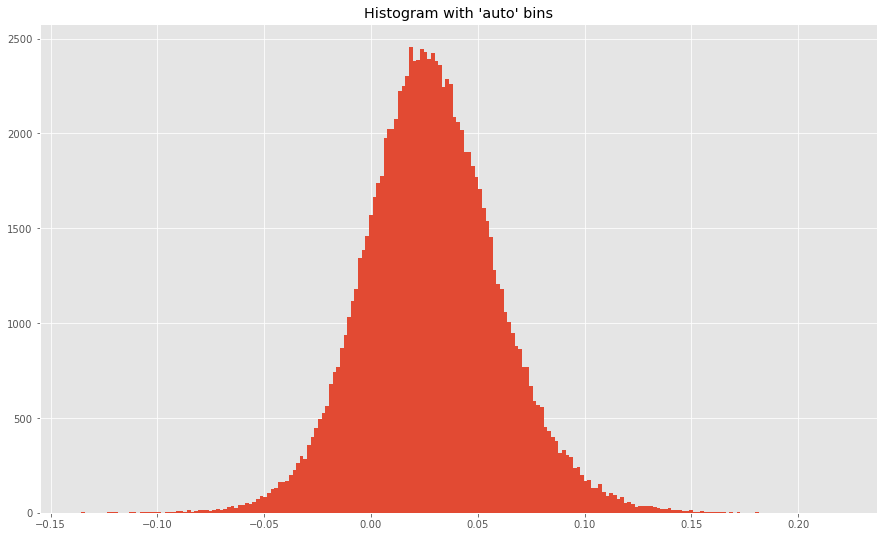

In [92]:
cor_array = []
for x,y1,y2,y3 in zip(XTrain,y1_train, y2_train, y3_train):
    inputs = np.asfarray(x)
    targets = np.zeros(output_nodes) + 0.01
    targets[y1] = .99
    targets[y1_n+y2] = .99
    targets[y1_n+y2_n+y3] = .99
    cor_array.append(sc.stats.spearmanr(np.asfarray([x[0] for x in n.back_query(targets)]),inputs).correlation)
    pass
import matplotlib.pyplot as plt
plt.hist(cor_array, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

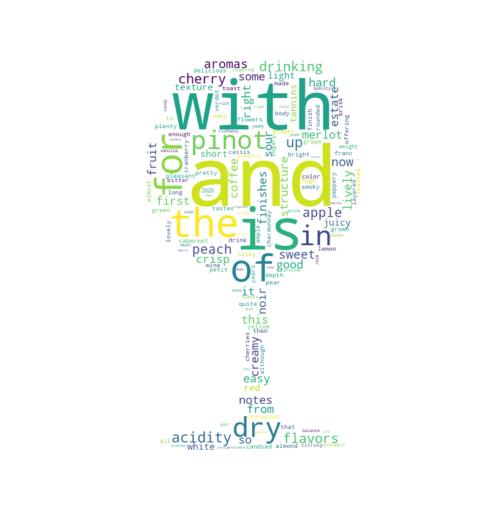

{'2020': 12,
 'accented': 10,
 'acidity': 44,
 'all': 15,
 'almond': 17,
 'almost': 13,
 'although': 14,
 'ample': 13,
 'and': 108,
 'apple': 33,
 'aromas': 31,
 'balance': 11,
 'barrel': 10,
 'bitter': 15,
 'blend': 11,
 'body': 15,
 'bright': 17,
 'brisk': 13,
 'cabernet': 19,
 'candied': 18,
 'candy': 11,
 'cassis': 17,
 'character': 16,
 'chardonnay': 16,
 'cherries': 15,
 'cherry': 36,
 'citrusy': 12,
 'cocoa': 10,
 'coffee': 23,
 'cola': 11,
 'color': 16,
 'cranberry': 14,
 'creamy': 28,
 'crisp': 26,
 'delicious': 17,
 'depth': 16,
 'does': 10,
 'drink': 14,
 'drinking': 37,
 'dry': 47,
 'easy': 22,
 'enough': 18,
 'estate': 22,
 'finish': 18,
 'finishes': 25,
 'first': 27,
 'flavors': 36,
 'flowers': 15,
 'food': 10,
 'for': 50,
 'franc': 19,
 'from': 26,
 'fruit': 27,
 'fruits': 10,
 'good': 22,
 'grape': 15,
 'grapefruit': 12,
 'grapes': 18,
 'green': 19,
 'grown': 14,
 'hard': 23,
 'high': 16,
 'in': 46,
 'is': 58,
 'it': 23,
 'jammy': 12,
 'juicy': 21,
 'layered': 14,
 'lea

In [52]:
n.create_word_cloud(plot_cloud=True, cuttoff=0.01, abs_pass=False, 
                    country='US', category='Red', taster='Paul Gregutt',
                  vectorizer=vectorizer,scaler= scaler, svd=svd1 ,
                    map_mask_path="wine2_removed.png")


# Website to dynamically predict and produce backwards neural network word clouds:

https://arithmeticr.pythonanywhere.com/

## Project Schedule. 
Make sure that you plan your work so that you can avoid a big rush right before the final project deadline, and delegate different modules and responsibilities among your team members. Write this in terms of weekly deadlines.
<table>


<tr><th>Date</th><th>Item</th><th>Assigned</th><th>Details</th></tr>
<tr>
<td>Finish March 27, 2018</td><td>Acquire Data</td>
<td>Brian Lead</td>
<td>
Pulling data from https://www.winemag.com using python.
</td>
</tr>

<tr>
<td>Finish March 29, 2018</td><td>Clean Data</td>
<td>Li Lead</td>
<td>
Start on prelim data.
</td>
</tr>

<tr>
<td>Finish March 29, 2018</td><td>Explore Data</td>
<td>Trevor Lead</td>
<td>
Start on prelim data
</td>
</tr>

<tr>
<td>Start March 29, 2018</td><td>Start Analysis</td>
<td>Team</td>
<td>
Run prelim models on full data before milestone.
</td>
</tr>


<tr>
<td>Due Apr 1, 2018</td><td>Project Milestone Due</td>
<td>Team</td>
<td>
<p>
For your milestone, we expect you to have acquired, cleaned, and explored your dataset. You should also explain in more detail what will go into your final analysis. Explain deviations from your initial project plan.
</p>
</td>
</tr>

<tr>
<td>Finish Apr 6, 2018</td><td>Finish Analysis</td>
<td>Team</td>
<td>
<br>What are the key drivers for wine points and wine price? Penalised linear models (elastic net) and trees.
<br>Which wines are systematically over or under valued in terms of price? Penalised linear models, random forests, gradient
boosting machines, k-NNs, SVMs, and Neural Networks.
<br>What attributes per wine should you use to market them? PCA, FA, SEMs, and Bayesian Networks.
<br>How similar are different wines varieties? Clustering and profiling.
</td>
</tr>

<tr>
<td>Finish Apr 6, 2018</td><td>Document findings</td>
<td>Team</td>
<td>
Update Jupyter Notebook.
</td>
</tr>

<tr>
<td>Finish Apr 13, 2018</td><td>Create Prediction Tool</td>
<td>Team</td>
<td>
Create Html tool to output results and visualization dynamically
</td>
</tr>

<tr><td>?</td><td>Project Review with the staff</td><td>Team</td><td></td></tr>
<tr>
<td>Finish Apr 13, 2018</td><td>Develop screen-cast</td>
<td>Team</td>
<td>
<p>You must also include a three minute video including audio walking us through your project. Each team will create a three minute screen-cast with narration showing a demo of your project and/or some slides. You can use any screencast tool of your choice. Please make sure that the sound quality of your video is good. Upload the video to an online video-platform such as YouTube or Vimeo and link to it from your notebook.
</p>
<p>
We will strictly enforce the three minute time limit for the video, so please make sure you are not running longer. Use principles of good storytelling and presentations to get your key points across. Focus the majority of your screencast on your main contributions rather than on technical details. What do you feel is the best part of your project? What insights did you gain? What is the single most important thing you would like your audience to take away? Make sure it is front and center rather than at the end.
</p>
</td>
</tr>
<tr>
<td>Finish Apr 20, 2018</td>
<td>Complete peer evaluations</td>
<td>Team</td>
<td>
<p>
It is important to provide positive feedback to people who truly worked hard for the good of the team and to also make suggestions to those you perceived not to be working as effectively on team tasks. We ask you to provide an honest assessment of the contributions of the members of your team, including yourself. The feedback you provide should reflect your judgment of each team member’s:
</p>
<ul>
<li>Preparation – were they prepared during team meetings?</li>
<li>Contribution – did they contribute productively to the team discussion and work?</li>
<li>Respect for others’ ideas – did they encourage others to contribute their ideas?</li>
<li>Flexibility – were they flexible when disagreements occurred?</li>
</ul>
<p>
Your teammate’s assessment of your contributions and the accuracy of your self-assessment will be considered as part of your overall project score.
</p>
</td>
</tr>
<tr>
<td>Due Apr 22, 2018</td><td>Final Project Due</td>
<td>Team</td>
<td>
<p>
For your final project you must complete the analysis in your notebook and present your results in a compelling way.
</p>
</td>
</tr>
</tr>
<tr>
<td>?</td><td>Project Presentation</td>
<td>Team</td>
<td>
<p>
Each team will be given a brief slot (~5 minutes) to present their project in one of the two last lectures. Present your analysis questions and your main contributions, but also explain your methods and justify your choices. What do you feel is the best part of your project? What insights did you gain? What is the single most important thing you would like your audience to take away?
</p>
</td>
</tr>
</table>

# Peer Review

Group Name: Weather our power consumption will change?

Reviewers: Brian Tillman and Trevor Olsen

Group Member Names: Aaron Young

Objective: Identifying how much power is being used depending on the weather forecast. Witch buildings use the most? Model will not handle real time data but will predict daily based on weather. 

Dataset:
Collecting weather data from different sources, and power consumption of University of Utah buildings.

Data Processing:
Data must be collected in the middle of the month because of pay system first week of the month. Cleaning the data is going to be time intensive, the project is going to depend on how fast they can collect the data.

Exploratory Analysis:
Use the client tool provided by the university to do introductory information and explore the variables that are affected the most by weather. Built in visualization tools will help with analysis.

Analysis Methods:
None linear auto regressive with exogenous
Data Visualization for weather factors on power consumption.
Focus on the power usage not cost.

Must have Features:
Want to have good model to correlate with weather data. Pick what building the user is looking at. Overall energy consumption on campus (Sum all equipment on campus). 

Optional Features:
Explore the cost model
Heat map the data on to the university of Utah campus map.
Add energy usage to the campus map
Separate models for bigger buildings

Schedule:
Data Collected over spring break


General Questions:

•	Very interesting and unique data set. Operational data collection and presenting to the university facility board. 
•	The model will be daily not real time data. Pulling slices of data vs the model.

Data Acquisition and Clean Up:

•	The data acquisition is going to need a bit of clean up because the data is large and trouble accessing. The project will solve a solution for other building managers.
•	Go to browsers-based API and then scrap for unique identifiers.
•	Hundreds of buildings and each building has at least 4 sections in the building each contacting 4 parts. No hospital data and other buildings are restricted.
•	Gathering weather data from multiple sources.
•	How are you going to store the data? Pull the data and then pull data for a training set, then use the data from one data to

Analysis Methodology:

•	Equipment clustering could be used to visualize the coalition to each other and weather. In a moment of time the equipment’s will have a different distance.
•	Random effects model with in the time frame.
•	Heat map the data on to the university of Utah campus map could be more important for the project.
•	Equipment is going to vary, and you can find meters that are not correlated with each other.




